# Box office Prediction


## Project definition:

To try and build a model to predict for a given movie its overall worldwide Box Office revenue.
The data set includes past movies with information about them including the cast, the director, plot keywords… And of course, for the training data points we have the classification (total Box office revenue)

## Data Exploration:

First step to start with is always to explore the data set we are given. This will include independently analyzing each of the features, finding correlations between them, dimensionality reduction and feature selection.

In [1]:
import time
from csv import QUOTE_NONNUMERIC, QUOTE_NONE
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import ast
import matplotlib.pyplot as plt
import math
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
from PIL import Image
from urllib.request import urlopen
from statistics import median, mean
import operator
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
# couldnt install: import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import eli5
from copy import deepcopy
from imdb import IMDb
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import shap

### Features:

The features we have in the data set are:

In [2]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train_set.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [3]:
train_set.describe()

id        budget   popularity      runtime       revenue
count  3000.000000  3.000000e+03  3000.000000  2998.000000  3.000000e+03
mean   1500.500000  2.253133e+07     8.463274   107.856571  6.672585e+07
std     866.169729  3.702609e+07    12.104000    22.086434  1.375323e+08
min       1.000000  0.000000e+00     0.000001     0.000000  1.000000e+00
25%     750.750000  0.000000e+00     4.018053    94.000000  2.379808e+06
50%    1500.500000  8.000000e+06     7.374861   104.000000  1.680707e+07
75%    2250.250000  2.900000e+07    10.890983   118.000000  6.891920e+07
max    3000.000000  3.800000e+08   294.337037   338.000000  1.519558e+09

Some of these features have strings values, 
others are lists of dictionaries displayed as strings.
We will convert these features to python dictionaries for ease of access.

In [4]:
LIST_COLS = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def convert_text_cols_to_list(df):
    for col in LIST_COLS:
        df[col] = [{} if pd.isna(value) else ast.literal_eval(value) for value in df[col]]
    return df

train_set = convert_text_cols_to_list(train_set)
test_set = convert_text_cols_to_list(test_set)

In [5]:
train_set.head(2)

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   

                                              genres homepage    imdb_id  \
0                     [{'id': 35, 'name': 'Comedy'}]      NaN  tt2637294   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...      NaN  tt0368933   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   

                           spoken_languages    status  \
0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   

                                                crew   revenue  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651  
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435

Now we’ll go through each of these features and analyze their potentional contribution to the classification/their correlations with other features, and possibly construct new features using the existing ones

### Genres :
As we can see from the table above, movies might belong to more than one genre, the values for this feature are a list which its elements are dictionaries with a genre id and a genre name. for example the movie with the id 2 belongs to genres Comedy (genre id 35), Drama(genre id 18), Family (genre id 10751) and Romance (genre id 10749).
	


In [6]:
train_set["genres"][1]

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'}]

The genre id will probably not be helpful for extracting information about the movie, it is just an overhead. 
We could use the genre id *instead* of using the genre name, we prefer to use the names since it is easier to comprehend.

Since we can’t define any order for genres, a good approach for dealing with such a nominal feature is to transform it to a group of “dummy” binary features. I.e. each feature will indicate whether or not the movie belongs to the specific genre.
For example: The movie with the id 2 will have the value 1 for the newly constructed features genre_name_comedy, genre_name_drama, genre_name_family and genre_name_romance, and 0 in all the other “genre_name_” feature.

In [7]:
genre_names_with_repetions = list(x["name"] for l in train_set["genres"] for x in l)
genre_names_with_repetions

['Comedy',
 'Comedy',
 'Drama',
 'Family',
 'Romance',
 'Drama',
 'Thriller',
 'Drama',
 'Action',
 'Thriller',
 'Animation',
 'Adventure',
 'Family',
 'Horror',
 'Thriller',
 'Documentary',
 'Action',
 'Comedy',
 'Music',
 'Family',
 'Adventure',
 'Comedy',
 'Music',
 'Drama',
 'Comedy',
 'Drama',
 'Comedy',
 'Crime',
 'Action',
 'Thriller',
 'Science Fiction',
 'Mystery',
 'Action',
 'Crime',
 'Drama',
 'Horror',
 'Thriller',
 'Drama',
 'Romance',
 'Comedy',
 'Romance',
 'Action',
 'Thriller',
 'Crime',
 'Adventure',
 'Family',
 'Science Fiction',
 'Horror',
 'Thriller',
 'Thriller',
 'Horror',
 'Thriller',
 'Mystery',
 'Foreign',
 'Horror',
 'Comedy',
 'Comedy',
 'Horror',
 'Mystery',
 'Thriller',
 'Crime',
 'Drama',
 'Mystery',
 'Thriller',
 'Drama',
 'Comedy',
 'Romance',
 'Animation',
 'Action',
 'Adventure',
 'Crime',
 'Thriller',
 'Drama',
 'Comedy',
 'Mystery',
 'Drama',
 'Thriller',
 'Fantasy',
 'Action',
 'Adventure',
 'Horror',
 'Action',
 'Comedy',
 'Crime',
 'Thriller',
 'Action',
 'Crime',
 'Thriller',
 'Comedy',
 'Romance',
 'Action',
 'Drama',
 'Science Fiction',
 'Thriller',
 'Thriller',
 'War',
 'Western',
 'Action',
 'Documentary',
 'Crime',
 'Drama',
 'Comedy',
 'Drama',
 'Comedy',
 'Romance',
 'Crime',
 'Drama',
 'Mystery',
 'Romance',
 'Thriller',
 'Animation',
 'Family',
 'Comedy',
 'Adventure',
 'Crime',
 'Drama',
 'Mystery',
 'Western',
 'Drama',
 'Comedy',
 'Science Fiction',
 'Action',
 'Adventure',
 'Thriller',
 'Romance',
 'Drama',
 'Comedy',
 'Adventure',
 'Comedy',
 'Adventure',
 'Family',
 'Drama',
 'Family',
 'Romance',
 'Action',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Drama',
 'Action',
 'Crime',
 'Fantasy',
 'Music',
 'Romance',
 'Action',
 'Adventure',
 'Comedy',
 'Adventure',
 'Action',
 'Thriller',
 'Drama',
 'Thriller',
 'Fantasy',
 'Crime',
 'Drama',
 'Horror',
 'Thriller',
 'Drama',
 'Adventure',
 'Action',
 'Crime',
 'Comedy',
 'Drama',
 'Crime',
 'Drama',
 'Action',
 'Crime',
 'Drama',
 'Thriller',
 'Drama',
 'Mystery',
 'Thriller',
 'Fantasy',
 'Drama',
 'Comedy',
 'Music',
 'Crime',
 'Documentary',
 'Crime',
 'Drama',
 'Horror',
 'Comedy',
 'Drama',
 'Romance',
 'Foreign',
 'Comedy',
 'Crime',
 'Drama',
 'Action',
 'Thriller',
 'Horror',
 'Thriller',
 'Action',
 'Crime',
 'Drama',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Drama',
 'Horror',
 'Mystery',
 'Thriller',
 'Thriller',
 'Science Fiction',
 'Horror',
 'Mystery',
 'Action',
 'Adventure',
 'Drama',
 'Mystery',
 'Science Fiction',
 'Thriller',
 'Drama',
 'Crime',
 'Action',
 'Comedy',
 'Thriller',
 'Drama',
 'History',
 'Drama',
 'Thriller',
 'Mystery',
 'Romance',
 'Action',
 'Crime',
 'Drama',
 'War',
 'Adventure',
 'Drama',
 'Romance',
 'Drama',
 'History',
 'Thriller',
 'Drama',
 'Mystery',
 'Drama',
 'Action',
 'Comedy',
 'Thriller',
 'Romance',
 'Fantasy',
 'Drama',
 'Animation',
 'Comedy',
 'Adventure',
 'Family',
 'Action',
 'Crime',
 'Drama',
 'Action',
 'Thriller',
 'Science Fiction',
 'Crime',
 'Horror',
 'Drama',
 'Romance',
 'Action',
 'Comedy',
 'Crime',
 'Foreign',
 'Drama',
 'Comedy',
 'Drama',
 'Drama',
 'Action',
 'Drama',
 'History',
 'War',
 'Drama',
 'Comedy',
 'Romance',
 'Drama',
 'Adventure',
 'Romance',
 'Action',
 'Comedy',
 'Crime',
 'Romance',
 'Comedy',
 'Romance',
 'Drama',
 'Thriller',
 'Drama',
 'Adventure',
 'Action',
 'History',
 'Comedy',
 'Drama',
 'Romance',
 'Adventure',
 'Fantasy',
 'Action',
 'Action',
 'Comedy',
 'Drama',
 'Action',
 'Adventure',
 'Comedy',
 'Drama',
 'Romance',
 'Crime',
 'Action',
 'Comedy',
 'Action',
 'Comedy',
 'Crime',
 'Thriller',
 'Adventure',
 'Animation',
 'Drama',
 'Family',
 'Action',
 'Comedy',
 'Crime',
 'Mystery',
 'Thriller',
 'Action',
 'Crime',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Drama',
 'War',
 'Action',
 'Adventure',
 'Comedy',
 'Horror',
 'Drama',
 'Thriller',
 'Mystery',
 'Horror',
 'Thriller',
 'Drama',
 'Comedy',
 'Drama',
 'Thriller',
 'Documentary',
 'History',
 'Comedy',
 'Drama',
 'Comedy',
 'Romance',
 'Adventure',


Just before we jump into constructing the new dummy features, let's have a look at the popularity of each genre.

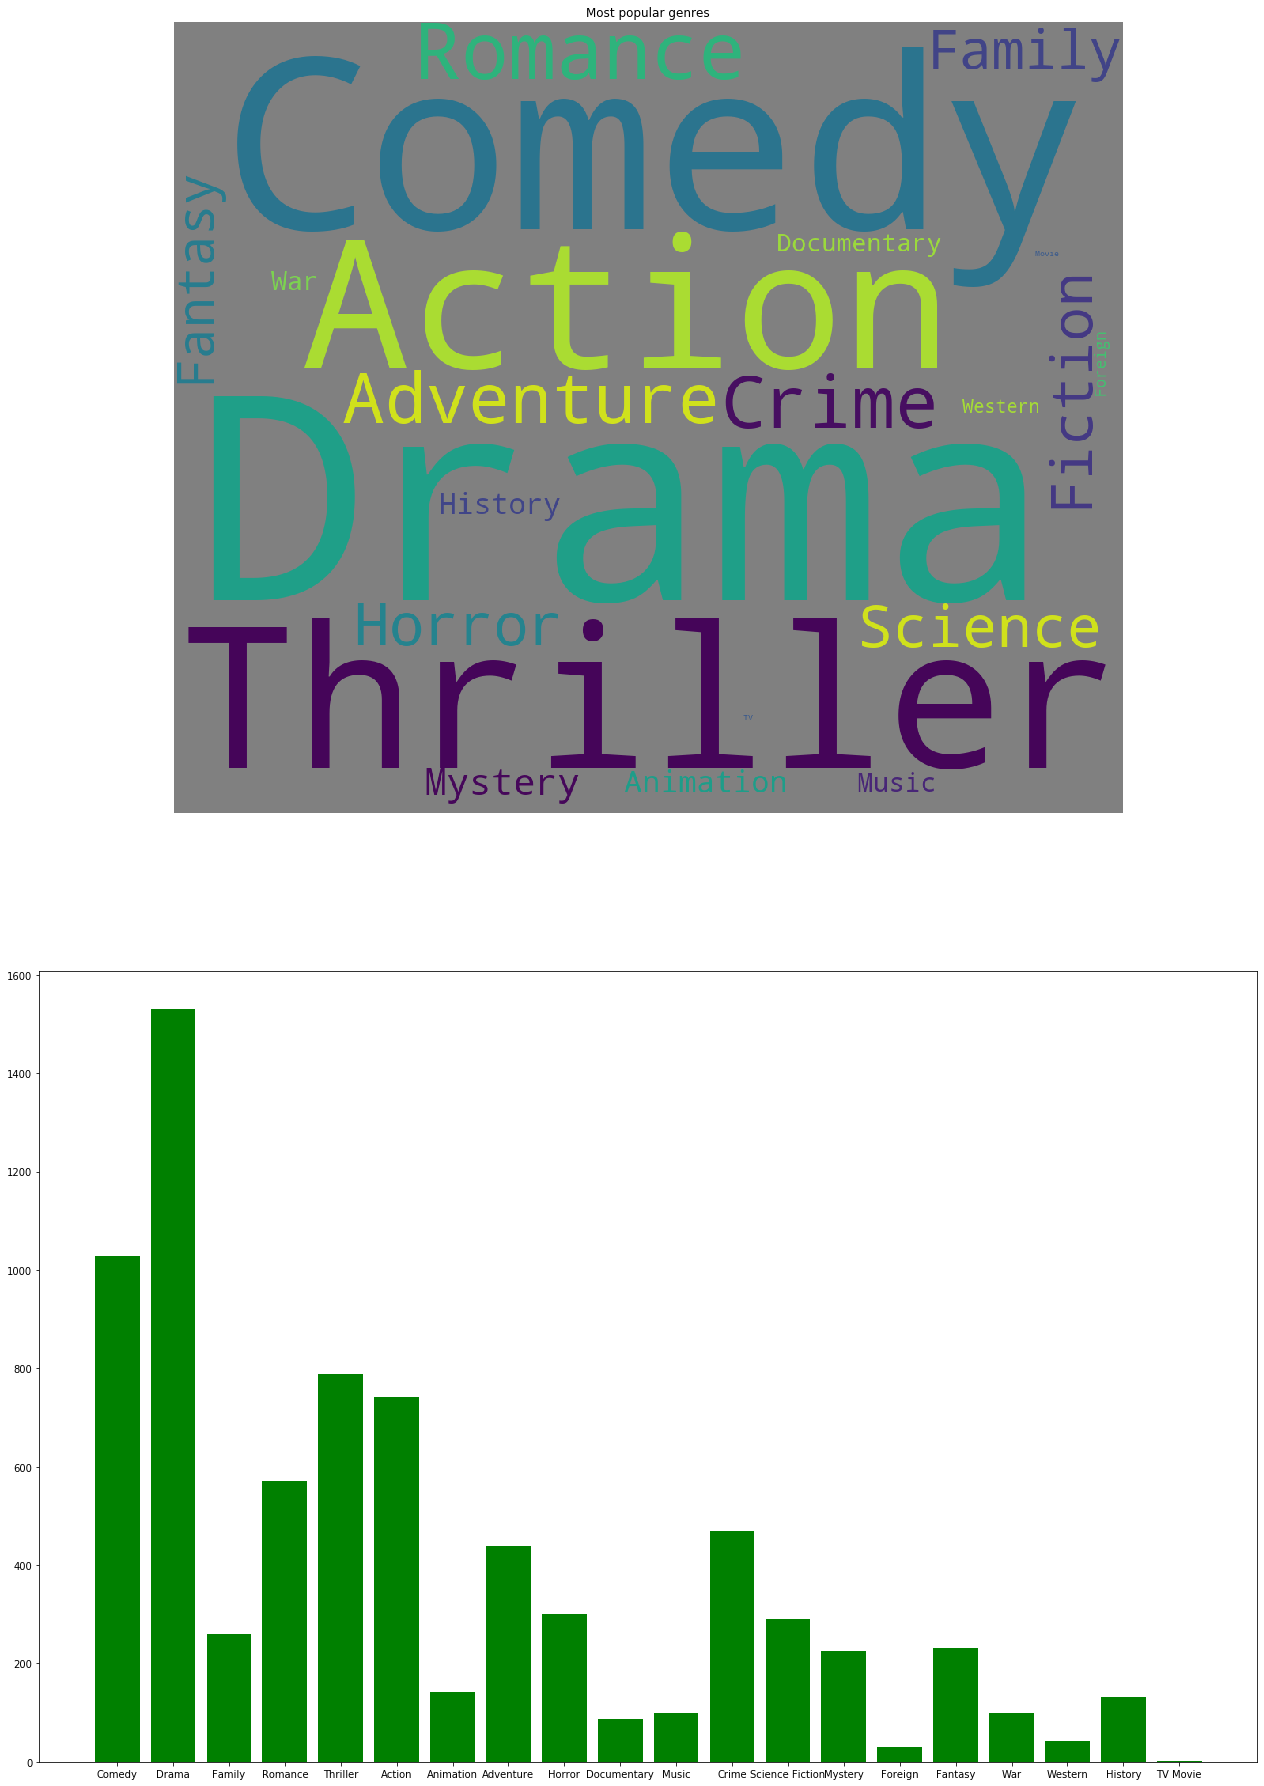

In [8]:

plt.figure(figsize = (48, 32))
text = ' '.join([i for i in genre_names_with_repetions])

wordcloud = WordCloud(max_font_size=None, background_color='grey', collocations=False,
                      width=1200, height=1000).generate(text)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud)
plt.title('Most popular genres')
plt.axis("off")

genre_names_popularity = {}
for genre in genre_names_with_repetions:
    if genre in genre_names_popularity.keys():
        continue
    genre_names_popularity[genre] = genre_names_with_repetions.count(genre)

plt.subplot(2, 2, 3)   
plt.bar(genre_names_popularity.keys(), genre_names_popularity.values(), color='g')

plt.show()

We can see that genres such like "TV Movie", "Foreign", "Western" and "Documentary" have very few appearences in comparison to other genres. We think it is safe to identify those genres as "outliers", in a sense that there is not enough data in the training set to rely on, when trying to find a difference between a movie that does belong to the "TV Movie" genre, for example, and another that doesn't.
In fact, there is only one movie that belongs to this genre, and this might be an enough of a reason for our model to determine the revenue of any movie that belongs to this genre, although it can not learn much about movies from this genre based only a single data point.

So in order to remain on the safe side and not to over-fit our model, we will create the new dummy features based only on genres that have more than 100 appearences. Other genres won't be taken into consideration for creating our model.

In [9]:
MOST_POPULAR_GENRES = [genre for genre in genre_names_popularity.keys() if genre_names_popularity[genre]>=100]
def convert_genre_feature_to_dummy_features(df):
    for genre_name in MOST_POPULAR_GENRES:
        df["genre_name_"+genre_name] = [1 if genre_name in str(l) else 0
                                           for l in df["genres"]]
        
convert_genre_feature_to_dummy_features(train_set)
convert_genre_feature_to_dummy_features(test_set)
train_set.head(2)

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   

                                              genres homepage    imdb_id  \
0                     [{'id': 35, 'name': 'Comedy'}]      NaN  tt2637294   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...      NaN  tt0368933   

  original_language                            original_title  \
0                en                    Hot Tub Time Machine 2   
1                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   

                           spoken_languages    status  \
0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   

   genre_name_Comedy  genre_name_Drama  genre_name_Family  genre_name_Romance  \
0                  1                 0                  0                   0   
1                  1                 1                  1                   1   

   genre_name_Thriller  genre_name_Action  genre_name_Animation  \
0                    0                  0                     0   
1                    0                  0                     0   

   genre_name_Adventure  genre_name_Horror  genre_name_Music  \
0                     0                  0                 0   
1                     0                  0                 0   

   genre_name_Crime  genre_name_Science Fiction  genre_name_Mystery  \
0                 0                           0                   0   
1                 0                           0                   0   

   genre_name_Fantasy  genre_name_War  genre_name_History  
0                   0               0                   0  
1                   0               0                   0

We can see for example, the first two movies have the correct vectors to descripe their genres.


Another interesting aspect to view the "genre" feature from is the number of genres for each movie.
To demonstrate that let's add this feature to our data and plot the relation between the number of generes and the total revenue.

Text(0.5, 1, '# of genres vs revenue')

<Figure size 1440x576 with 0 Axes>

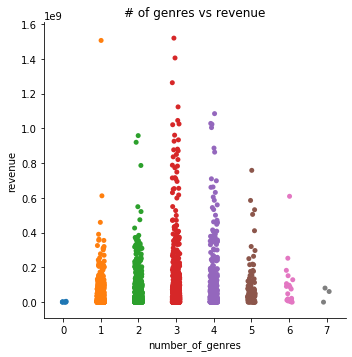

In [10]:
train_set["number_of_genres"] = [len(l) for l in train_set["genres"]]

plt.figure(figsize=(20, 8))
sns.catplot('number_of_genres','revenue', data=train_set)
plt.title('# of genres vs revenue')

It appears there is some kind of a second order relation between this new feature and the revenue. No reason to remove it. We will also construct this feature for the test set.

In [11]:
test_set["number_of_genres"] = [len(l) for l in test_set["genres"]]

Finally, we can remove the the "genres" column.

In [12]:
train_set.drop(['genres'], axis=1, inplace=True)
test_set.drop(['genres'], axis=1, inplace=True)
train_set.head(2)

id                              belongs_to_collection    budget homepage  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000      NaN   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000      NaN   

     imdb_id original_language                            original_title  \
0  tt2637294                en                    Hot Tub Time Machine 2   
1  tt0368933                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   

                           spoken_languages    status  \
0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   

   genre_name_Comedy  genre_name_Drama  genre_name_Family  genre_name_Romance  \
0                  1                 0                  0                   0   
1                  1                 1                  1                   1   

   genre_name_Thriller  genre_name_Action  genre_name_Animation  \
0                    0                  0                     0   
1                    0                  0                     0   

   genre_name_Adventure  genre_name_Horror  genre_name_Music  \
0                     0                  0                 0   
1                     0                  0                 0   

   genre_name_Crime  genre_name_Science Fiction  genre_name_Mystery  \
0                 0                           0                   0   
1                 0                           0                   0   

   genre_name_Fantasy  genre_name_War  genre_name_History  number_of_genres  
0                   0               0                   0                 1  
1                   0               0                   0                 4

#### Spoken_languages

Much like to the "generes" feature, the values here are also lists of dictionaries, where each dictionary has the language and an abreviation. for example, let's have a look at some data point's value fo this featue:

In [13]:
test_set["spoken_languages"][1]

[{'iso_639_1': 'en', 'name': 'English'}]

We will be dealing with this feature in a very similar way to the way we dealt with "genres" feature.
Let's first look at the popularities of each language

In [14]:
spoken_languages_with_repetions = list(x["name"] for l in train_set["spoken_languages"] for x in l)
for lang in spoken_languages_with_repetions:
    print(lang)

English
English
English
English
हिन्दी
한국어/조선말
English
English
العربية
English
English
English
English
English
English
English
Pусский
English
svenska
Srpski
English
Pусский
English
Deutsch
English
English
Français
Italiano
English
English
English
English
English
Français
Italiano
English
English
English
English
日本語
English
English
Français
Français
English
العربية
English
Français
Deutsch
עִבְרִית
日本語
Português
Latin
English
Français
日本語
普通话
English
普通话
Pусский
English
English
한국어/조선말
Français
English
日本語
Español
English
Français
Español
English
English
Français
English
English
English
Italiano
Español
English
Español
English
English
English
Nederlands
English
Italiano
English
English
English
English
English
Français
English
English
English
Français
English
Français
English
Italiano
English
English
English
Español
English
English
广州话 / 廣州話
普通话
English
English
日本語
English

Español
English
Český
English
English
English
தமிழ்
తెలుగు
English
English
Deutsch
English
Español
English
English

English
English
Español
English
English
English
English
English
English
English
हिन्दी
한국어/조선말
English
Español
English
English
English
English
English
English
English
English
English
English
Français
Deutsch
Polski
Pусский
English
No Language
English
Pусский
English
Français
普通话
English
English
English
English
Polski
English
Français
Latin
Español
English
English
Français
English
English
English
English
Український
Pусский
English
English
English
Esperanto
English
English
English
Pусский
English
English
English
English
Français
English
العربية
English
Español
English
普通话
English
English
English
Pусский
English
Italiano
Español
English
العربية
Dansk
English
English
Français
English
English
English
English
English
English
English
English
Polski
English
English
English
English
日本語
English
English
English
English
English
Pусский
English
English
English
Español
euskera
English
English
English
English
한국어/조선말
English
English
Italiano
svenska
English
English
Español
English
English
English
En

English
English
English
Deutsch
English
한국어/조선말
普通话
English
English
English
English
日本語
Pусский
普通话
Deutsch
Français
English
Español
English
English
English
Español
English
English
Italiano
Türkçe
English
English
Français
English
English
Français
Deutsch
English
English
Deutsch
Français
Latin
العربية
ελληνικά
English
English
English

English
हिन्दी
தமிழ்
English
English
English
Italiano
English
English
English
Français
Español
Český
English
English
English
English
Deutsch
English
English
Español
广州话 / 廣州話
English
English
English
Español
English
Français
English
English
English
हिन्दी
English
English
English
English
English
English
Français
Italiano
English
English
English
English
Hrvatski
English
日本語
हिन्दी
English
Français
日本語
English
Español
English
English
Français
svenska
தமிழ்
Português
English
Italiano
English
English
日本語
English
English
English
한국어/조선말
English
English
English
English
English
English
English
English
English
Français
English
한국어/조선말
English
English
English
Portugu

This time, it will be easier to deal with the abreviations since they are all written with english letters.

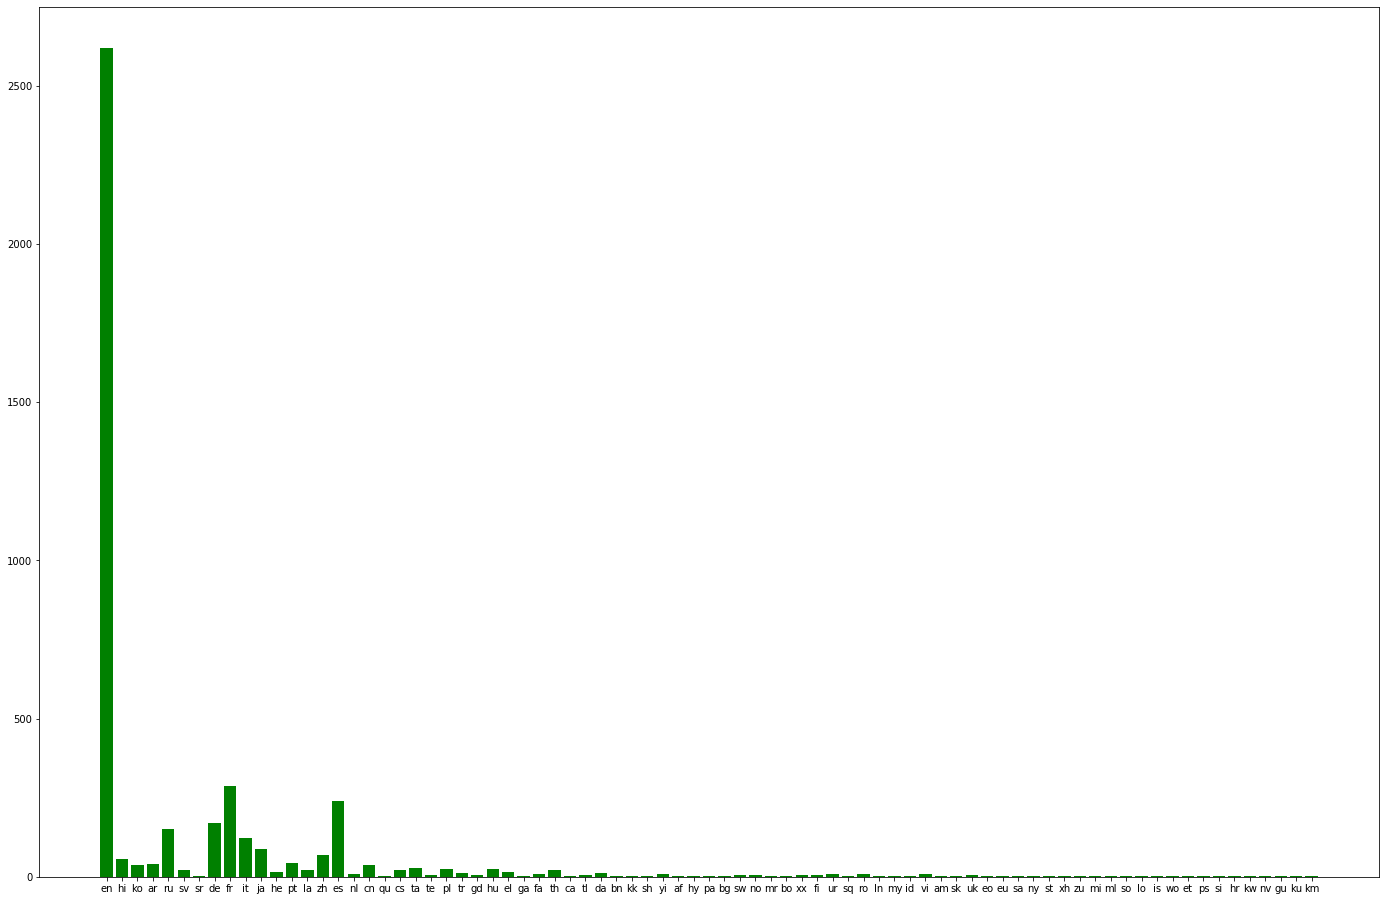

In [15]:
spoken_languages_with_repetions = list(x["iso_639_1"] for l in train_set["spoken_languages"] for x in l)
plt.figure(figsize = (24, 16))

spoken_languages_popularity = {}
for lang in spoken_languages_with_repetions:
    if lang in spoken_languages_popularity.keys():
        continue
    spoken_languages_popularity[lang] = spoken_languages_with_repetions.count(lang)

plt.bar(spoken_languages_popularity.keys(), spoken_languages_popularity.values(), color='g')

plt.show()

From the looks of it English is a much more popular language amongst movies than all other languages, therefore it will be interesting to divide the movies into two sets: English movies and "foreign" movies (meaning movies that don't have english as a spoken language).

Text(0.5, 1.0, 'Spoken language (English=1/Foreign=0) vs revenue')

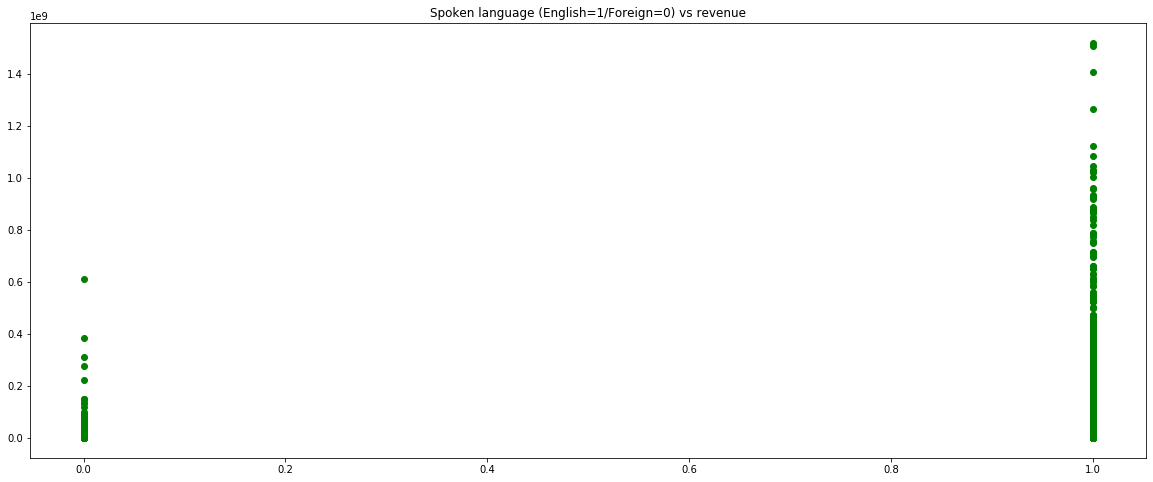

In [16]:
train_set["spoken_english"] = [1 if "English" in str(l) else 0 for l in train_set["spoken_languages"]]
plt.figure(figsize=(20, 8))
plt.scatter(train_set['spoken_english'], train_set['revenue'], color="g")
plt.title('Spoken language (English=1/Foreign=0) vs revenue')

This plot supports our claim, and that is that it is very much interesting whether a movie has English as a spoken language in it or not. It also makes some sense, because English is the universal language which helps a movie get more global attention/popularity and therefore greater revenues.

In [17]:
test_set["spoken_english"] = [1 if "English" in str(l) else 0 for l in test_set["spoken_languages"]]

Another interesting perspective is -just like in the "Generes" feature- the number of spoken languages per each movie. Like we did before, we will check the relevance of the number of spoken languages by plotting it against the revenue.

Text(0.5, 1, '# of spoken languages vs revenue')

<Figure size 1440x576 with 0 Axes>

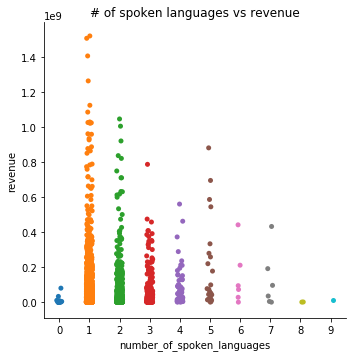

In [18]:
train_set["number_of_spoken_languages"] = [len(l) for l in train_set["spoken_languages"]]

plt.figure(figsize=(20, 8))
sns.catplot('number_of_spoken_languages', 'revenue', data=train_set)
plt.title('# of spoken languages vs revenue')

It is clear that there is some linear correlation between the number of spoken languages in a film and its total revenue (The less spoken languages -excluding the silent movies- the greater the revenue) . We should probably keep this new feature (and add it to the test set of course).

In [19]:
test_set["number_of_spoken_languages"] = [len(l) for l in test_set["spoken_languages"]]

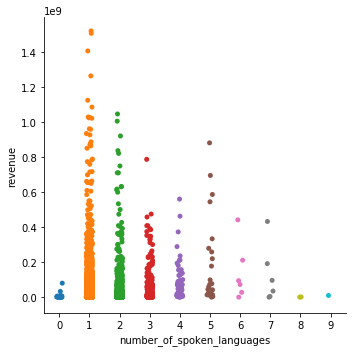

In [20]:
sns.catplot('number_of_spoken_languages','revenue', data=train_set)

And finally, we can remove the original "spoken_languages" feature.

In [21]:
train_set.drop(['spoken_languages'], axis=1, inplace=True)
test_set.drop(['spoken_languages'], axis=1, inplace=True)
train_set.head(2)

id                              belongs_to_collection    budget homepage  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000      NaN   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000      NaN   

     imdb_id original_language                            original_title  \
0  tt2637294                en                    Hot Tub Time Machine 2   
1  tt0368933                en  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   

     status                                            tagline  \
0  Released  The Laws of Space and Time are About to be Vio...   
1  Released  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   

   genre_name_Comedy  genre_name_Drama  genre_name_Family  genre_name_Romance  \
0                  1                 0                  0                   0   
1                  1                 1                  1                   1   

   genre_name_Thriller  genre_name_Action  genre_name_Animation  \
0                    0                  0                     0   
1                    0                  0                     0   

   genre_name_Adventure  genre_name_Horror  genre_name_Music  \
0                     0                  0                 0   
1                     0                  0                 0   

   genre_name_Crime  genre_name_Science Fiction  genre_name_Mystery  \
0                 0                           0                   0   
1                 0                           0                   0   

   genre_name_Fantasy  genre_name_War  genre_name_History  number_of_genres  \
0                   0               0                   0                 1   
1                   0               0                   0                 4   

   spoken_english  number_of_spoken_languages  
0               1                           1  
1               1                           1

#### Belongs_to_collection: 

First thing we want to check here is whether for a specified movie, the fact of belonging to some collection would affect the revenue.

In [22]:
train_set['belongs_to_collection'][0]

[{'id': 313576,
  'name': 'Hot Tub Time Machine Collection',
  'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg',
  'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]

We believe that only the name (or the id) would be relevant, So let us extract the (what we believe is) equivelant feature "collection_name"

In [23]:
train_set['collection_name'] = train_set['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

test_set['collection_name'] = test_set['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

Let us seperate the data into movies that do belong to some collection and movies that don't.

Text(0.5, 1.0, 'has/ does not have collection vs revenue')

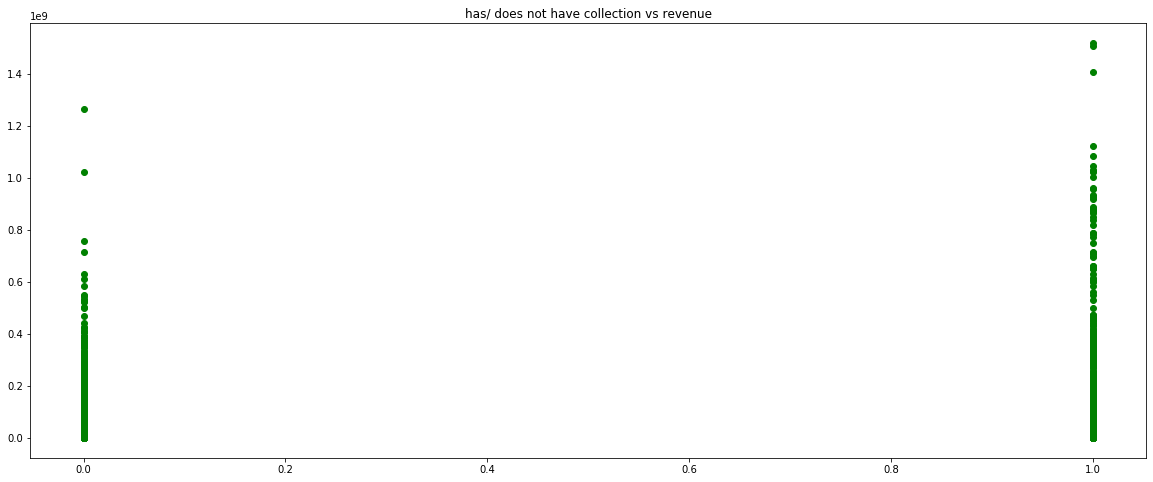

In [24]:
train_set['has_collection'] = train_set['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
plt.figure(figsize=(20, 8))
plt.scatter(train_set['has_collection'], train_set['revenue'], color="g")
plt.title('has/ does not have collection vs revenue')


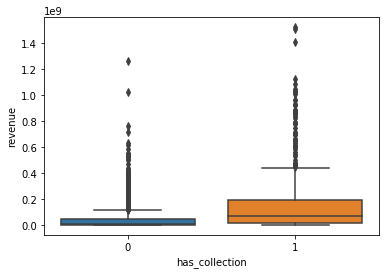

In [25]:
sns.boxplot(x='has_collection', y='revenue', data=train_set)

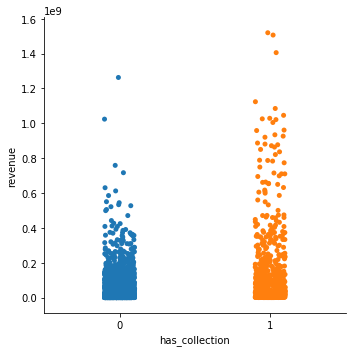

In [26]:
sns.catplot(x='has_collection', y='revenue', data=train_set)



Depending on this box plot, it seems there is some effect of having a collection on the revenue. We can clearly see that the mean revenue for movies belonging to some collection is greater than that of those not belonging to any collection. let's apply the same transformation on the test set:

In [27]:
test_set['has_collection'] = test_set['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)


And as usual, we will remove the original feature.

In [28]:
train_set.drop(['belongs_to_collection'], axis=1, inplace=True)
test_set.drop(['belongs_to_collection'], axis=1, inplace=True)
train_set.head(2)

id    budget homepage    imdb_id original_language  \
0   1  14000000      NaN  tt2637294                en   
1   2  40000000      NaN  tt0368933                en   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   

     status                                            tagline  \
0  Released  The Laws of Space and Time are About to be Vio...   
1  Released  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   

   genre_name_Comedy  genre_name_Drama  genre_name_Family  genre_name_Romance  \
0                  1                 0                  0                   0   
1                  1                 1                  1                   1   

   genre_name_Thriller  genre_name_Action  genre_name_Animation  \
0                    0                  0                     0   
1                    0                  0                     0   

   genre_name_Adventure  genre_name_Horror  genre_name_Music  \
0                     0                  0                 0   
1                     0                  0                 0   

   genre_name_Crime  genre_name_Science Fiction  genre_name_Mystery  \
0                 0                           0                   0   
1                 0                           0                   0   

   genre_name_Fantasy  genre_name_War  genre_name_History  number_of_genres  \
0                   0               0                   0                 1   
1                   0               0                   0                 4   

   spoken_english  number_of_spoken_languages  \
0               1                           1   
1               1                           1   

                   collection_name  has_collection  
0  Hot Tub Time Machine Collection               1  
1  The Princess Diaries Collection               1

#### Budget:
This should be very straight forward, we expect that the higher the budget, the higher the revenues, let's verify this claim


In [29]:
test_set["budget"]

0              0
1          88000
2              0
3        6800000
4        2000000
          ...   
4393    42000000
4394    19000000
4395    16000000
4396     2000000
4397       64000
Name: budget, Length: 4398, dtype: int64

Text(0.5, 1.0, 'budget vs revenue')

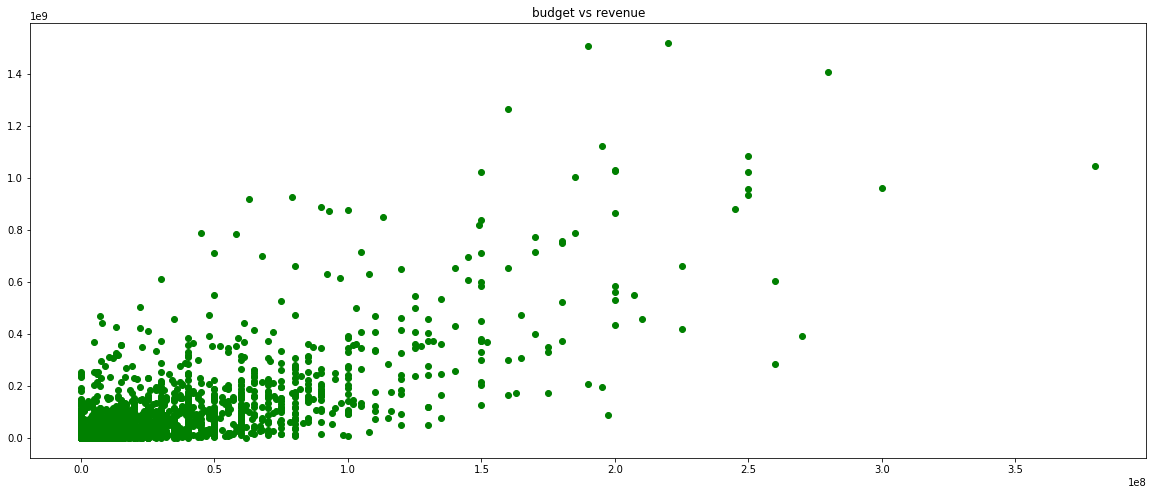

In [30]:
plt.figure(figsize=(20, 8))
plt.scatter(train_set['budget'], train_set['revenue'], color="g")
plt.title('budget vs revenue')

Let's try and bring these numbers down, maybe it'll prove to be more useful...

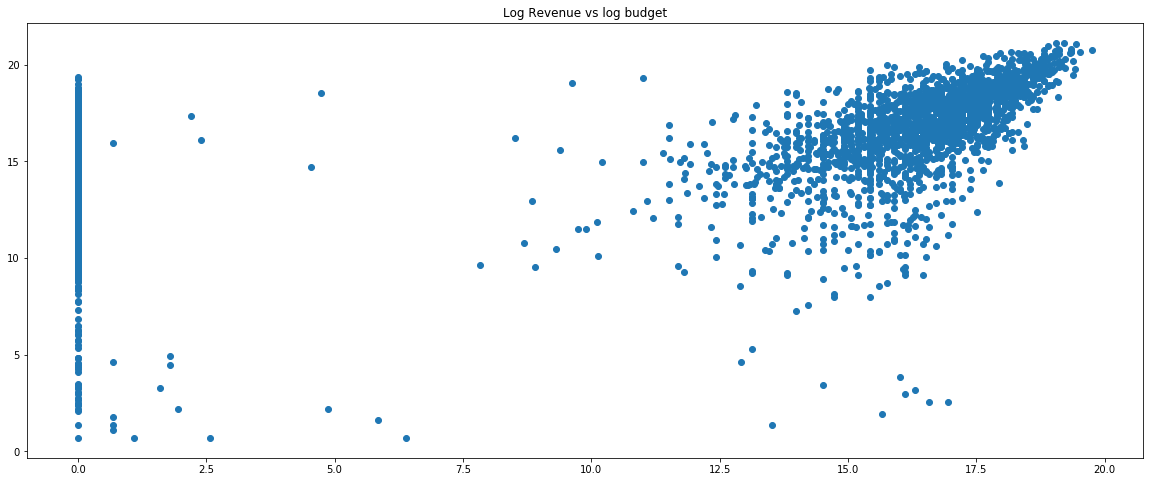

In [31]:
plt.figure(figsize=(20, 8))
plt.scatter(np.log1p(train_set['budget']), np.log1p(train_set['revenue']))
plt.title('Log Revenue vs log budget');

This does look a little more convincing than the previous plot. let's add those features (log of budget and log of revenue)

In [32]:
train_set['log_budget'] = np.log1p(train_set['budget'])
test_set['log_budget'] = np.log1p(test_set['budget'])

In [33]:
train_set["log_revenue"] = np.log1p(train_set['revenue'])

#### Keywords:

In [34]:
train_set["Keywords"]

0       [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1       [{'id': 2505, 'name': 'coronation'}, {'id': 42...
2       [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
3       [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
4                                                      {}
                              ...                        
2995    [{'id': 378, 'name': 'prison'}, {'id': 572, 'n...
2996    [{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...
2997    [{'id': 441, 'name': 'assassination'}, {'id': ...
2998    [{'id': 966, 'name': 'beach'}, {'id': 2676, 'n...
2999    [{'id': 591, 'name': 'cia'}, {'id': 822, 'name...
Name: Keywords, Length: 3000, dtype: object

We will deal with the Keywords in a similar way we dealt with the Generes feature (afterall, they should have a very similar effect on the target);
Transform only the most popular ones into dummy features, and checxk if there is some relation between the number of keywords for a film to its revenues.

In [35]:
keywords_with_repetions = list(x["name"] for l in train_set["Keywords"] for x in l)
print(len(keywords_with_repetions))

21680


We certainly don't want all 21680 keywords, let's have a look at their popularity and decide which keywords we do want in our data

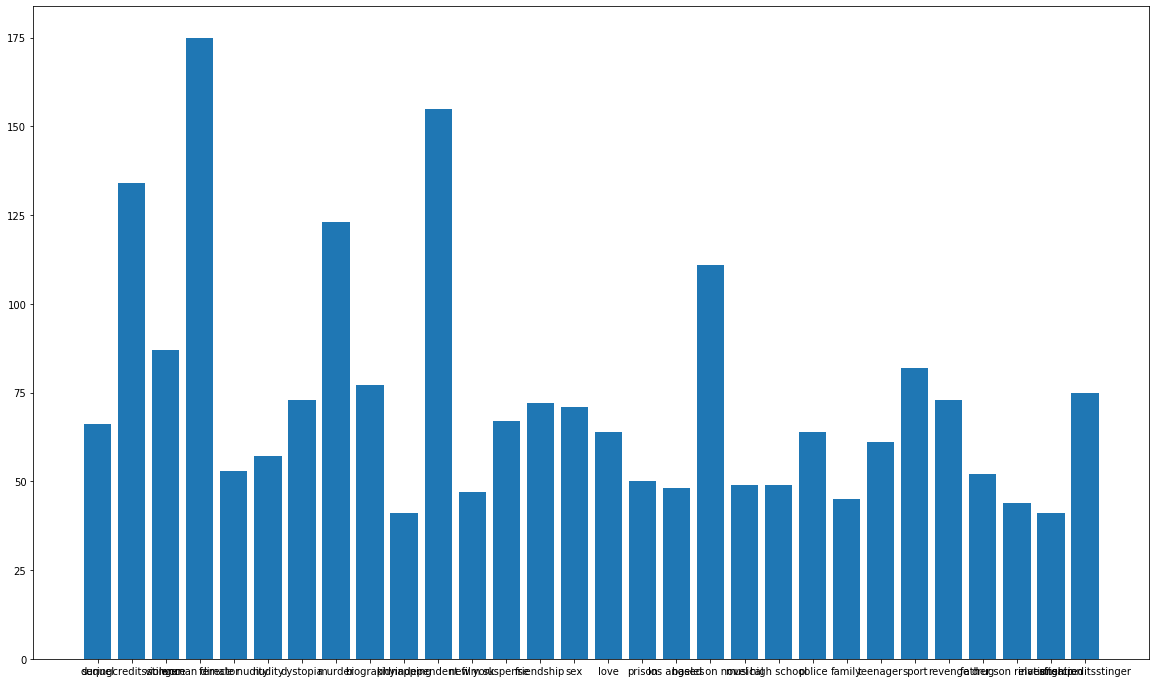

In [36]:
# decoding and encoding in order to ignore non ascii names
keywords_popularity = Counter([kw for kw in keywords_with_repetions])
popular_kw = [(x, keywords_popularity[x]) for x in keywords_popularity if keywords_popularity[x] > 40 ]
unpopular_kw = [(x, keywords_popularity[x]) for x in keywords_popularity if keywords_popularity[x] < 10 ]


plt.figure(figsize=(20, 12))
plt.bar([k[0] for k in popular_kw], [k[1] for k in popular_kw])
plt.show()




In [37]:
#let's just check how many unpopular keywords there are, only for comparison purpuses
print("number of unpopular keywords: {}".format(len(unpopular_kw)))


number of unpopular keywords: 7042


We'll create new dummy feature for all the popular keywords.
We could see from the graphs above that there are much less keywords with 40 - 175 appearances than there are keywords with less than 10 appearences. This tells us that there are few keywords that are very popular (and therefore might be important for classification) and many (many) features that are not popular at all, which can result in overfitting.

In [38]:
def convert_keywords_feature_to_dummy_features(df):
    for kw in popular_kw:
        df["kw_"+kw[0]] = [1 if kw[0] in str(l) else 0
                                           for l in df["Keywords"]]
        
convert_keywords_feature_to_dummy_features(train_set)
convert_keywords_feature_to_dummy_features(test_set)
train_set.head(2)
train_set.drop(['Keywords'], axis=1, inplace=True)
test_set.drop(['Keywords'], axis=1, inplace=True)

### Cast:
let's first have a look at what info is presented in the values of this feature

In [39]:
train_set["cast"][0]

[{'cast_id': 4,
  'character': 'Lou',
  'credit_id': '52fe4ee7c3a36847f82afae7',
  'gender': 2,
  'id': 52997,
  'name': 'Rob Corddry',
  'order': 0,
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'cast_id': 5,
  'character': 'Nick',
  'credit_id': '52fe4ee7c3a36847f82afaeb',
  'gender': 2,
  'id': 64342,
  'name': 'Craig Robinson',
  'order': 1,
  'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'},
 {'cast_id': 6,
  'character': 'Jacob',
  'credit_id': '52fe4ee7c3a36847f82afaef',
  'gender': 2,
  'id': 54729,
  'name': 'Clark Duke',
  'order': 2,
  'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'},
 {'cast_id': 7,
  'character': 'Adam Jr.',
  'credit_id': '52fe4ee7c3a36847f82afaf3',
  'gender': 2,
  'id': 36801,
  'name': 'Adam Scott',
  'order': 3,
  'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'},
 {'cast_id': 8,
  'character': 'Hot Tub Repairman',
  'credit_id': '52fe4ee7c3a36847f82afaf7',
  'gender': 2,
  'id': 54812,
  'name': 'Chevy Chase',
  'order': 4,
  'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'},
 {'cast_id': 9,
  'character': 'Jill',
  'credit_id': '52fe4ee7c3a36847f82afafb',
  'gender': 1,
  'id': 94098,
  'name': 'Gillian Jacobs',
  'order': 5,
  'profile_path': '/rBnhe5vhNPnhRUdtYahBWx90fJM.jpg'},
 {'cast_id': 10,
  'character': 'Sophie',
  'credit_id': '52fe4ee7c3a36847f82afaff',
  'gender': 1,
  'id': 1159009,
  'name': 'Bianca Haase',
  'order': 6,
  'profile_path': '/4x3nbtD8q8phAJPmoGWXPvz0iM.jpg'},
 {'cast_id': 11,
  'character': 'Kelly',
  'credit_id': '5524ec51c3a3687df3000dbb',
  'gender': 1,
  'id': 86624,
  'name': 'Collette Wolfe',
  'order': 7,
  'profile_path': '/aSD4h5379b2eEw3bLou9ByLimmq.jpg'},
 {'cast_id': 13,
  'character': 'Brad',
  'credit_id': '5524ec8ec3a3687ded000d72',
  'gender': 2,
  'id': 466505,
  'name': 'Kumail Nanjiani',
  'order': 9,
  'profile_path': '/x4nAztHY72SVciRfxEsbhIVTsIu.jpg'},
 {'cast_id': 14,
  'character': 'Courtney',
  'credit_id': '5524ec9bc3a3687df8000d13',
  'gender': 1,
  'id': 70776,
  'name': 'Kellee Stewart',
  'order': 10,
  'profile_path': '/w3xmsEPmJc1Cf0dQ4aIn8YmlHbk.jpg'},
 {'cast_id': 15,
  'character': 'Terry',
  'credit_id': '5524eca892514171cb008237',
  'gender': 2,
  'id': 347335,
  'name': 'Josh Heald',
  'order': 11,
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'cast_id': 16,
  'character': 'Susan',
  'credit_id': '5524ecb7925141720c001116',
  'gender': 0,
  'id': 1451392,
  'name': 'Gretchen Koerner',
  'order': 12,
  'profile_path': '/muULPexCTJGyJba4yKzxronpD50.jpg'},
 {'cast_id': 17,
  'character': 'Herself',
  'credit_id': '5524ecc3c3a3687ded000d74',
  'gender': 1,
  'id': 98879,
  'name': 'Lisa Loeb',
  'order': 13,
  'profile_path': '/bGqg58ca0bZR38z9HliUMmeNGE.jpg'},
 {'cast_id': 18,
  'character': 'Herself',
  'credit_id': '5524ecd3c3a3687e11000ed3',
  'gender': 1,
  'id': 1394648,
  'name': 'Jessica Williams',
  'order': 14,
  'profile_path': '/A4syKjkcYB92wLEhH0c0hC3BCpz.jpg'},
 {'cast_id': 19,
  'character': 'Himself',
  'credit_id': '5524ece6925141718d001009',
  'gender': 0,
  'id': 1451393,
  'name': 'Bruce Buffer',
  'order': 15,
  'profile_path': None},
 {'cast_id': 20,
  'character': 'Shot Girl',
  'credit_id': '5524ecf5c3a3687e08000dc2',
  'gender': 0,
  'id': 1451394,
  'name': 'Mariana Paola Vicente',
  'order': 16,
  'profile_path': '/ckPllza8624UHWGHCbLShkLxCD1.jpg'},
 {'cast_id': 33,
  'character': 'Choozy Doozy Host',
  'credit_id': '555844da9251412afe0013a9',
  'gender': 2,
  'id': 2224,
  'name': 'Christian Slater',
  'order': 17,
  'profile_path': '/3ElLWjnvchMS6Q4cIQOK8QNAoMG.jpg'},
 {'cast_id': 35,
  'character': 'Gary Winkle',
  'credit_id': '55872027c3a3683853005074',
  'gender': 0,
  'id': 185805,
  'name': 'Jason Jones',
  'order': 18,
  'profile_path': '/aIoCw6vo8AGMdsQRAI5g2t0yJT3.jpg'},
 {'cast_id': 36,
  'character': 'Bridesmaid',
  'credit_id': '55efe971c3a368090c00cd1b',
  'gender': 0,
  'id': 1507448,
  'name': 'Olivia Jordan',
  'order': 19,
  'profile_path': '/szMukAEiID

We believe the possibly useful aspects are, like before, the number of cast members per film, weather or not a popular cast member is in the film, whether or not a popular charachter is in the film, the number of male cast members and the number of female cast members. (males are gender 2 and females are gender 1, 0 is unspecified according to here: https://www.themoviedb.org/talk/59bf8557c3a3682ff80105d0?language=en-US).


In [40]:
list_of_cast_names = list(train_set['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

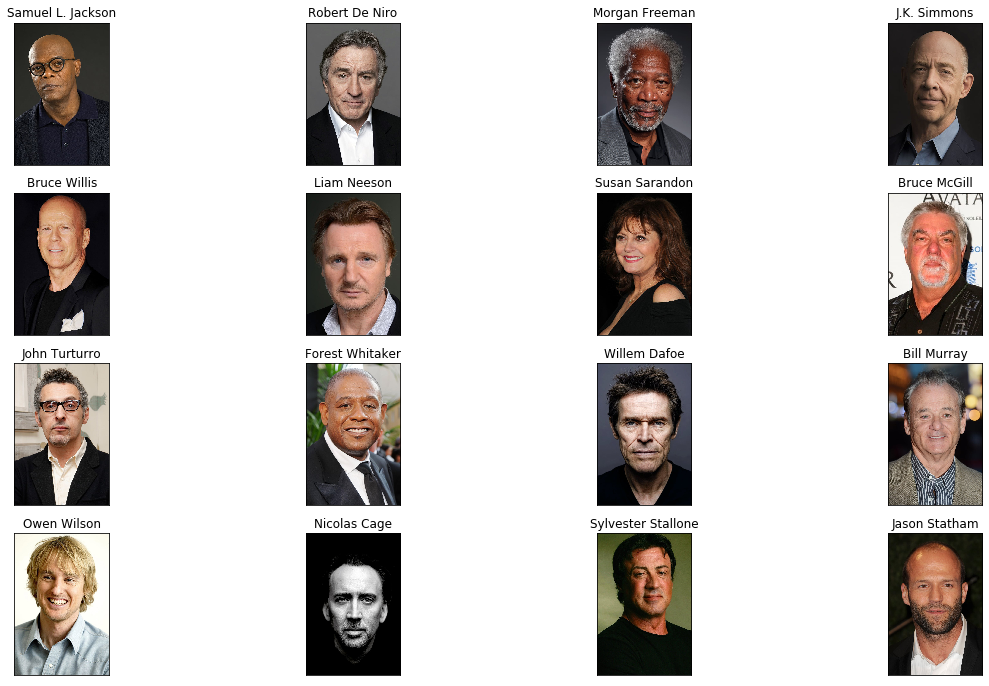

In [41]:



list_of_cast_names_url = list(train_set['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 12))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(urlopen("https://image.tmdb.org/t/p/w600_and_h900_bestv2{}".format(p[1])))
    plt.imshow(im)
    ax.set_title('{}'.format(p[0]))

We believe thathaving a popular actor in a film has an effect on its revenue, let's count then, for each film, how many actors take part in it.

In [42]:
popular_actors = [a[0][0] for a in d]
train_set["has_popular_actor"] = list(train_set["cast"].apply(lambda x: int(sum([int(i["name"] in popular_actors) for i in x] if x != {} else []) > 0)))

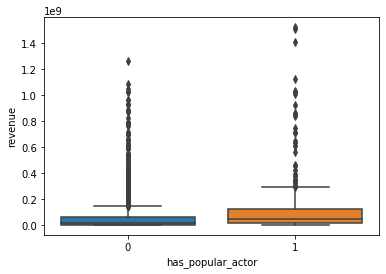

In [43]:
sns.boxplot(x='has_popular_actor', y='revenue', data=train_set)


Our hypothesis regarding having a popular actor in a film is quite clear from this box plot.
before adding the same feature to the test set, let's check if specific actors have more/less influence than others.


In [44]:

medians = {}
means = {}
for g in popular_actors:
    f = 'cast_name_' + g
    train_set[f] = train_set["cast"].apply(lambda x: 1 if g in str(x) else 0)
    medians[g] = median(list(train_set.loc[train_set[f] > 0]["revenue"]))
    means[g] = mean(list(train_set.loc[train_set[f] > 0]["revenue"]))
medians["no_famous_actor"] = median(list(train_set.loc[train_set["has_popular_actor"] == 0]["revenue"]))
means["no_famous_actor"] = mean(list(train_set.loc[train_set["has_popular_actor"] == 0]["revenue"]))


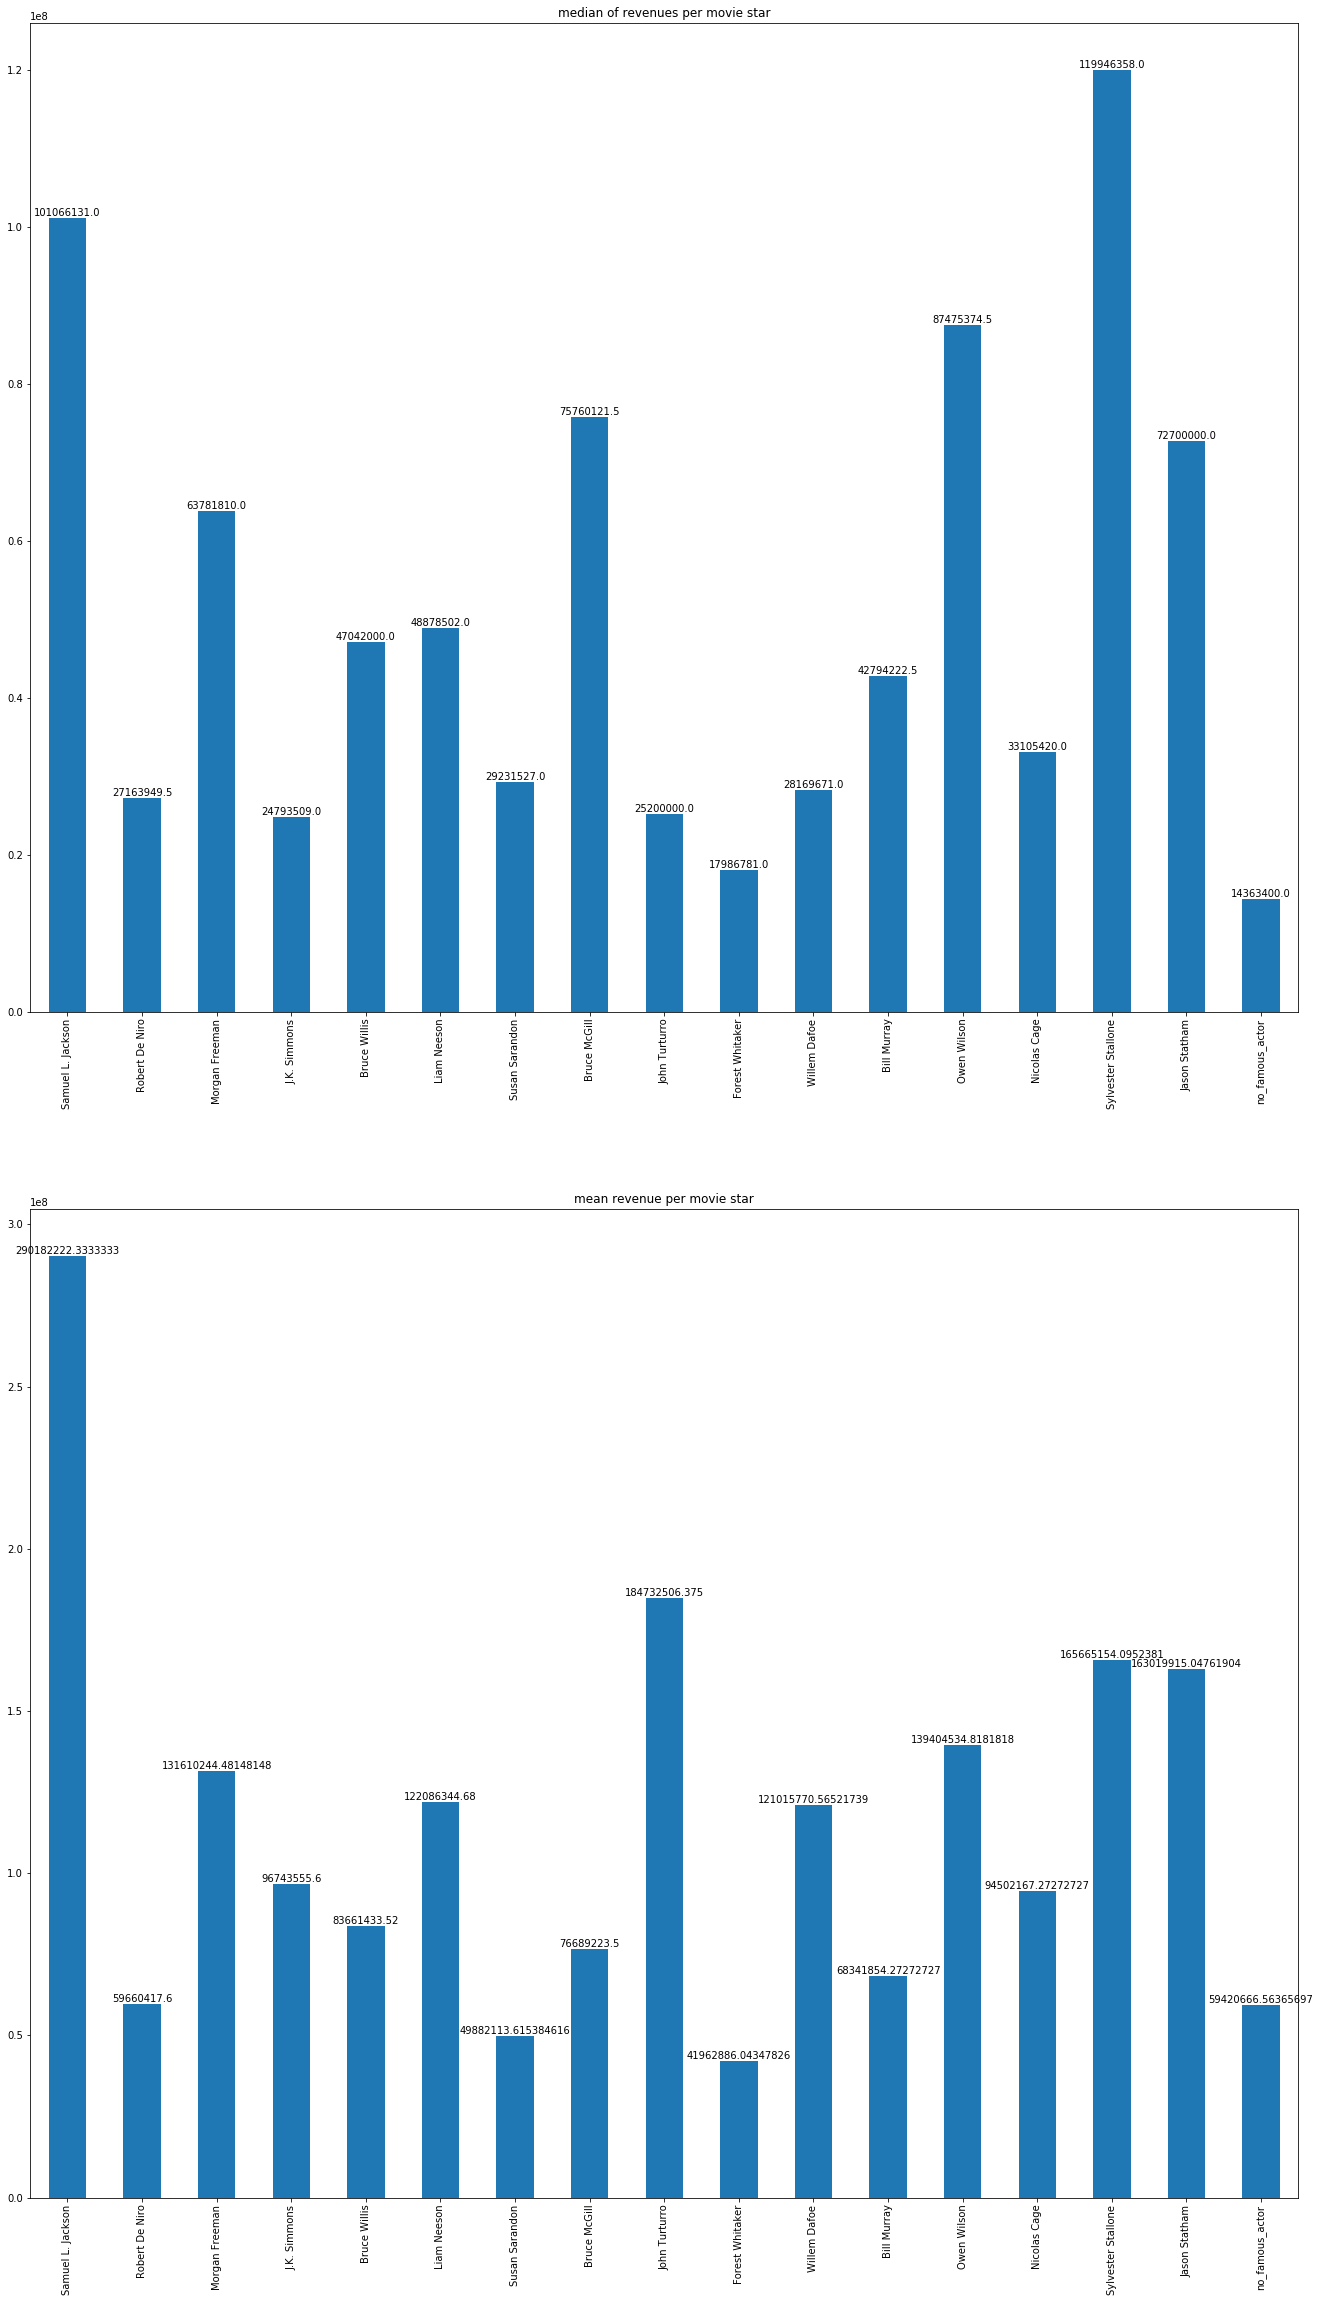

In [45]:
def bar_plot(l):
    x_labels = l.keys()
    y_labels = pd.Series(list(l.values()))
    y_labels = y_labels.astype(float)
    ax = y_labels.plot(kind='bar')
    ax.set_xticklabels(x_labels)

    rects = ax.patches

    for rect, label in zip(rects, y_labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.figure(figsize=(50, 40))
plt.subplot(2, 2, 1)
plt.title('median of revenues per movie star')
bar_plot(medians)
plt.subplot(2,2,3)
plt.title('mean revenue per movie star')
bar_plot(means)

We can se that not only does having a famous actor affect the revenue of the film, but also which actor. It is unfair to declare that movies with Samuel L. Jackson make the same revenue as movies with Forest Whitaker or Nicolas Cage. Let's add then a feature for each of these stars.

In [46]:
for g in popular_actors:
    f = 'cast_name_' + g
    test_set[f] = test_set["cast"].apply(lambda x: 1 if g in str(x) else 0)
train_set.drop(['has_popular_actor'], axis=1, inplace=True)


Moving on to do the same thing for the characters in the films:

In [47]:
list_of_cast_chars = list(train_set['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_chars for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

It is somewhat amusing that the mot two popular characters are "Himself" and "Herself", where the male version is about 4X more popular.

In [48]:
popular_chars = [m[0] for m in Counter([i for j in list_of_cast_chars for i in j]).most_common(15)]
for g in popular_chars:
    if g == '':
        continue
    train_set['cast_character_' + g] = train_set['cast'].apply(lambda x: 1 if g in str(x) else 0)
    test_set['cast_character_' + g] = test_set['cast'].apply(lambda x: 1 if g in str(x) else 0)

and finaly, the number of cast members in the film, and maybe the percentage of males/females.


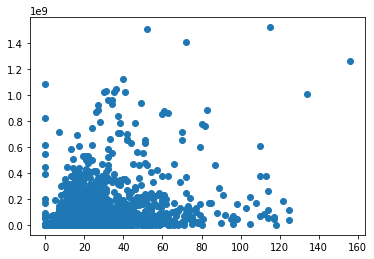

In [49]:
train_set['total_cast_members'] = train_set['cast'].apply(lambda x: len(x) if x != {} else 0)
plt.scatter(train_set['total_cast_members'], train_set['revenue'])

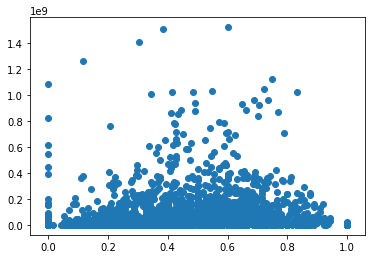

In [50]:
train_set["cast_male_percentage"] = train_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
plt.scatter(train_set['cast_male_percentage'], train_set['revenue'])

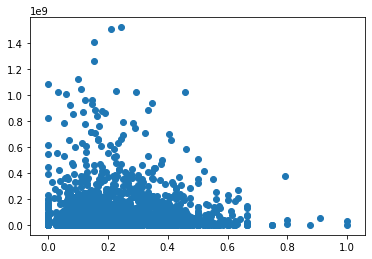

In [51]:
train_set["cast_female_percentage"] = train_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
plt.scatter(train_set['cast_female_percentage'], train_set['revenue'])

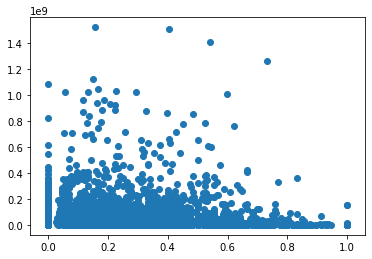

In [52]:
train_set["cast_unspecified_percentage"] = train_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))
plt.scatter(train_set['cast_unspecified_percentage'], train_set['revenue'])

There's quite a big difference between the graph describing the female actors percentage vs revenue and the one describing male percentage vs revenue. Gender equality does not apply in the movie industry at all...
Let's add these features to the test set, and remove the old "cast" feature.

In [53]:
test_set['total_cast_members'] = test_set['cast'].apply(lambda x: len(x) if x != {} else 0)
test_set["cast_male_percentage"] = test_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
test_set["cast_female_percentage"] = test_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
test_set["cast_unspecified_percentage"] = test_set['cast'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))

train_set.drop(['cast'], axis=1, inplace=True)
test_set.drop(['cast'], axis=1, inplace=True)
train_set

id    budget                           homepage    imdb_id  \
0        1  14000000                                NaN  tt2637294   
1        2  40000000                                NaN  tt0368933   
2        3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3        4   1200000         http://kahaanithefilm.com/  tt1821480   
4        5         0                                NaN  tt1380152   
...    ...       ...                                ...        ...   
2995  2996         0                                NaN  tt0109403   
2996  2997         0                                NaN  tt2364975   
2997  2998  65000000                                NaN  tt0116908   
2998  2999  42000000     http://www.alongcamepolly.com/  tt0343135   
2999  3000  35000000   http://www.abductionthefilm.com/  tt1600195   

     original_language                            original_title  \
0                   en                    Hot Tub Time Machine 2   
1                   en  The Princess Diaries 2: Royal Engagement   
2                   en                                  Whiplash   
3                   hi                                   Kahaani   
4                   ko                                      마린보이   
...                ...                                       ...   
2995                en                                   Chasers   
2996                sv                               Vi är bäst!   
2997                en                   The Long Kiss Goodnight   
2998                en                          Along Came Polly   
2999                en                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1     /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2     /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3     /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4     /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   
...                                ...   
2995  /j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg   
2996  /sS01LSy6KDrCZAhtkO18UdnWFT1.jpg   
2997  /4MENR8x6mYqnZvp2hGjSaPJz64J.jpg   
2998  /nIY4kvJTTnxoBR0wycrXng5MOYs.jpg   
2999  /cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg   

                                   production_companies  \
0     [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1           [{'name': 'Walt Disney Pictures', 'id': 2}]   
2     [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                    {}   
4                                                    {}   
...                                                 ...   
2995  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   
2996  [{'name': 'Memfis Film', 'id': 321}, {'name': ...   
2997  [{'name': 'New Line Cinema', 'id': 12}, {'name...   
2998  [{'name': 'Jersey Films', 'id': 216}, {'name':...   
2999  [{'name': 'Lions Gate Films', 'id': 35}, {'nam...   

                                   production_countries release_date  runtime  \
0     [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1     [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2     [{'iso_3166_1': 'US', 'name': 'Uni

### Crew:
Let's check what useful info we can get from this feature:


In [54]:
train_set["crew"][0]

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed2d925141720c001128',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Characters',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed3d92514166c1004a5d',
  'department': 'Production',
  'gender': 2,
  'id': 57822,
  'job': 'Producer',
  'name': 'Andrew Panay',
  'profile_path': None},
 {'credit_id': '5524ed4bc3a3687df3000dd2',
  'department': 'Production',
  'gender': 0,
  'id': 1451395,
  'job': 'Associate Producer',
  'name': 'Adam Blum',
  'profile_path': None},
 {'credit_id': '5524ed5a925141720c00112c',
  'department': 'Production',
  'gender': 2,
  'id': 52997,
  'job': 'Executive Producer',
  'name': 'Rob Corddry',
  'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'},
 {'credit_id': '5524ed85c3a3687e0e000f56',
  'department': 'Production',
  'gender': 0,
  'id': 62807,
  'job': 'Executive Producer',
  'name': 'Ben Ormand',
  'profile_path': None},
 {'credit_id': '5524ed9fc3a3687e0e000f59',
  'department': 'Sound',
  'gender': 2,
  'id': 23486,
  'job': 'Original Music Composer',
  'name': 'Christophe Beck',
  'profile_path': '/2fnJUmCk6IEpVIptpYaUk31epHx.jpg'},
 {'credit_id': '5524eda6c3a3687e03000d28',
  'department': 'Camera',
  'gender': 2,
  'id': 6117,
  'job': 'Director of Photography',
  'name': 'Declan Quinn',
  'profile_path': None},
 {'credit_id': '5524edb4925141720c00113d',
  'department': 'Editing',
  'gender': 0,
  'id': 1451396,
  'job': 'Editor',
  'name': 'Jamie Gross',
  'profile_path': None},
 {'credit_id': '5524edc1925141727600102e',
  'department': 'Production',
  'gender': 0,
  'id': 22219,
  'job': 'Casting',
  'name': 'Susie Farris',
  'profile_path': None},
 {'credit_id': '5524edd192514171cb008257',
  'department': 'Art',
  'gender': 0,
  'id': 1002643,
  'job': 'Production Design',
  'name': 'Ryan Berg',
  'profile_path': None},
 {'credit_id': '555ad9be9251411e5b00d485',
  'department': 'Production',
  'gender': 2,
  'id': 57431,
  'job': 'Executive Producer',
  'name': 'Matt Moore',
  'profile_path': None},
 {'credit_id': '5677e93bc3a36816890087dc',
  'department': 'Directing',
  'gender': 0,
  'id': 1551818,
  'job': 'Script Supervisor',
  'name': 'Nicole Garcea',
  'profile_path': None},
 {'credit_id': '5677e96a92514179e10093d0',
  'department': 'Production',
  'gender': 0,
  'id': 1551819,
  'job': 'Production Coordinator',
  'name': 'Jason Salzman',
  'profile_path': None},
 {'credit_id': '5677e98492514179d2008cd9',
  'department': 'Costume & Make-Up',
  'gender': 0,
  'id': 1422996,
  'job': 'Costume Design',
  'name': 'Carol Cutshall',
  'profile_path': None},
 {'credit_id': '5677e9d5c3a368168e009414',
  'department': 'Art',
  'gender': 2,
  'id': 500199,
  'job': 'Set Decoration',
  'name': 'Tim Cohn',
  'profile_path': None},
 {'credit_id': '5677f89d9251417845001a61',
  'department': 'Costume & Make-Up',
  'gender': 0,
  'id': 1527917,
  'job': 'Hair Department Head',
  'name': 'Voni Hinkle',
  'profile_path': None},
 {'credit_id': '5677f8b392514179dd0089fb',
  'department': 'Costume & Make-Up',
  'gender': 0,
  'id': 1431554,
  'job': 'Makeup Department Head',
  'name': 'Remi Savva',
  'profile_path': None},
 {'credit_id': '5677f8d1c3a3681689008a4b',
  'department': 'Art',
  'gender': 0,
  'id': 66495,
  'job': 'Art Direction',
  'name': 'Jason Baldwin Stewart',
  'profile_path': None},
 {'credit_id': '5677f8eec3a

We have a name, a job title, gender and department for every crew member.
Let's start with names, as usual, we will look at the most popular.

In [55]:
crew_names = list(train_set["crew"].apply(lambda x: [i["name"] for i in x] if x!= {} else []))
Counter([i for j in crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

We believe that the name of some crew member should be tied to their job title, it makes sense that a director wouldn't help much as a composer, and vice versa. We can test this theorem:

In [56]:
crew_names_jobs = list(train_set["crew"].apply(lambda x: [i["name"]+"_"+i["job"] for i in x] if x!= {} else []))
Counter([i for j in crew_names_jobs for i in j]).most_common(15)

[('Avy Kaufman_Casting', 50),
 ('Deborah Aquila_Casting', 40),
 ('James Newton Howard_Original Music Composer', 38),
 ('Jerry Goldsmith_Original Music Composer', 37),
 ('Mary Vernieu_Casting', 37),
 ('Francine Maisler_Casting', 35),
 ('Tricia Wood_Casting', 35),
 ('James Horner_Original Music Composer', 33),
 ('Kerry Barden_Casting', 32),
 ('Janet Hirshenson_Casting', 30),
 ('Jane Jenkins_Casting', 29),
 ('John Papsidera_Casting', 28),
 ('Billy Hopkins_Casting', 27),
 ('Bob Weinstein_Executive Producer', 27),
 ('Harvey Weinstein_Executive Producer', 26)]

We already see that the list of most popular names has changed.

In [57]:
popular_crew_names = [a[0] for a in Counter([i for j in crew_names for i in j]).most_common(15)]
for name in popular_crew_names:
    train_set["crew_name_"+name] = train_set["crew"].apply(lambda x: 1 if name in str(x) else 0)
    
popular_crew_names_jobs = [a[0].split("_") for a in Counter([i for j in crew_names_jobs for i in j]).most_common(15)]
for (name, job) in popular_crew_names_jobs:
    train_set["crew_name_"+name+"_job_"+job] = train_set["crew"].apply(lambda x: 1 if len([i for i in x if i["name"]==name and i["job"]==job])>0 else 0)


In [58]:
train_set

id    budget                           homepage    imdb_id  \
0        1  14000000                                NaN  tt2637294   
1        2  40000000                                NaN  tt0368933   
2        3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3        4   1200000         http://kahaanithefilm.com/  tt1821480   
4        5         0                                NaN  tt1380152   
...    ...       ...                                ...        ...   
2995  2996         0                                NaN  tt0109403   
2996  2997         0                                NaN  tt2364975   
2997  2998  65000000                                NaN  tt0116908   
2998  2999  42000000     http://www.alongcamepolly.com/  tt0343135   
2999  3000  35000000   http://www.abductionthefilm.com/  tt1600195   

     original_language                            original_title  \
0                   en                    Hot Tub Time Machine 2   
1                   en  The Princess Diaries 2: Royal Engagement   
2                   en                                  Whiplash   
3                   hi                                   Kahaani   
4                   ko                                      마린보이   
...                ...                                       ...   
2995                en                                   Chasers   
2996                sv                               Vi är bäst!   
2997                en                   The Long Kiss Goodnight   
2998                en                          Along Came Polly   
2999                en                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1     /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2     /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3     /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4     /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   
...                                ...   
2995  /j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg   
2996  /sS01LSy6KDrCZAhtkO18UdnWFT1.jpg   
2997  /4MENR8x6mYqnZvp2hGjSaPJz64J.jpg   
2998  /nIY4kvJTTnxoBR0wycrXng5MOYs.jpg   
2999  /cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg   

                                   production_companies  \
0     [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1           [{'name': 'Walt Disney Pictures', 'id': 2}]   
2     [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                    {}   
4                                                    {}   
...                                                 ...   
2995  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   
2996  [{'name': 'Memfis Film', 'id': 321}, {'name': ...   
2997  [{'name': 'New Line Cinema', 'id': 12}, {'name...   
2998  [{'name': 'Jersey Films', 'id': 216}, {'name':...   
2999  [{'name': 'Lions Gate Films', 'id': 35}, {'nam...   

                                   production_countries release_date  runtime  \
0     [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1     [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2     [{'iso_3166_1': 'US', 'name': 'Uni

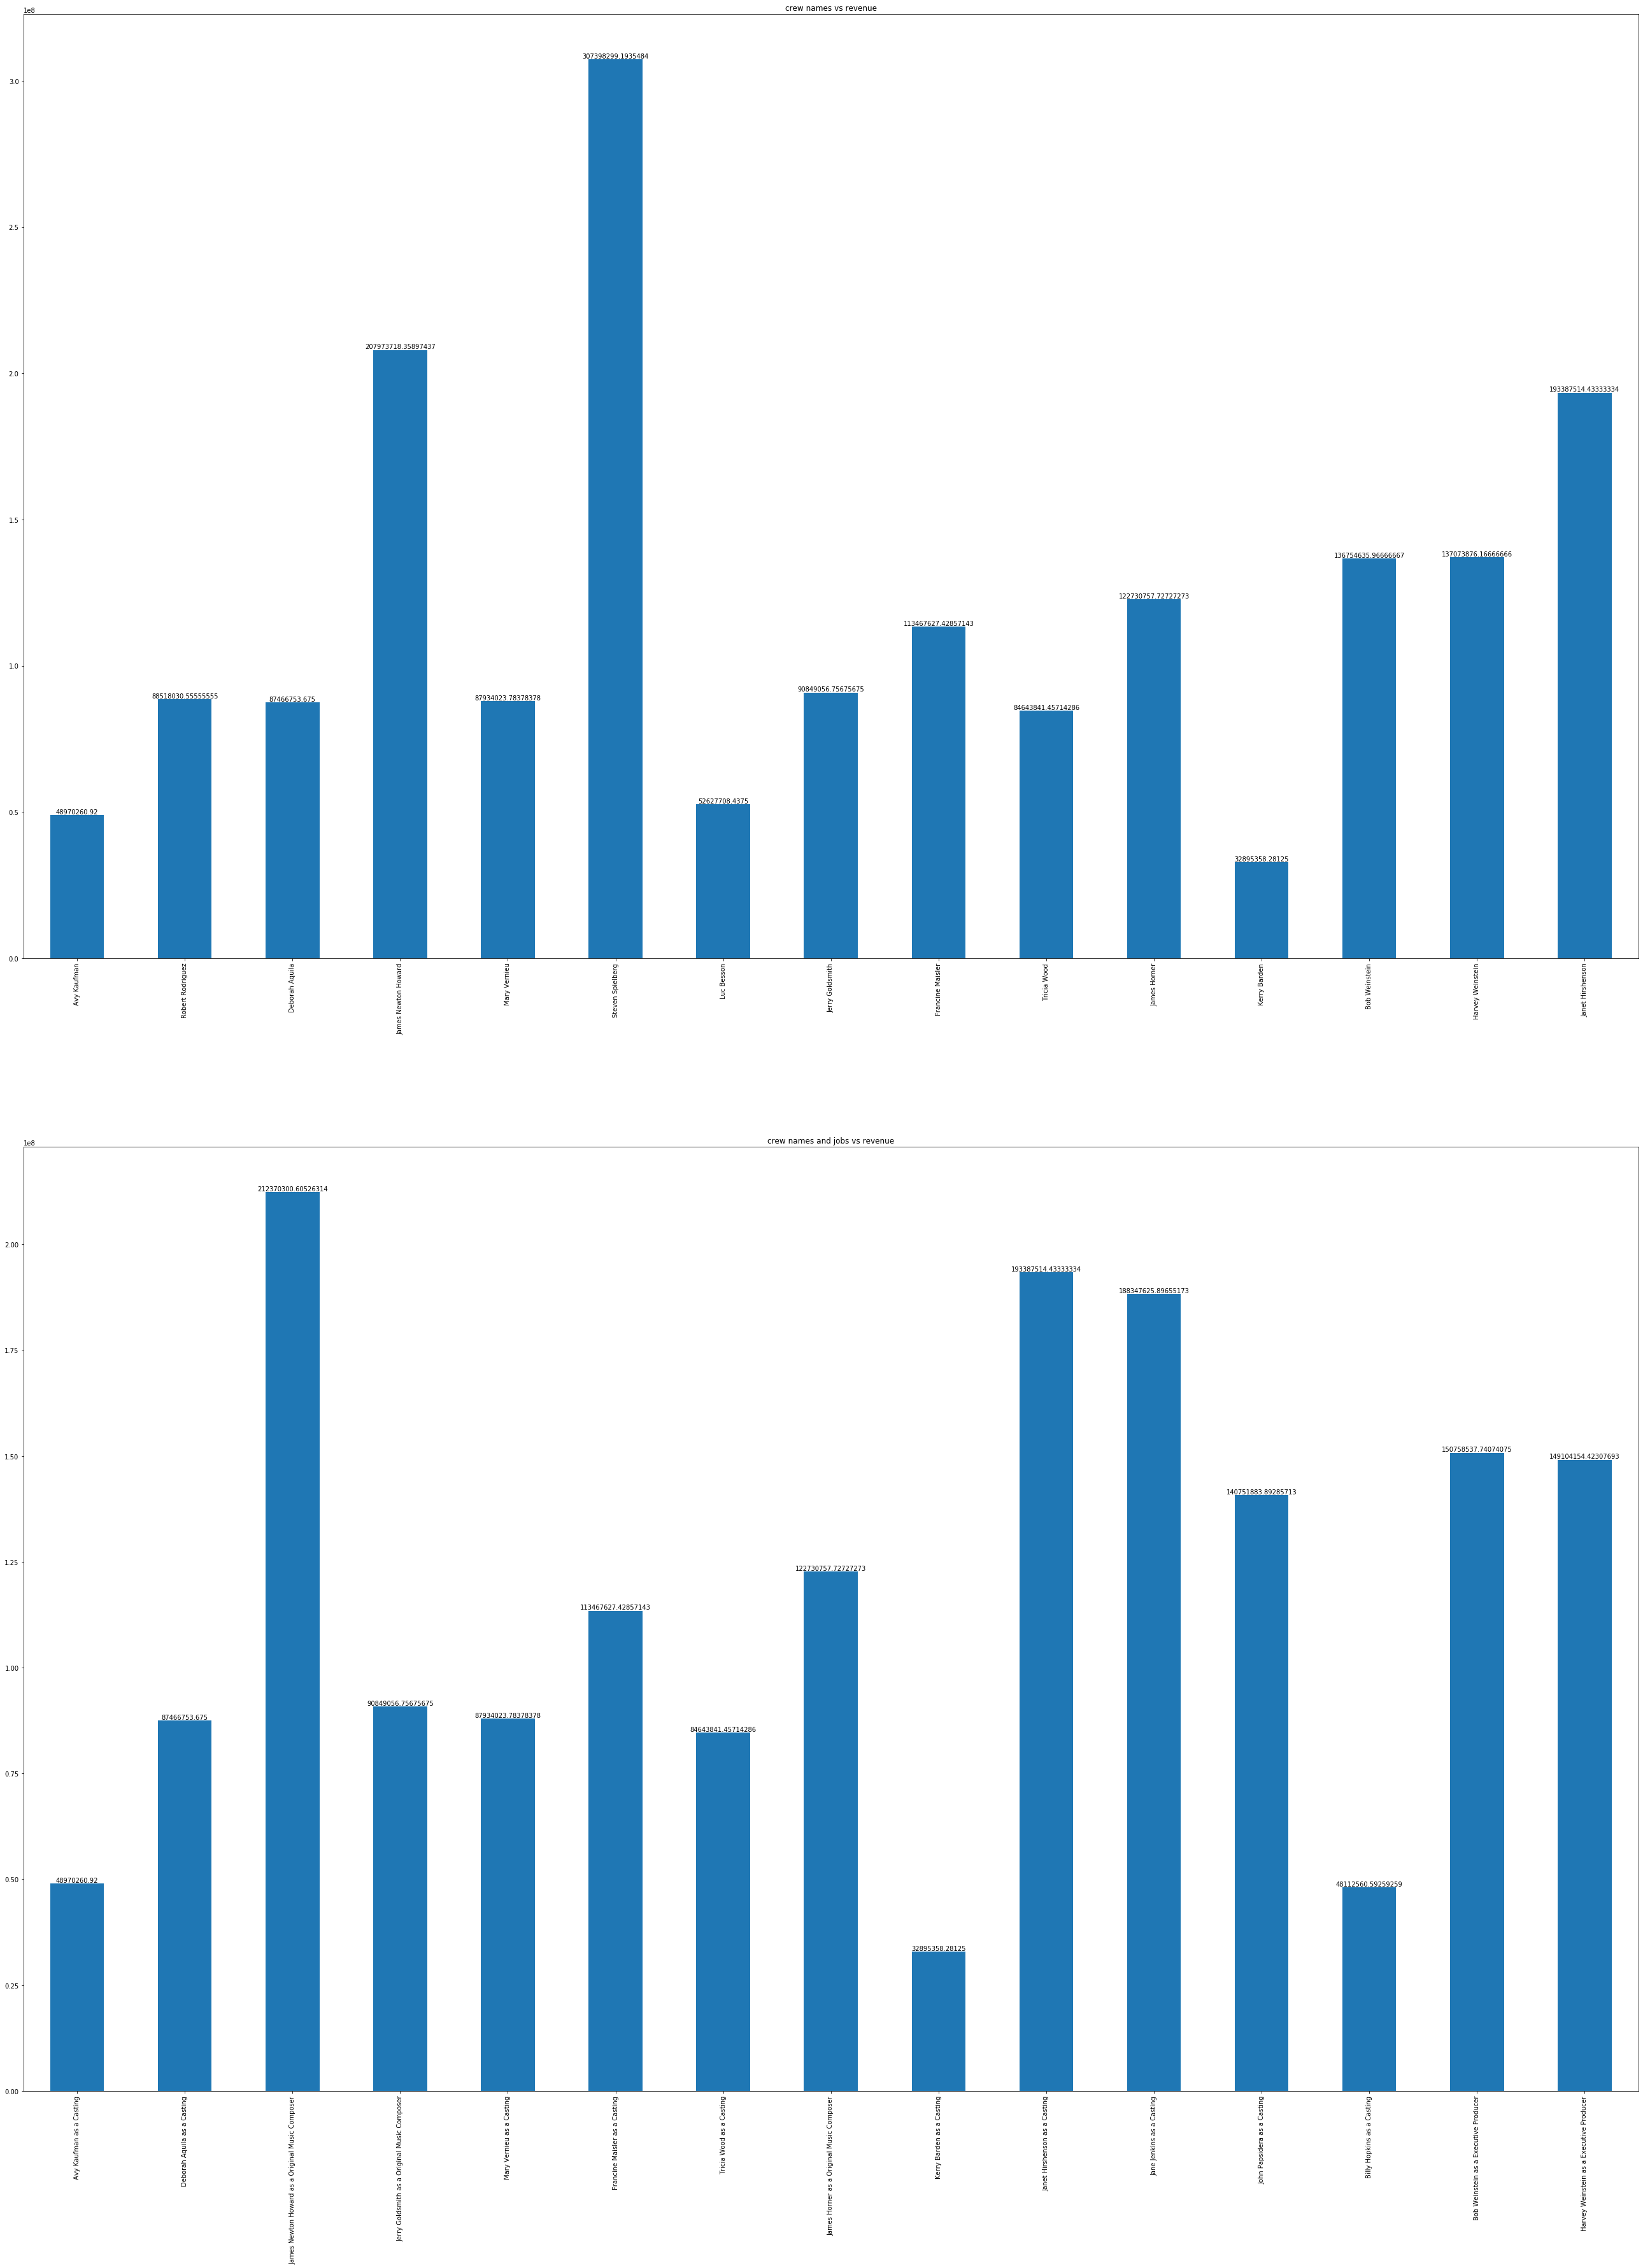

In [59]:
means_names={}
means_names_jobs = {}
for g in popular_crew_names:
    f = 'crew_name_' + g
    means_names[g] = mean(list(train_set.loc[train_set[f] > 0]["revenue"]))

for (name, job) in popular_crew_names_jobs:
    f = "crew_name_"+name+"_job_"+job
    means_names_jobs[name+" as a "+job] =  mean(list(train_set.loc[train_set[f] > 0]["revenue"]))

plt.figure(figsize=(100, 60))
plt.subplot(2, 2, 1)
plt.title("crew names vs revenue")
bar_plot(means_names)
plt.subplot(2,2,3)
plt.title("crew names and jobs vs revenue")
bar_plot(means_names_jobs)
    

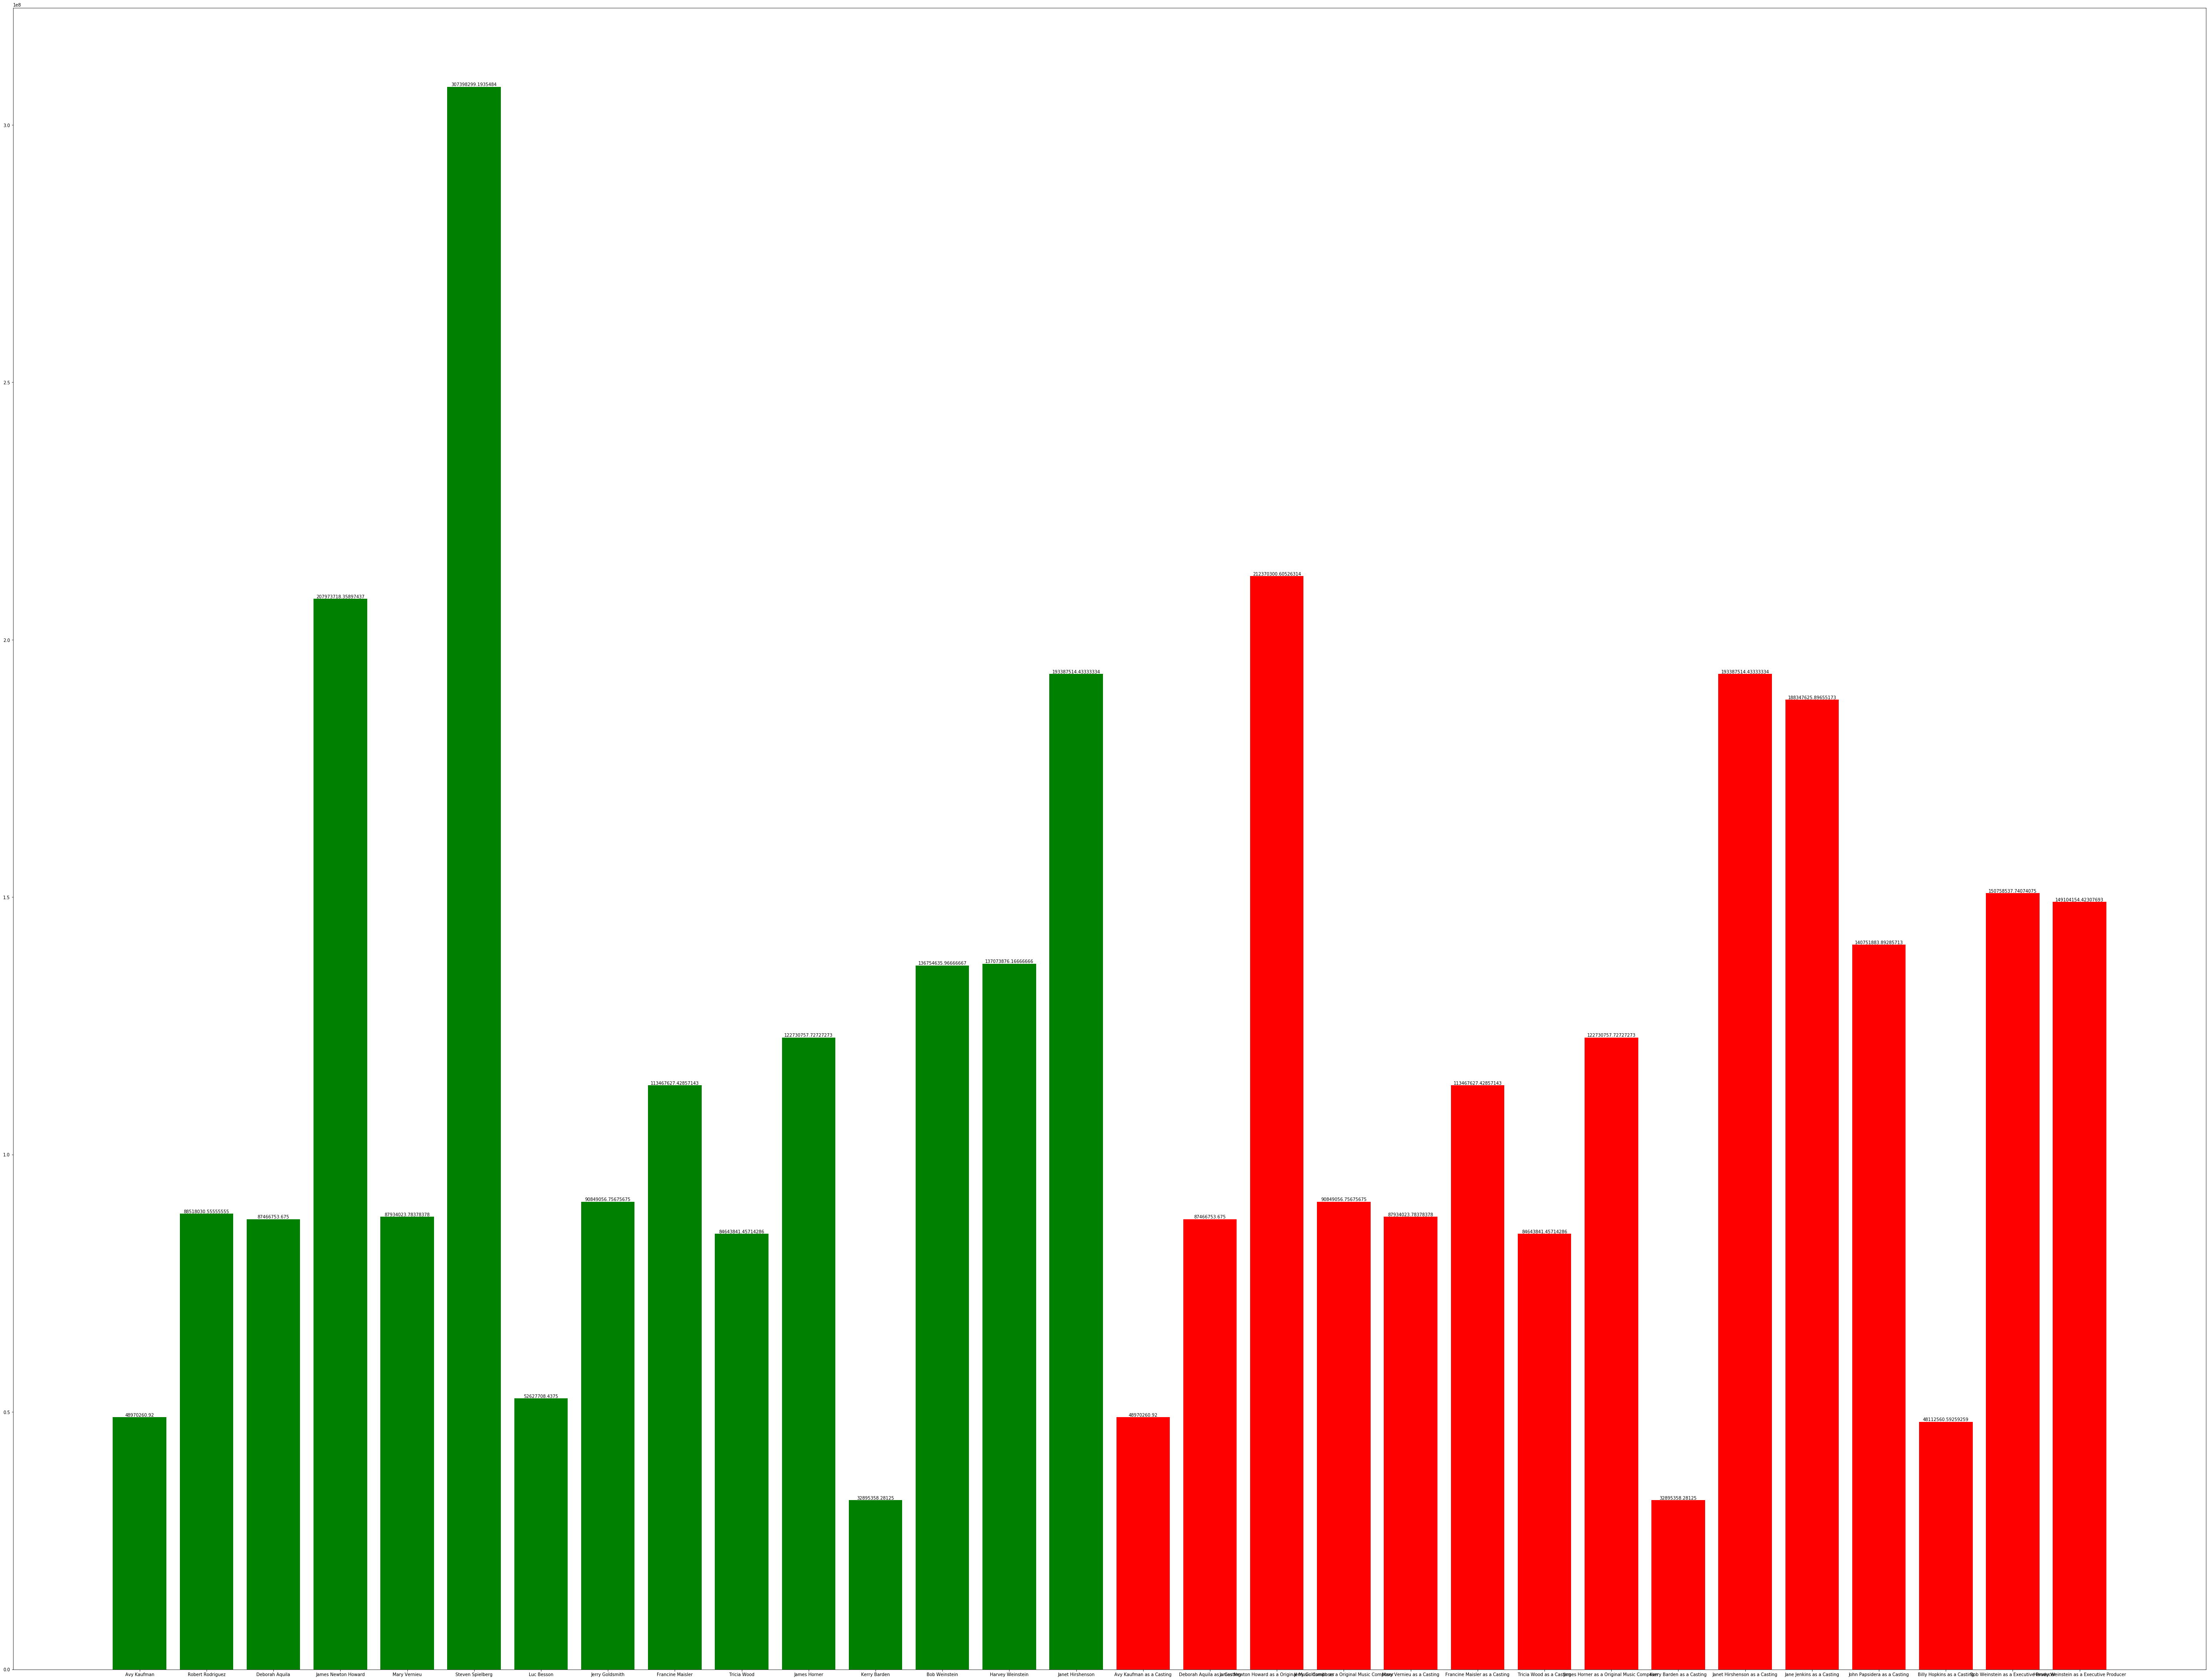

In [60]:
plt.figure(figsize=(90,70))
ax = plt.subplot(111)
ax.bar(means_names.keys(), means_names.values(), color="g")
ax.bar(means_names_jobs.keys(), means_names_jobs.values(), color="r")

rects = ax.patches

for rect, label in zip(rects,  list(means_names.values())+list(means_names_jobs.values())):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

There is a noticable difference between the graphs, that is, some popular crew members when tied to a specific job title have a higher potential to boost the movie's revenue than some other popular crew members although they are less popular. to settle for a midground, we will add those crew members that don't appear as popular by their name but by ther name and job title to the feature "crew_name_" remove the feature "crew_name_..._ job _". As for the jobs, we will look at the effect of the number of members working each of the popular jobs in every film.

In [61]:
crew_jobs = list(train_set["crew"].apply(lambda x: [i["job"] for i in x] if x!= {} else []))
popular_crew_jobs = [a[0] for a in Counter([i for j in crew_jobs for i in j]).most_common(15)]
for job in popular_crew_jobs:
    train_set["crew_job_"+job] = train_set['crew'].apply(lambda x: sum([1 for i in x if i['job'] == job]))

for (name, job) in popular_crew_names_jobs:
    train_set.drop(["crew_name_"+name+"_job_"+job], axis=1, inplace=True)
    train_set["crew_name_"+name] = train_set["crew"].apply(lambda x: 1 if name in str(x) else 0)
    
train_set

id    budget                           homepage    imdb_id  \
0        1  14000000                                NaN  tt2637294   
1        2  40000000                                NaN  tt0368933   
2        3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3        4   1200000         http://kahaanithefilm.com/  tt1821480   
4        5         0                                NaN  tt1380152   
...    ...       ...                                ...        ...   
2995  2996         0                                NaN  tt0109403   
2996  2997         0                                NaN  tt2364975   
2997  2998  65000000                                NaN  tt0116908   
2998  2999  42000000     http://www.alongcamepolly.com/  tt0343135   
2999  3000  35000000   http://www.abductionthefilm.com/  tt1600195   

     original_language                            original_title  \
0                   en                    Hot Tub Time Machine 2   
1                   en  The Princess Diaries 2: Royal Engagement   
2                   en                                  Whiplash   
3                   hi                                   Kahaani   
4                   ko                                      마린보이   
...                ...                                       ...   
2995                en                                   Chasers   
2996                sv                               Vi är bäst!   
2997                en                   The Long Kiss Goodnight   
2998                en                          Along Came Polly   
2999                en                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1     /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2     /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3     /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4     /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   
...                                ...   
2995  /j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg   
2996  /sS01LSy6KDrCZAhtkO18UdnWFT1.jpg   
2997  /4MENR8x6mYqnZvp2hGjSaPJz64J.jpg   
2998  /nIY4kvJTTnxoBR0wycrXng5MOYs.jpg   
2999  /cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg   

                                   production_companies  \
0     [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1           [{'name': 'Walt Disney Pictures', 'id': 2}]   
2     [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                    {}   
4                                                    {}   
...                                                 ...   
2995  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...   
2996  [{'name': 'Memfis Film', 'id': 321}, {'name': ...   
2997  [{'name': 'New Line Cinema', 'id': 12}, {'name...   
2998  [{'name': 'Jersey Films', 'id': 216}, {'name':...   
2999  [{'name': 'Lions Gate Films', 'id': 35}, {'nam...   

                                   production_countries release_date  runtime  \
0     [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1     [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2     [{'iso_3166_1': 'US', 'name': 'Uni

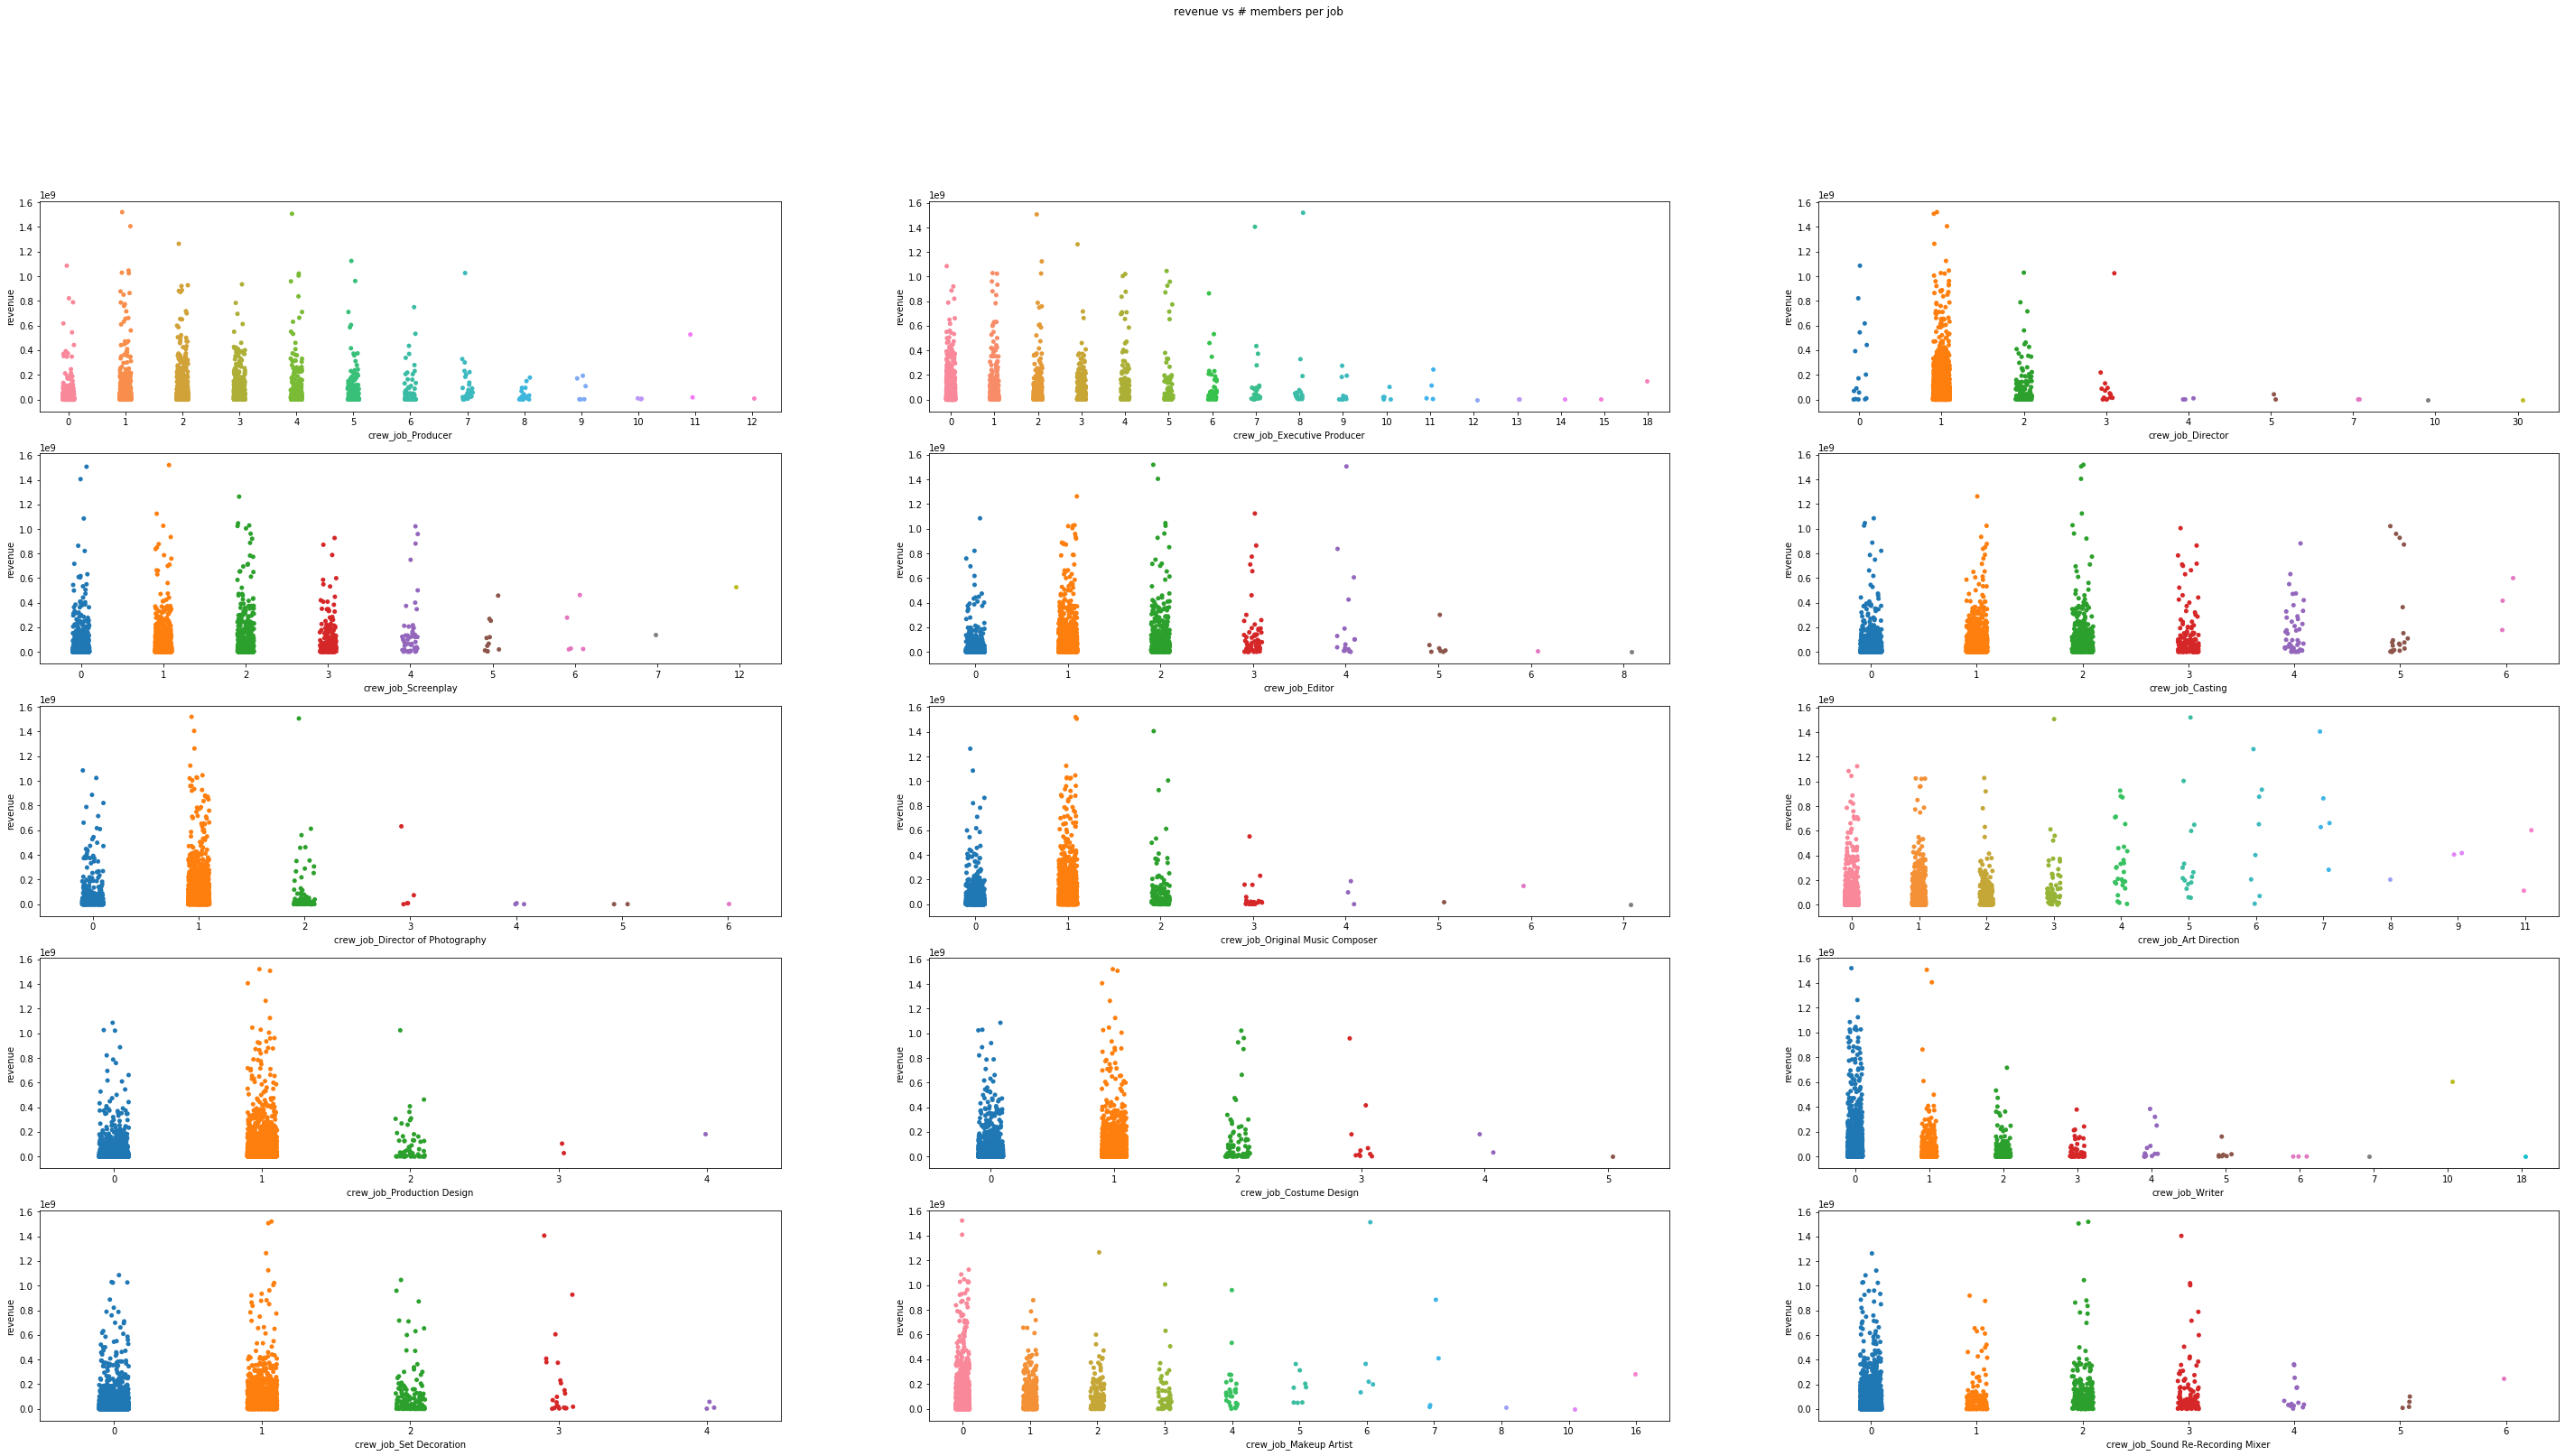

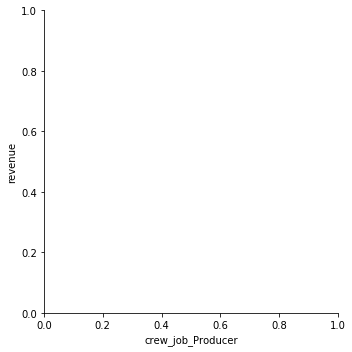

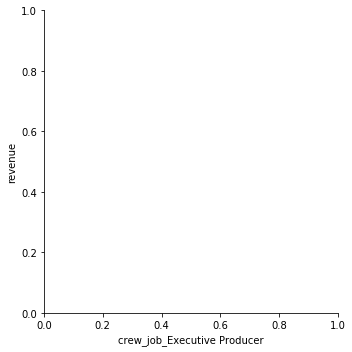

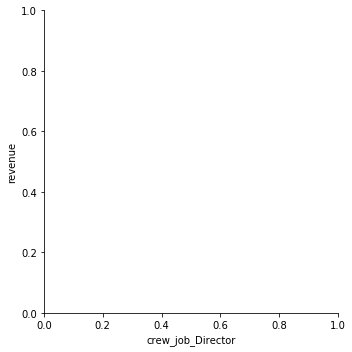

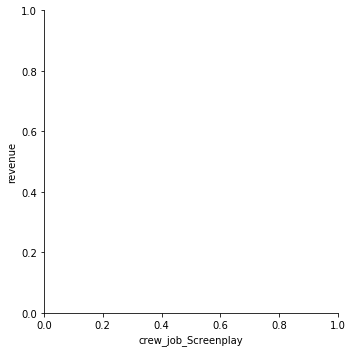

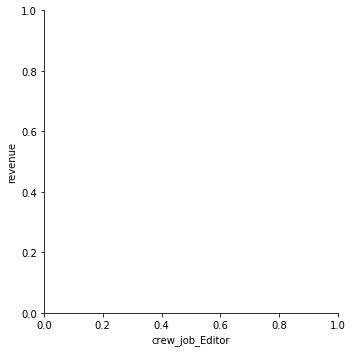

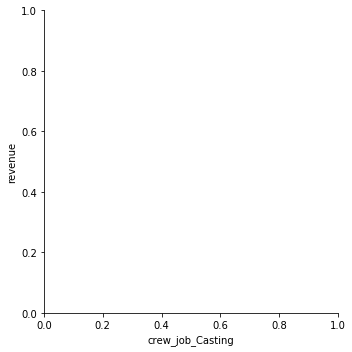

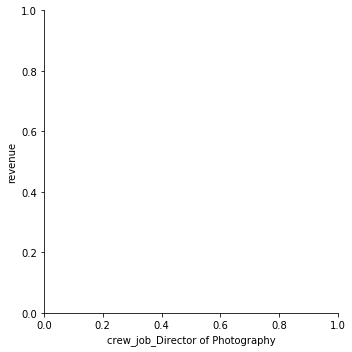

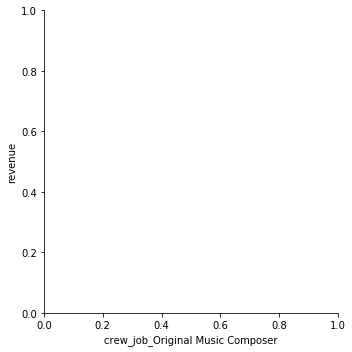

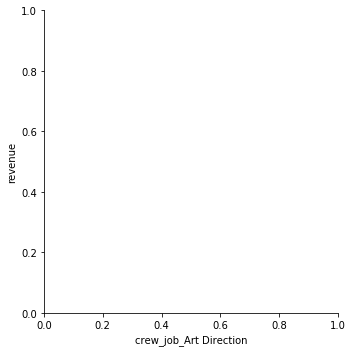

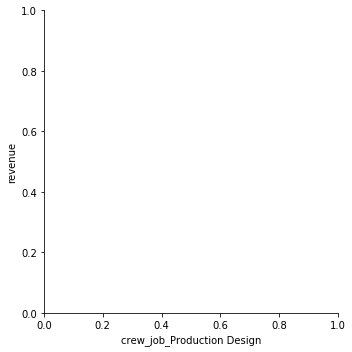

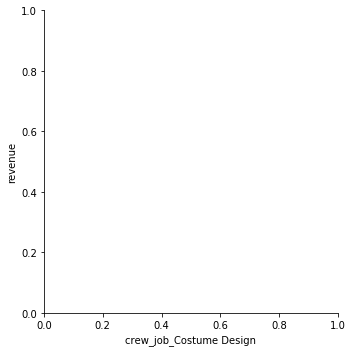

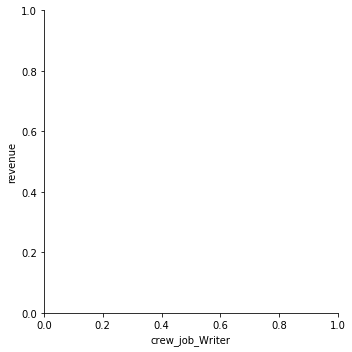

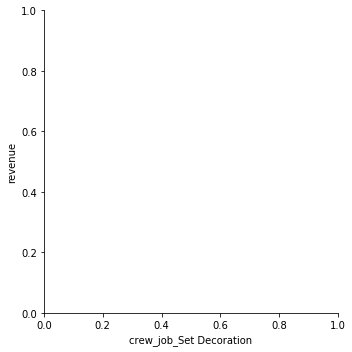

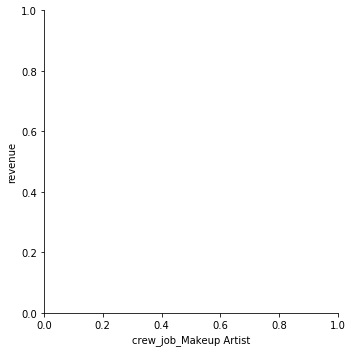

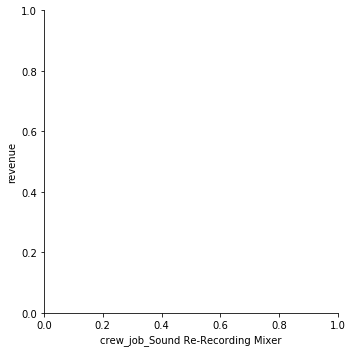

In [62]:
fig=plt.figure(figsize=(50,30))
plt.suptitle('revenue vs # members per job')
for i, e in enumerate([col for col in train_set.columns if 'crew_job' in col]):
    axis = fig.add_subplot(int(len([col for col in train_set.columns if 'crew_job' in col])/3)+1,3, i+1)
    sns.catplot(x=e, y='revenue', data=train_set, ax=axis);

These are actually very interesting graphs, we see that for some jobs, the more workers there are the better, but for other jobs it is quite the opposite!

In [63]:
[col for col in train_set.columns if 'crew_job' in col]

['crew_job_Producer',
 'crew_job_Executive Producer',
 'crew_job_Director',
 'crew_job_Screenplay',
 'crew_job_Editor',
 'crew_job_Casting',
 'crew_job_Director of Photography',
 'crew_job_Original Music Composer',
 'crew_job_Art Direction',
 'crew_job_Production Design',
 'crew_job_Costume Design',
 'crew_job_Writer',
 'crew_job_Set Decoration',
 'crew_job_Makeup Artist',
 'crew_job_Sound Re-Recording Mixer']

In [64]:
crew_departments = list(train_set['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
popular_crew_departments = [m[0] for m in Counter([i for j in crew_departments for i in j]).most_common(15)]
for dep in popular_crew_departments:
    train_set['crew_department_' + dep] = train_set['crew'].apply(lambda x: sum([1 for i in x if i['department'] == dep])) 

In [65]:
for name in popular_crew_names:
    test_set["crew_name_"+name] = test_set["crew"].apply(lambda x: 1 if name in str(x) else 0)

for job in popular_crew_jobs:
    test_set["crew_job_"+job] = test_set['crew'].apply(lambda x: sum([1 for i in x if i['job'] == job]))

for (name, job) in popular_crew_names_jobs:
    test_set["crew_name_"+name] = test_set["crew"].apply(lambda x: 1 if name in str(x) else 0)

for dep in popular_crew_departments:
    test_set['crew_department_' + dep] = test_set['crew'].apply(lambda x: sum([1 for i in x if i['department'] == dep])) 

In [66]:
train_set['total_crew_members'] = train_set['crew'].apply(lambda x: len(x) if x != {} else 0)
test_set['total_crew_members'] = test_set['crew'].apply(lambda x: len(x) if x != {} else 0)

train_set["crew_male_percentage"] = train_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
train_set["crew_female_percentage"] = train_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
train_set["crew_unspecified_percentage"] = train_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))



test_set["crew_male_percentage"] = test_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 2]))/len(x))
test_set["crew_female_percentage"] = test_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 1]))/len(x))
test_set["crew_unspecified_percentage"] = test_set['crew'].apply(lambda x: 0 if len(x)==0 else float(len([i for i in x if i["gender"] == 0]))/len(x))

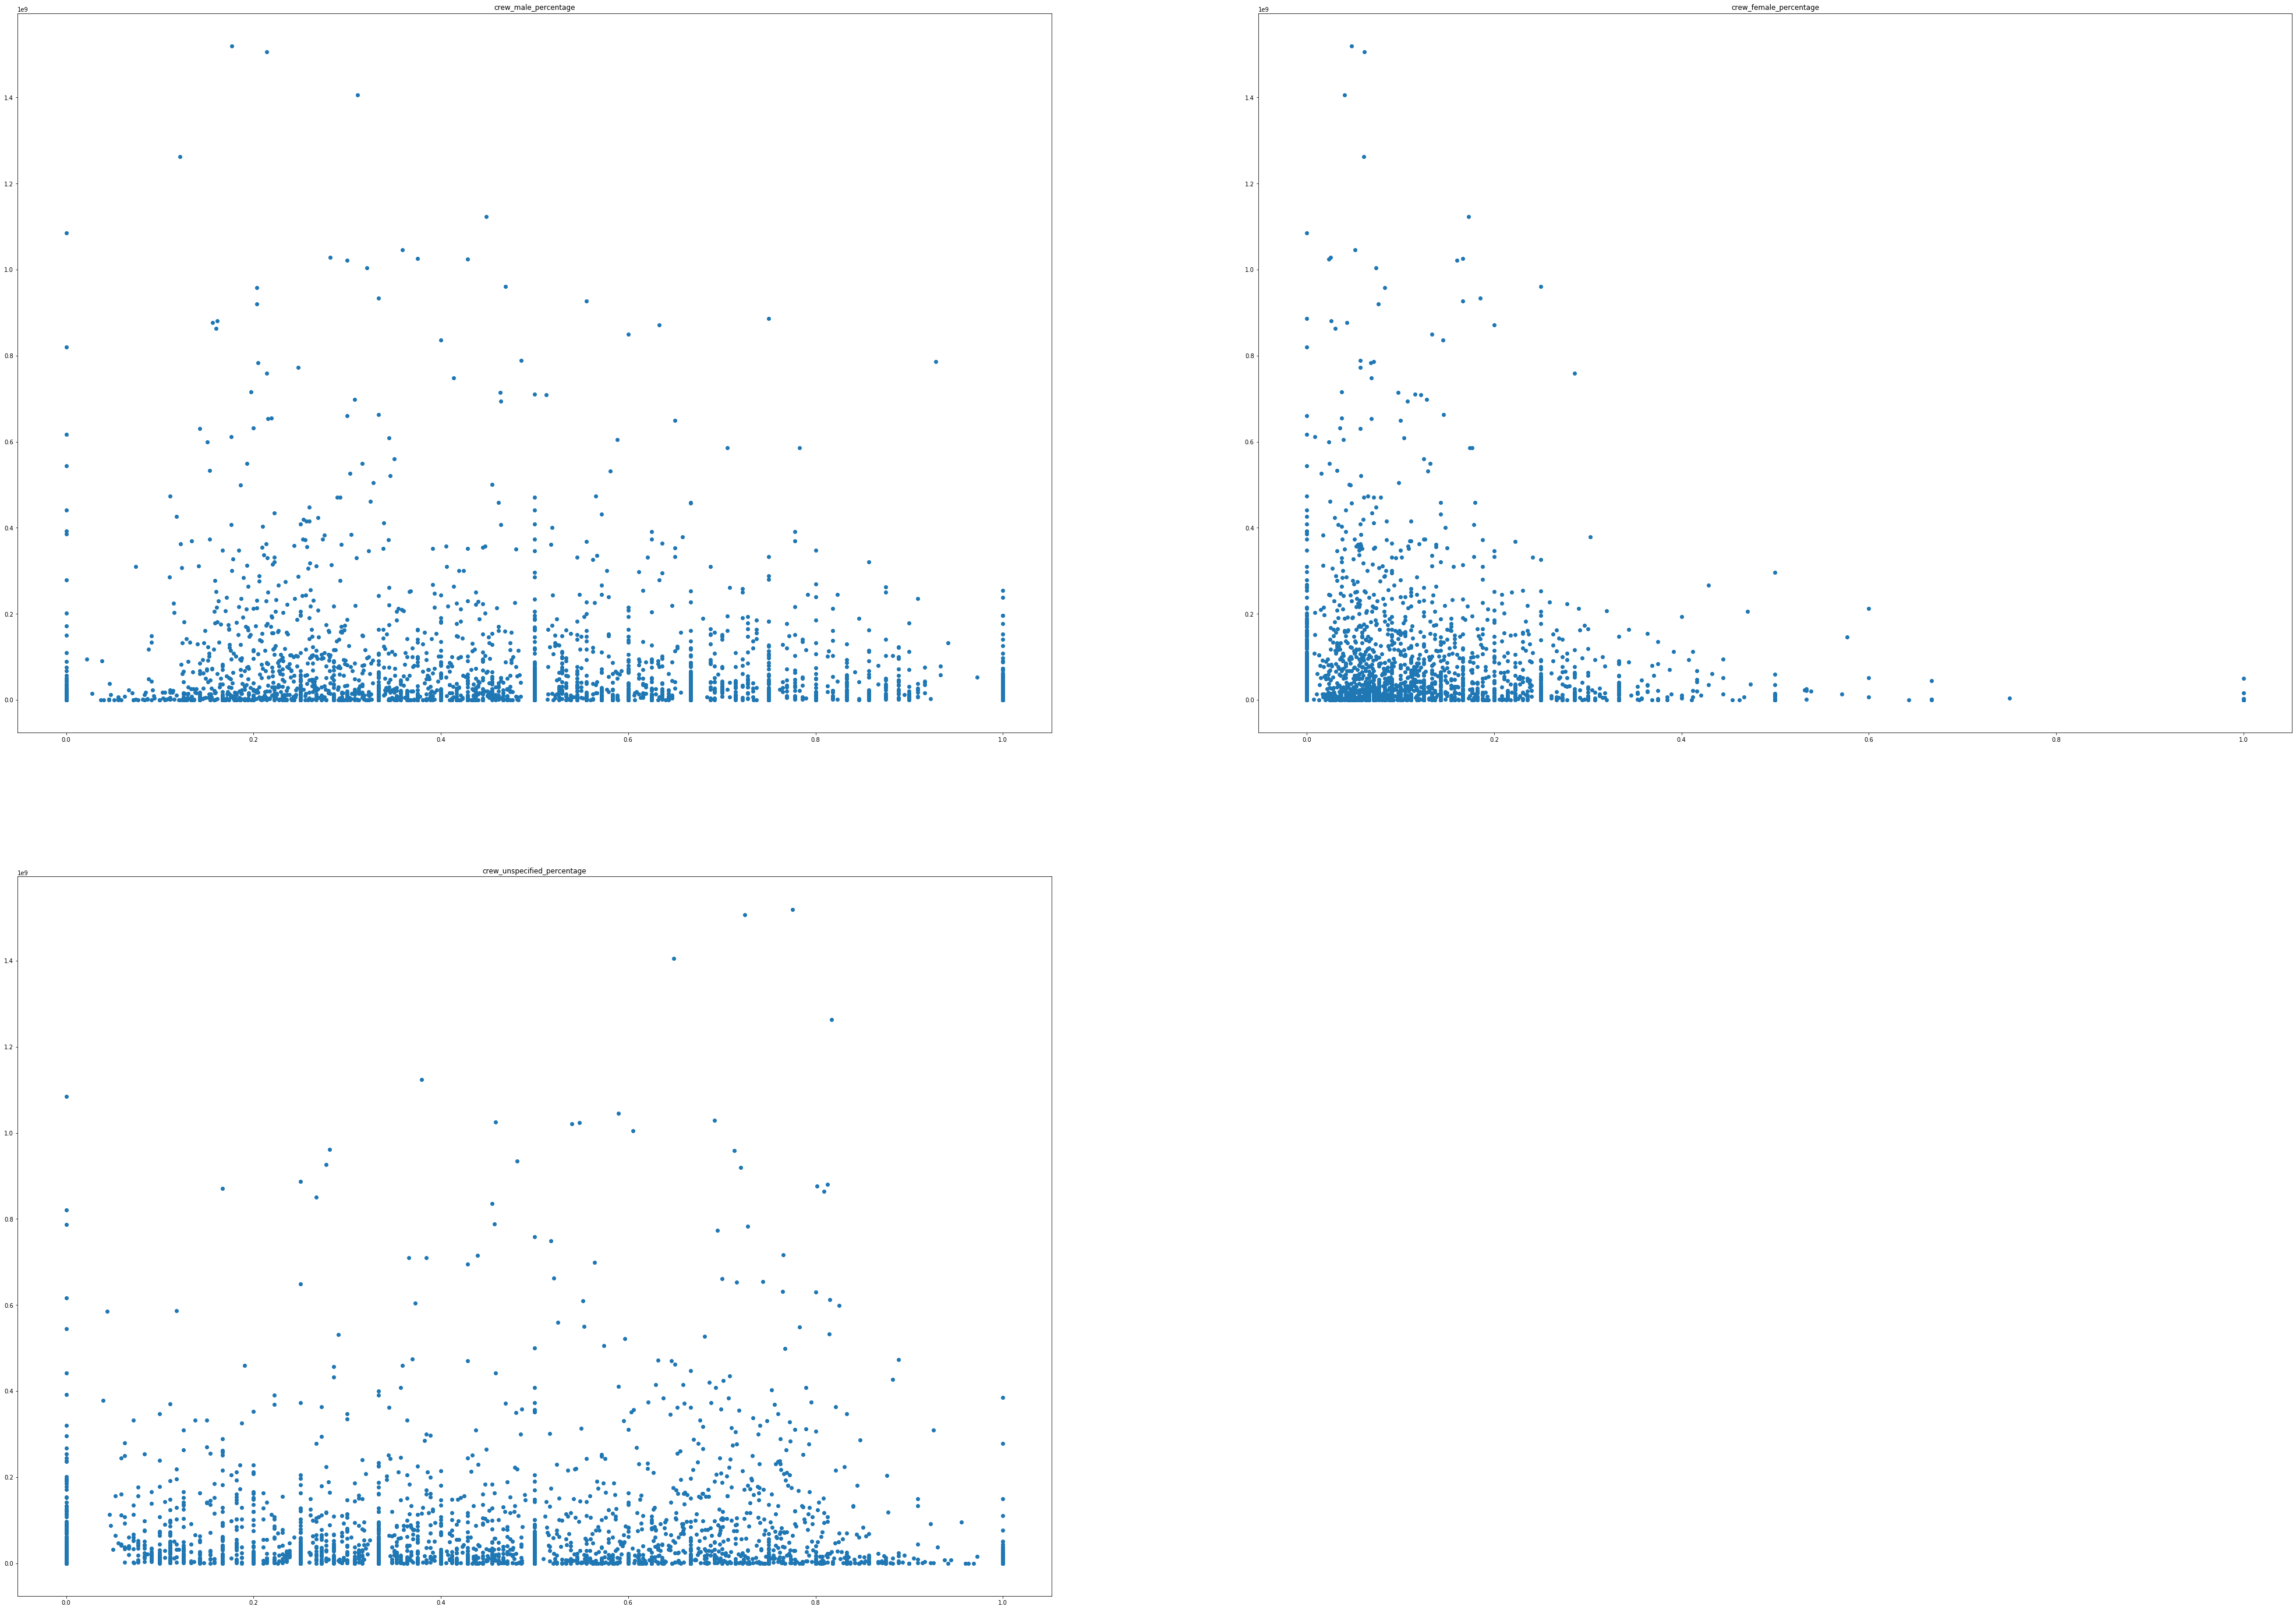

In [67]:
plt.figure(figsize=(70,50))
plt.subplot(2,2,1)
plt.title("crew_male_percentage")
plt.scatter(train_set['crew_male_percentage'], train_set['revenue'])
plt.subplot(2,2,2)
plt.title("crew_female_percentage")
plt.scatter(train_set['crew_female_percentage'], train_set['revenue'])
plt.subplot(2,2,3)
plt.title("crew_unspecified_percentage")
plt.scatter(train_set['crew_unspecified_percentage'], train_set['revenue'])

In [68]:
train_set.drop(["crew"], axis=1, inplace=True)
test_set.drop(["crew"], axis=1, inplace=True)

### Production_companies:


In [69]:
train_set["production_companies"][0]

[{'name': 'Paramount Pictures', 'id': 4},
 {'name': 'United Artists', 'id': 60},
 {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]

we are familiar with this type of features...

In [70]:
companies = list(train_set['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
popular_companies = [m[0] for m in Counter([i for j in companies for i in j]).most_common(30)]
for c in popular_companies:
    train_set["production_company_"+c] = train_set["production_companies"].apply(lambda x: 1 if c in str(x) else 0)
    test_set["production_company_"+c] = test_set["production_companies"].apply(lambda x: 1 if c in str(x) else 0)

train_set["num_production_companies"] = train_set["production_companies"].apply(lambda x: len(x))
test_set["num_production_companies"] = test_set["production_companies"].apply(lambda x: len(x))

train_set.drop(["production_companies"], axis=1, inplace=True)
test_set.drop(["production_companies"], axis=1, inplace=True)

In [71]:
train_set

id    budget                           homepage    imdb_id  \
0        1  14000000                                NaN  tt2637294   
1        2  40000000                                NaN  tt0368933   
2        3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3        4   1200000         http://kahaanithefilm.com/  tt1821480   
4        5         0                                NaN  tt1380152   
...    ...       ...                                ...        ...   
2995  2996         0                                NaN  tt0109403   
2996  2997         0                                NaN  tt2364975   
2997  2998  65000000                                NaN  tt0116908   
2998  2999  42000000     http://www.alongcamepolly.com/  tt0343135   
2999  3000  35000000   http://www.abductionthefilm.com/  tt1600195   

     original_language                            original_title  \
0                   en                    Hot Tub Time Machine 2   
1                   en  The Princess Diaries 2: Royal Engagement   
2                   en                                  Whiplash   
3                   hi                                   Kahaani   
4                   ko                                      마린보이   
...                ...                                       ...   
2995                en                                   Chasers   
2996                sv                               Vi är bäst!   
2997                en                   The Long Kiss Goodnight   
2998                en                          Along Came Polly   
2999                en                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1     /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2     /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3     /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4     /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   
...                                ...   
2995  /j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg   
2996  /sS01LSy6KDrCZAhtkO18UdnWFT1.jpg   
2997  /4MENR8x6mYqnZvp2hGjSaPJz64J.jpg   
2998  /nIY4kvJTTnxoBR0wycrXng5MOYs.jpg   
2999  /cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg   

                                   production_countries release_date  runtime  \
0     [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1     [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2     [{'iso_3166_1': 'US', 'name': 'United States o...     10/10/14    105.0   
3               [{'iso_3166_1': 'IN', 'name': 'India'}]       3/9/12    122.0   
4         [{'iso_3166_1': 'KR', 'name': 'South Korea'}]       2/5/09    118.0   
...                                                 ...          ...      ...   
2995  [{'iso_3166_1': 'US', 'name': 'United States o...      4/22/94    102.0   
2996  [{'iso_3166_1': 'DK', 'name': 'Denmark'}, {'is...      3/28/13    102.0   
2997  [{'iso_3166_1': 'US', 'name': 'United States o...     10/11/96    120.0   
2998  [{'iso_3166_1': 'US', 'name': 'United States o...      1/16/04     90.0   
2999  [{'iso_3166_1': 'US', 'name': 'United States o...      9/22/11    106.0   

        status     

### Production_countries:



In [72]:
train_set["production_countries"][0]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

Much of the same...

In [73]:
countries = list(train_set['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
popular_countries = [m[0] for m in Counter([i for j in countries for i in j]).most_common(30)]
for c in popular_countries:
    train_set["production_country_"+c] = train_set["production_countries"].apply(lambda x: 1 if c in str(x) else 0)
    test_set["production_country_"+c] = test_set["production_countries"].apply(lambda x: 1 if c in str(x) else 0)

train_set["num_production_countries"] = train_set["production_countries"].apply(lambda x: len(x))
test_set["num_production_countries"] = test_set["production_countries"].apply(lambda x: len(x))

train_set.drop(["production_countries"], axis=1, inplace=True)
test_set.drop(["production_countries"], axis=1, inplace=True)

In [74]:
train_set

id    budget                           homepage    imdb_id  \
0        1  14000000                                NaN  tt2637294   
1        2  40000000                                NaN  tt0368933   
2        3   3300000  http://sonyclassics.com/whiplash/  tt2582802   
3        4   1200000         http://kahaanithefilm.com/  tt1821480   
4        5         0                                NaN  tt1380152   
...    ...       ...                                ...        ...   
2995  2996         0                                NaN  tt0109403   
2996  2997         0                                NaN  tt2364975   
2997  2998  65000000                                NaN  tt0116908   
2998  2999  42000000     http://www.alongcamepolly.com/  tt0343135   
2999  3000  35000000   http://www.abductionthefilm.com/  tt1600195   

     original_language                            original_title  \
0                   en                    Hot Tub Time Machine 2   
1                   en  The Princess Diaries 2: Royal Engagement   
2                   en                                  Whiplash   
3                   hi                                   Kahaani   
4                   ko                                      마린보이   
...                ...                                       ...   
2995                en                                   Chasers   
2996                sv                               Vi är bäst!   
2997                en                   The Long Kiss Goodnight   
2998                en                          Along Came Polly   
2999                en                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path release_date  runtime    status  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1     /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2     /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3     /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4     /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   
...                                ...          ...      ...       ...   
2995  /j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg      4/22/94    102.0  Released   
2996  /sS01LSy6KDrCZAhtkO18UdnWFT1.jpg      3/28/13    102.0  Released   
2997  /4MENR8x6mYqnZvp2hGjSaPJz64J.jpg     10/11/96    120.0  Released   
2998  /nIY4kvJTTnxoBR0wycrXng5MOYs.jpg      1/16/04     90.0  Released   
2999  /cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg      9/22/11    106.0  Released   

                                                tagline  \
0     The Laws of Space and Time are About to be Vio...   
1     It can take a lifetime to find true love; she'...   
2       The road to greatness can take you to the edge.   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
2995  It was supposed to be a routine prisoner trans...   
2996                                                NaN   
2997               What's forgotten is not always gone.   
2998  For the most

### Homepage:

In [75]:
train_set["homepage"]

0                                     NaN
1                                     NaN
2       http://sonyclassics.com/whiplash/
3              http://kahaanithefilm.com/
4                                     NaN
                      ...                
2995                                  NaN
2996                                  NaN
2997                                  NaN
2998       http://www.alongcamepolly.com/
2999     http://www.abductionthefilm.com/
Name: homepage, Length: 3000, dtype: object

In [76]:
train_set['has_homepage'] = 0
train_set.loc[train_set['homepage'].isnull() == False, 'has_homepage'] = 1
test_set['has_homepage'] = 0
test_set.loc[test_set['homepage'].isnull() == False, 'has_homepage'] = 1


In [77]:
train_set.drop(["homepage"], axis=1, inplace=True)
test_set.drop(["homepage"], axis=1, inplace=True)
train_set

id    budget    imdb_id original_language  \
0        1  14000000  tt2637294                en   
1        2  40000000  tt0368933                en   
2        3   3300000  tt2582802                en   
3        4   1200000  tt1821480                hi   
4        5         0  tt1380152                ko   
...    ...       ...        ...               ...   
2995  2996         0  tt0109403                en   
2996  2997         0  tt2364975                sv   
2997  2998  65000000  tt0116908                en   
2998  2999  42000000  tt0343135                en   
2999  3000  35000000  tt1600195                en   

                                original_title  \
0                       Hot Tub Time Machine 2   
1     The Princess Diaries 2: Royal Engagement   
2                                     Whiplash   
3                                      Kahaani   
4                                         마린보이   
...                                        ...   
2995                                   Chasers   
2996                               Vi är bäst!   
2997                   The Long Kiss Goodnight   
2998                          Along Came Polly   
2999                                 Abduction   

                                               overview  popularity  \
0     When Lou, who has become the "father of the In...    6.575393   
1     Mia Thermopolis is now a college graduate and ...    8.248895   
2     Under the direction of a ruthless instructor, ...   64.299990   
3     Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4     Marine Boy is the story of a former national s...    1.148070   
...                                                 ...         ...   
2995  Military men Rock Reilly and Eddie Devane are ...    9.853270   
2996  Three girls in 1980s Stockholm decide to form ...    3.727996   
2997  Samantha Caine, suburban homemaker, is the ide...   14.482345   
2998  Reuben Feffer is a guy who's spent his entire ...   15.725542   
2999  A young man sets out to uncover the truth abou...   10.512109   

                           poster_path release_date  runtime    status  \
0     /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg      2/20/15     93.0  Released   
1     /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg       8/6/04    113.0  Released   
2     /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg     10/10/14    105.0  Released   
3     /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4     /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   
...                                ...          ...      ...       ...   
2995  /j8Q7pQ27hvH54wpxJzIuQgQCdro.jpg      4/22/94    102.0  Released   
2996  /sS01LSy6KDrCZAhtkO18UdnWFT1.jpg      3/28/13    102.0  Released   
2997  /4MENR8x6mYqnZvp2hGjSaPJz64J.jpg     10/11/96    120.0  Released   
2998  /nIY4kvJTTnxoBR0wycrXng5MOYs.jpg      1/16/04     90.0  Released   
2999  /cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg      9/22/11    106.0  Released   

                                                tagline  \
0     The Laws of Space and Time are About to be Vio...   
1     It can take a lifetime to find true love; she'...   
2       The road to greatness can take you to the edge.   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
2995  It was supposed to be a routine prisoner trans...   
2996                                                NaN   
2997               What's forgotten is not always gone.   
2998  For the most cautious man on Earth, life is ab...   
2999          They stole his life. He's taking it back.   

                                         title    revenue  genre_name_Comedy  \
0                       Hot Tub Time Machine 2   12314651                  1   
1     The Princess Diaries 2: Royal Engagement   95149435                  1   
2                                     Whiplash   13092000                  0   

### Release_date:

In [78]:
train_set["release_date"]

0        2/20/15
1         8/6/04
2       10/10/14
3         3/9/12
4         2/5/09
          ...   
2995     4/22/94
2996     3/28/13
2997    10/11/96
2998     1/16/04
2999     9/22/11
Name: release_date, Length: 3000, dtype: object

In [79]:
# The only nan value i found in both datasets, I looked up the the date myself.
test_set.loc[test_set['release_date'].isnull() == True, 'release_date'] = '01/05/00'

We will seperate the release date into seperate features to des ribe the day, month, year, weekday and maybe others, as suplied by the data type pd.datetime but first, we'll fix the yearsfrom two digits to 4:

In [80]:
def fix_year(date):
    year = date.split("/")[2]
    if year.startswith("0") or year.startswith("1"):
        year = "20"+year
    else: 
        year = "19"+year
        
    return date[:-2]+year

train_set["release_date"]= [fix_year(d) for d in train_set["release_date"]]
test_set["release_date"]= [fix_year(d) for d in test_set["release_date"]]

In [81]:
test_set["release_date"]

0       7/14/2007
1       5/19/1958
2       5/23/1997
3        9/4/2010
4       2/11/2005
          ...    
4393     8/3/2001
4394    8/20/2004
4395    12/8/1982
4396     2/4/2015
4397    9/20/1962
Name: release_date, Length: 4398, dtype: object

In [82]:
train_set['release_date'] = pd.to_datetime(train_set['release_date'])
test_set['release_date'] = pd.to_datetime(test_set['release_date'])
#for example: a
getattr(test_set['release_date'].dt, "weekofyear")

0       28
1       21
2       21
3       35
4        6
        ..
4393    31
4394    34
4395    49
4396     6
4397    38
Name: release_date, Length: 4398, dtype: int64

In [83]:

date_parts = ["year", "month","week", "day", "quarter", "dayofweek"]
for part in date_parts:
    part_col = 'release_date' + "_" + part
    train_set[part_col] = getattr(train_set['release_date'].dt, part).astype(int)
    test_set[part_col] = getattr(test_set['release_date'].dt, part).astype(int)

let's have a look at some nice statistics :)

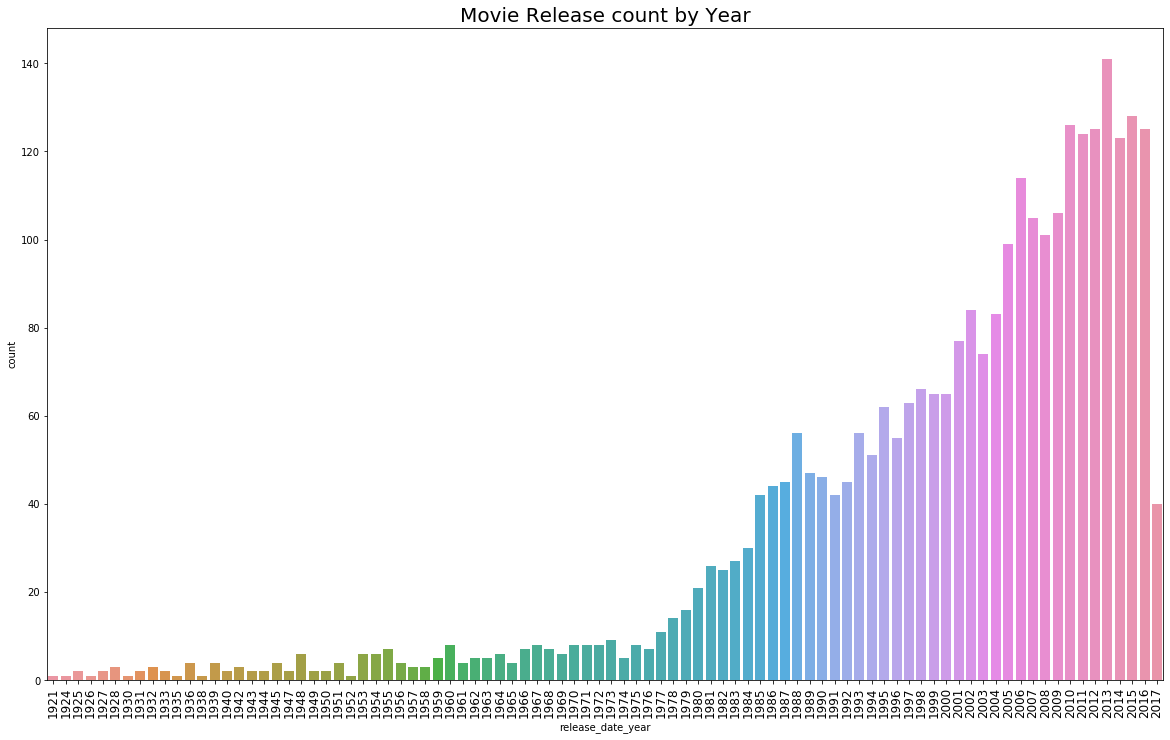

In [84]:
plt.figure(figsize=(20,12))
sns.countplot(train_set['release_date_year'].sort_values())
plt.title("Movie Release count by Year",fontsize=20)
loc, labels = plt.xticks()
plt.xticks(fontsize=12,rotation=90)
plt.show()

In [85]:


d1 = train_set['release_date_year'].value_counts().sort_index()
d2 = train_set.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [86]:
d1 = train_set['release_date_year'].value_counts().sort_index()
d2 = train_set.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

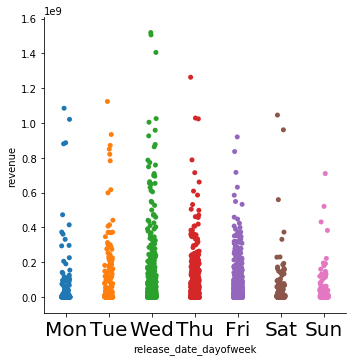

In [87]:
sns.catplot(x="release_date_dayofweek", y="revenue", data=train_set)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

The most successful days for releasing a movie are Wednesdayys and Thursdays.

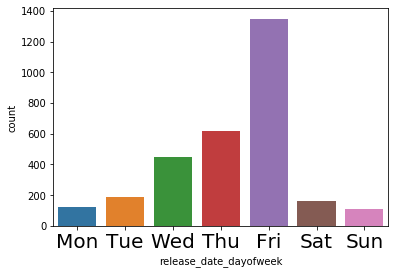

In [88]:
sns.countplot(x="release_date_dayofweek", data=train_set)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

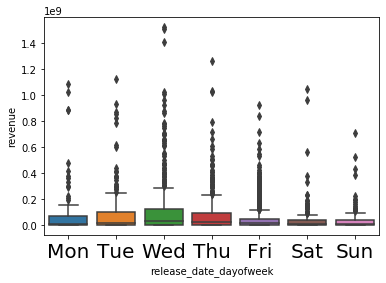

In [89]:
sns.boxplot(train_set['release_date_dayofweek'], train_set["revenue"])
loc, labels = plt.xticks()
labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

### Original_language

In [90]:
train_set["original_language"].describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

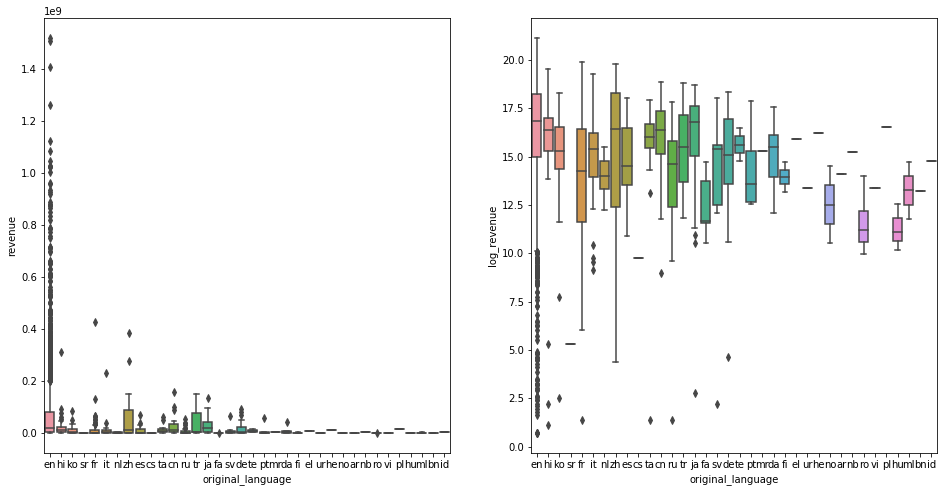

In [91]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train_set)
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train_set)

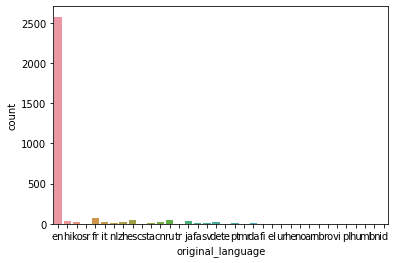

In [92]:
sns.countplot(train_set["original_language"])

English has many more films than any other language, and has amongst the highest revenue means. But films with other original languages also have high revenues

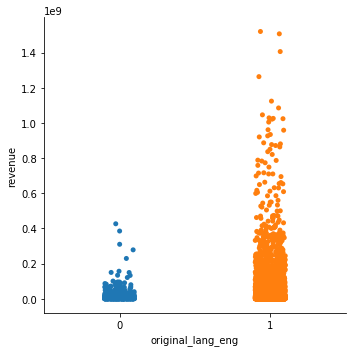

In [93]:
train_set["original_lang_eng"] = train_set["original_language"].apply(lambda x: 1 if "en" in x else 0)
sns.catplot("original_lang_eng", "revenue", data=train_set)

In [94]:
test_set["original_lang_eng"] = test_set["original_language"].apply(lambda x: 1 if "en" in x else 0)

### Original title, Overview and Tagline
It can be interesting to see which words are common in titles.

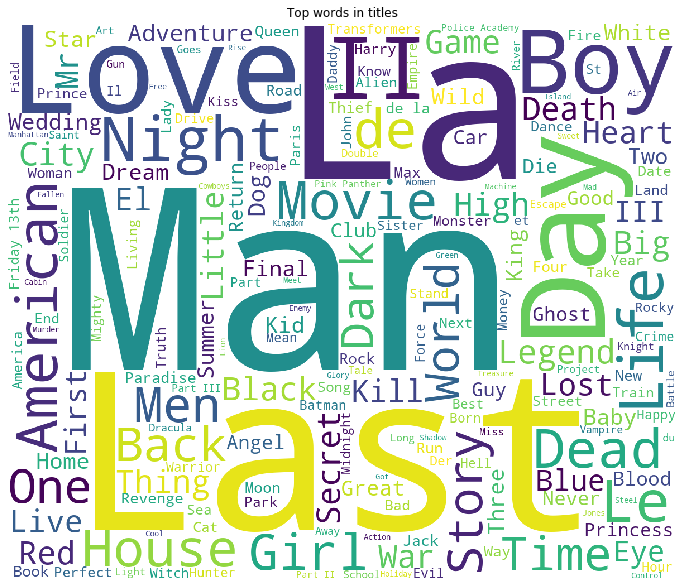

In [95]:
plt.figure(figsize = (12, 12))
text = ' '.join(train_set['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

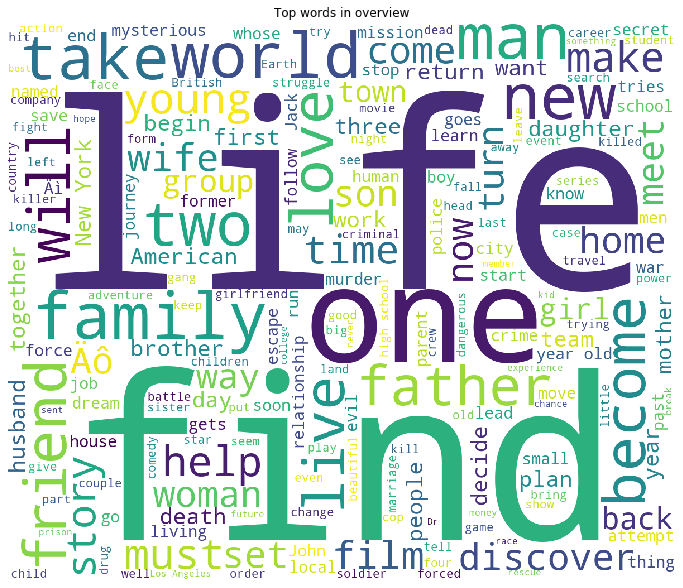

In [96]:
plt.figure(figsize = (12, 12))
text = ' '.join(train_set['overview'].fillna("").values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

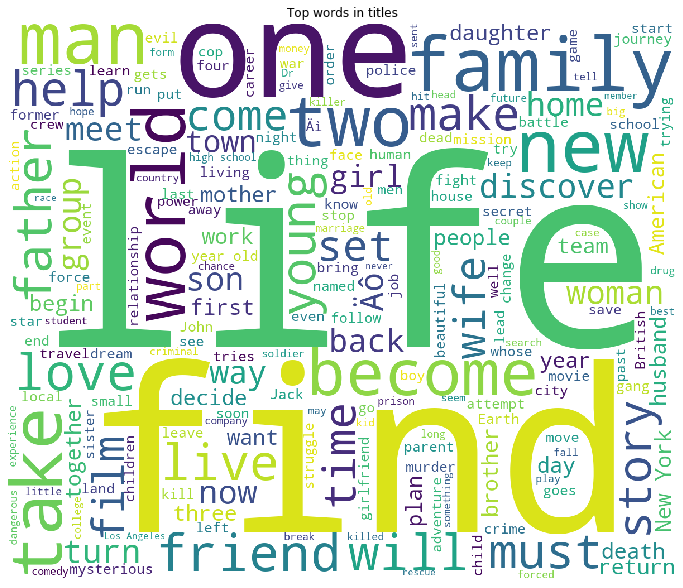

In [97]:
plt.figure(figsize = (12, 12))
train_set['has_tagline'] = 1
train_set.loc[pd.isnull(train_set['tagline']) ,"has_tagline"] = 0
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

In [98]:
test_set['has_tagline'] = 1
test_set.loc[pd.isnull(test_set['tagline']) ,"has_tagline"] = 0

Let's have a look on how a certain phase or a word in the overview might impact the revenue, using a simple linear regression with tf-idf for word mining .

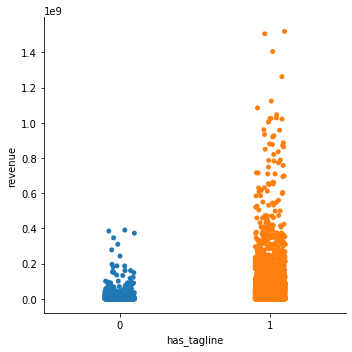

In [99]:
sns.catplot("has_tagline", "revenue", data=train_set)

In [100]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)
d = train_set["overview"].fillna("")
overview_text = vectorizer.fit_transform(d)
linreg = LinearRegression()
linreg.fit(overview_text, train_set['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [101]:
#Target: 
train_set["log_revenue"][0]

16.326300330915824

In [102]:
eli5.show_prediction(linreg, doc=train_set['overview'].values[0], vec=vectorizer)

In [103]:
train_set["title_changed"] = 1
train_set.loc[ train_set['original_title'] == train_set['title'] ,"title_changed"] = 0 

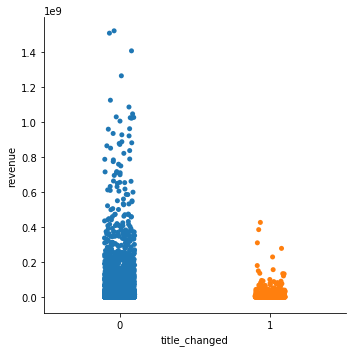

In [104]:
sns.catplot("title_changed", "revenue", data=train_set)

In [105]:
test_set["title_changed"] = 1
test_set.loc[test_set['original_title'] == test_set['title'] ,"title_changed"] = 0 

### Popularity

We see that the words in overview can have (a little) effect on the revenue, but of course in itself is not a good enough model. (Very high bias)

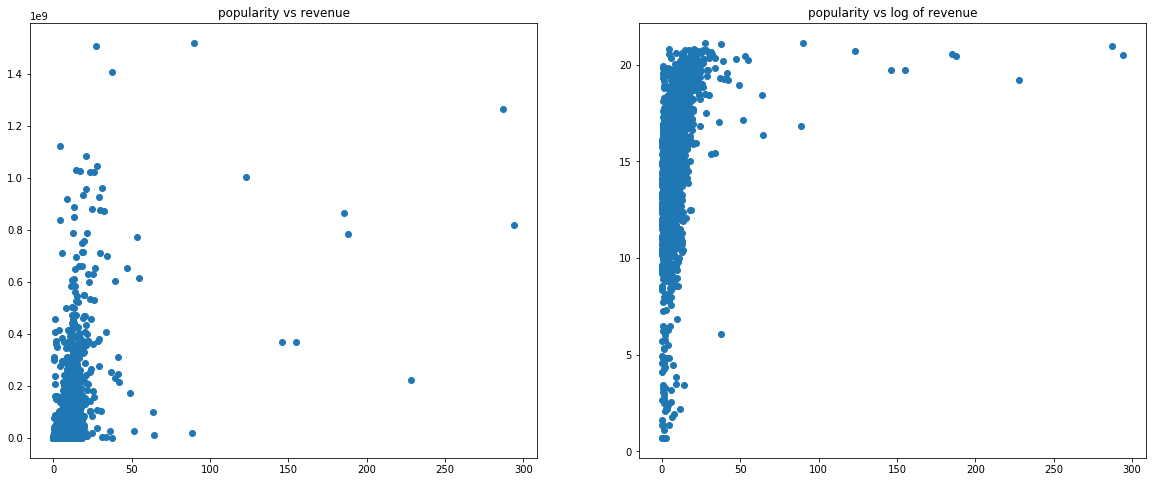

In [106]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title("popularity vs revenue")
plt.scatter(train_set["popularity"], train_set["revenue"])

plt.subplot(1,2,2)
plt.title("popularity vs log of revenue")
plt.scatter(train_set["popularity"], train_set["log_revenue"])

### Runtime


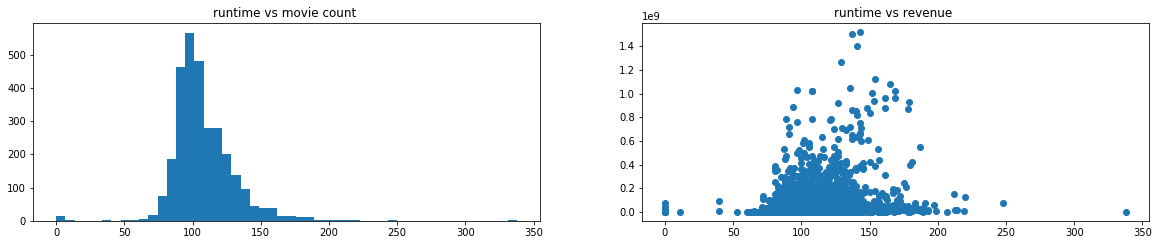

In [107]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.title("runtime vs movie count ")
plt.hist(train_set["runtime"].fillna(0),bins=50)
plt.subplot(2,2,2)
plt.title("runtime vs revenue ")
plt.scatter(train_set["runtime"], train_set["revenue"])

we see that most films are between 100 and 150 minutes, and thhat thhey are thhe movies that make the hhighest revenues.

### Status

In [108]:
train_set["status"].describe()

count         3000
unique           2
top       Released
freq          2996
Name: status, dtype: object

In [109]:
test_set["status"].describe()

count         4396
unique           3
top       Released
freq          4389
Name: status, dtype: object

This is totally useless since there are no more than 7 movies still unreleased in each of the data sets.

In [110]:
train_set.drop(["status"], axis=1, inplace=True)
test_set.drop(["status"], axis=1, inplace=True)

### Imdb_id

In [111]:
train_set["imdb_id"].describe()

count          3000
unique         3000
top       tt0079489
freq              1
Name: imdb_id, dtype: object

This actually givesa a lot of more information, some might be helpful for validating the data given in the original datasets, and some might be useful for imputing missingg data, and even generating completely new features!
We can use the python library imdbpy as follows.

In [112]:
ia = IMDb()
movie = ia.get_movie(train_set["imdb_id"][0][2:])
print(movie.keys())

['cast', 'genres', 'runtimes', 'countries', 'country codes', 'language codes', 'color info', 'aspect ratio', 'sound mix', 'box office', 'certificates', 'original air date', 'rating', 'votes', 'cover url', 'plot outline', 'languages', 'title', 'year', 'kind', 'directors', 'writers', 'producers', 'composers', 'cinematographers', 'editors', 'editorial department', 'casting directors', 'production designers', 'art directors', 'set decorators', 'costume designers', 'make up department', 'production managers', 'assistant directors', 'art department', 'sound department', 'special effects', 'visual effects', 'stunts', 'camera department', 'animation department', 'casting department', 'costume departmen', 'location management', 'music department', 'script department', 'transportation department', 'miscellaneous', 'akas', 'writer', 'director', 'production companies', 'distributors', 'special effects companies', 'other companies', 'plot', 'synopsis', 'canonical title', 'long imdb title', 'long im

In [113]:
movie["languages"]

['English']

In [114]:
train_set["imdb_id"][0]

'tt2637294'

Not sure this feature is usable... if we use the rating of the movies it would be "cheating" because ratings are not available until after the movies get released

## Modelling

### some fixes to the data points first

transfer languages and names to codes

In [115]:
train_set["original_language"]

0       en
1       en
2       en
3       hi
4       ko
        ..
2995    en
2996    sv
2997    en
2998    en
2999    en
Name: original_language, Length: 3000, dtype: object

In [116]:
for col in ['original_language', 'collection_name']:
    le = LabelEncoder()
    le.fit(list(train_set[col].fillna('')) + list(test_set[col].fillna('')))
    train_set[col] = le.transform(train_set[col].fillna('').astype(str))
    test_set[col] = le.transform(test_set[col].fillna('').astype(str))

train_set["original_language"]

0       10
1       10
2       10
3       16
4       24
        ..
2995    10
2996    35
2997    10
2998    10
2999    10
Name: original_language, Length: 3000, dtype: int64

In [117]:
# we don't need the following features any more
train_set = train_set.drop(['imdb_id', 'poster_path', 'release_date', 'log_revenue'], axis=1)
test_set = test_set.drop(['imdb_id', 'poster_path', 'release_date'], axis=1)

In [118]:
# text features extraction for dealing with texts later
text_features = ['title', 'tagline', 'overview', 'original_title']
train_texts = train_set[text_features]
test_texts = test_set[text_features]

In [119]:
for col in text_features:
    train_set['len_' + col] = train_set[col].fillna('').apply(lambda x: len(str(x)))
    train_set['words_' + col] = train_set[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train_set.drop(col, axis=1, inplace=True)
    test_set['len_' + col] = test_set[col].fillna('').apply(lambda x: len(str(x)))
    test_set['words_' + col] = test_set[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test_set.drop(col, axis=1, inplace=True)

In [120]:

#multiply by a million the strangely small revenues 
power_six = train_set.id[train_set.budget > 1000][train_set.revenue < 100]
for k in power_six :
    train_set.loc[train_set['id'] == k,'revenue'] =  train_set.loc[train_set['id'] == k,'revenue'] * 1000000

In [121]:
# # data fixes... try to uncomment and check their effect

# # maybe there is a better way to do this... :/

# train_set.loc[train_set['id'] == 16,'revenue'] = 192864          # Skinning
# train_set.loc[train_set['id'] == 90,'budget'] = 30000000         # Sommersby          
# train_set.loc[train_set['id'] == 118,'budget'] = 60000000        # Wild Hogs
# train_set.loc[train_set['id'] == 149,'budget'] = 18000000        # Beethoven
# train_set.loc[train_set['id'] == 313,'revenue'] = 12000000       # The Cookout 
# train_set.loc[train_set['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
# train_set.loc[train_set['id'] == 464,'budget'] = 20000000        # Parenthood
# train_set.loc[train_set['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
# train_set.loc[train_set['id'] == 513,'budget'] = 930000          # From Prada to Nada
# train_set.loc[train_set['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
# train_set.loc[train_set['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
# train_set.loc[train_set['id'] == 850,'budget'] = 90000000        # Modern Times
# train_set.loc[train_set['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
# train_set.loc[train_set['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
# train_set.loc[train_set['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
# train_set.loc[train_set['id'] == 1542,'budget'] = 1              # All at Once
# train_set.loc[train_set['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
# train_set.loc[train_set['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
# train_set.loc[train_set['id'] == 1714,'budget'] = 46000000       # The Recruit
# train_set.loc[train_set['id'] == 1721,'budget'] = 17500000       # Cocoon
# train_set.loc[train_set['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
# train_set.loc[train_set['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
# train_set.loc[train_set['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
# train_set.loc[train_set['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
# train_set.loc[train_set['id'] == 2612,'budget'] = 15000000       # Field of Dreams
# train_set.loc[train_set['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
# train_set.loc[train_set['id'] == 2801,'budget'] = 10000000       # Fracture
# test_set.loc[test_set['id'] == 3889,'budget'] = 15000000       # Colossal
# test_set.loc[test_set['id'] == 6733,'budget'] = 5000000        # The Big Sick
# test_set.loc[test_set['id'] == 3197,'budget'] = 8000000        # High-Rise
# test_set.loc[test_set['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
# test_set.loc[test_set['id'] == 5704,'budget'] = 4300000        # French Connection II
# test_set.loc[test_set['id'] == 6109,'budget'] = 281756         # Dogtooth
# test_set.loc[test_set['id'] == 7242,'budget'] = 10000000       # Addams Family Values
# test_set.loc[test_set['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
# test_set.loc[test_set['id'] == 5591,'budget'] = 4000000        # The Orphanage
# test_set.loc[test_set['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee


### Decision trees gradient booster

Important notice: we will never be guessing the exact revenue of any movie, this is why the target function we defined is the log(revenue) meaning we hope to guess the right log of revenue for every movie.
also we will be using log1p = (log(1+x)) because it is more accurate. From the documentation of numpy:
For real-valued input, log1p is accurate also for x so small that 1 + x == 1 in floating-point accuracy.

In [122]:
#Gradient booster with decision trees

# maybe some parameter tuning...

# refferences: 
#             https://en.wikipedia.org/wiki/Gradient_boosting
#             https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
#             https://lightgbm.readthedocs.io/en/latest/Parameters.html


# Prepare for training
X = train_set.drop(['id', 'revenue'], axis=1)
y = np.log1p(train_set['revenue'])
X_test = test_set.drop(['id'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)


params = {"max_depth": 4,
         "learning_rate": 0.01,
         "metric": 'rmse',
         "bagging_freq":1, 
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9,
         "lambda_l2": 0.3}

#Gradient booster 

model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.51517	valid_1's rmse: 2.14994
Early stopping, best iteration is:
[1222]	training's rmse: 1.44943	valid_1's rmse: 2.14168


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l2=0.3, learning_rate=0.01,
              max_depth=4, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=20000,
              n_jobs=-1, nthread=4, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Let's have a look at the importance of each feature

In [123]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

The following class will define the behaviour expected from a trainer with the KFold cross validation

In [124]:
class Trainer(object):
    def __init__(self, n_folds=10, X=None, X_test=None, y=None, params={}):
        self.n_folds = n_folds
        self.folds = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        self.X = X
        self.X_test = X_test
        self.y = y
        self.oof = np.zeros(X.shape[0])
        self.prediction = np.zeros(X_test.shape[0])
        self.scores = []
        self.params = params
        self.feature_importance = pd.DataFrame()

    def fit(self):
        raise NotImplementedError()
        
    def show_model_scores(self):
        raise NotImplementedError()
    
    

Gradient booster with KFold cross validation

In [125]:
class LgbTrainer(Trainer):
    
    def fit(self):
        
        for fold_n, (train_index, valid_index) in enumerate(self.folds.split(self.X)):
            print('Fold', fold_n, 'started at', time.ctime())

            X_train, X_valid = self.X.values[train_index], self.X.values[valid_index]
            y_train, y_valid = self.y[train_index], self.y[valid_index]

            model = lgb.LGBMRegressor(**self.params, n_estimators = 20000, nthread = 4, n_jobs = -1)

            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(self.X_test, num_iteration=model.best_iteration_)


            self.oof[valid_index] = y_pred_valid.reshape(-1,)
            self.scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)

            # we will average the predictions and feature importance over all folds
            self.prediction += y_pred    

            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = self.X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            self.feature_importance = pd.concat([self.feature_importance, fold_importance], axis=0)
        self.prediction /= self.n_folds
        self.feature_importance["importance"] /= self.n_folds

    def show_model_scores(self):
        print('LGB Cross Validation mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(self.scores), np.std(self.scores)))
        
    def plot_feature_importance(self):
        #50 most influencial features
        cols = self.feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index

        best_features = self.feature_importance.loc[self.feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');

Fold 0 started at Wed Feb 26 11:13:06 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.21843	valid_1's rmse: 1.89161
[2000]	training's rmse: 0.890053	valid_1's rmse: 1.88002
Early stopping, best iteration is:
[1953]	training's rmse: 0.901704	valid_1's rmse: 1.87873
Fold 1 started at Wed Feb 26 11:13:15 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.22747	valid_1's rmse: 1.82396
Early stopping, best iteration is:
[1139]	training's rmse: 1.17587	valid_1's rmse: 1.82269
Fold 2 started at Wed Feb 26 11:13:21 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.2448	valid_1's rmse: 1.67701
[2000]	training's rmse: 0.915851	valid_1's rmse: 1.65596
Early stopping, best iteration is:
[1948]	training's rmse: 0.928536	valid_1's rmse: 1.6545
Fold 3 started at Wed Feb 26 11:13:31 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1

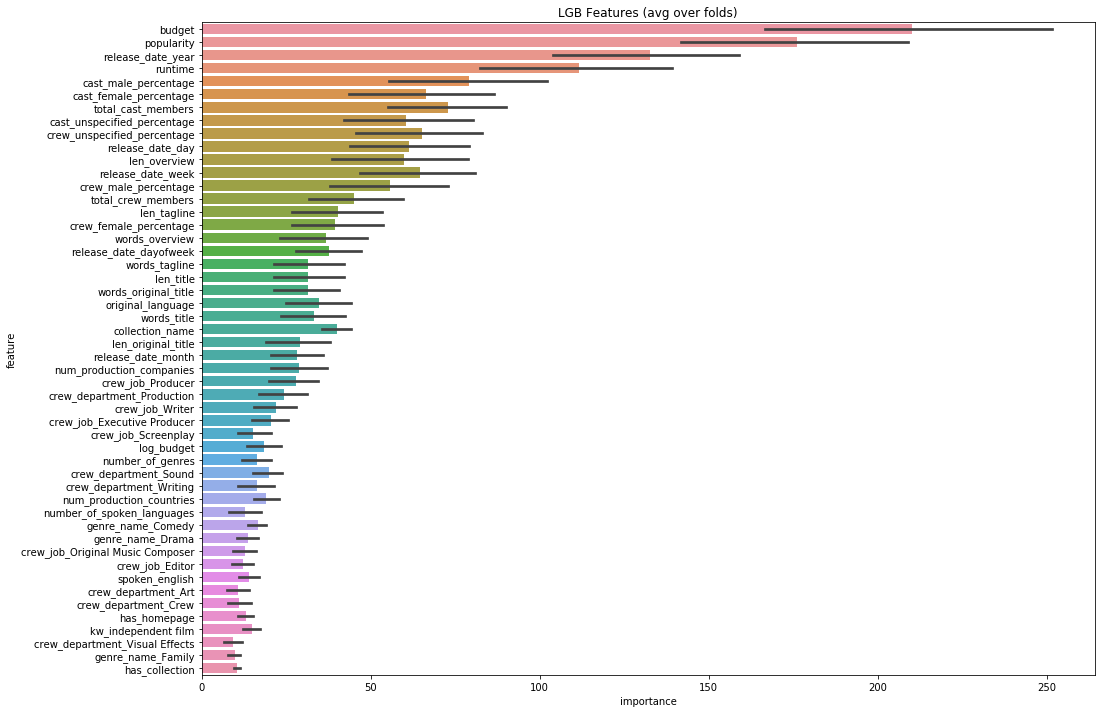

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model = LgbTrainer(X=X, X_test=X_test, y=y, params=params)
model.fit()
model.show_model_scores()
print("\n\nLGB importance of each feature, averaged on all folds:\n")
model.plot_feature_importance()

## Text features processing

Generating features based on text features

In [127]:
class RidgeTrainer(Trainer):
    
    def __init__(self, n_folds=10, X=None, X_test=None, y=None, params={}):
        super(RidgeTrainer, self).__init__(n_folds,X,X_test,y,params)
        self.model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=self.folds)
        
    def fit(self):
        for fold_n, (train_index, valid_index) in enumerate(self.folds.split(X)):
            print('Fold', fold_n, 'started at', time.ctime())
            X_train, X_valid = self.X[train_index], self.X[valid_index]

            y_train, y_valid = self.y[train_index], self.y[valid_index]

            self.model.fit(X_train, y_train)
            y_pred_valid = self.model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)

            y_pred = self.model.predict(self.X_test)


            self.oof[valid_index] = y_pred_valid.reshape(-1,)
            self.scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)

            self.prediction += y_pred    


        self.prediction /= self.n_folds
        
    def show_model_scores(self):
        print('Ridge Cross Validation mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(self.scores), np.std(self.scores)))
      

In [128]:
for col in train_texts.columns:
    print("\n Analyzing text in column: {}".format(col))
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(test_texts[col].fillna(''))
    trainer = RidgeTrainer(X=train_col_text, X_test=test_col_text, y=y)
    trainer.fit()
    trainer.show_model_scores()
    X[col + '_oof'] = trainer.oof
    X_test[col + '_oof'] =trainer.prediction


 Analyzing text in column: title
Fold 0 started at Wed Feb 26 11:14:14 2020
Fold 1 started at Wed Feb 26 11:14:14 2020
Fold 2 started at Wed Feb 26 11:14:14 2020
Fold 3 started at Wed Feb 26 11:14:15 2020
Fold 4 started at Wed Feb 26 11:14:15 2020
Fold 5 started at Wed Feb 26 11:14:15 2020
Fold 6 started at Wed Feb 26 11:14:16 2020
Fold 7 started at Wed Feb 26 11:14:16 2020
Fold 8 started at Wed Feb 26 11:14:16 2020
Fold 9 started at Wed Feb 26 11:14:17 2020
Ridge Cross Validation mean score: 2.9646, std: 0.1883.

 Analyzing text in column: tagline
Fold 0 started at Wed Feb 26 11:14:17 2020
Fold 1 started at Wed Feb 26 11:14:18 2020
Fold 2 started at Wed Feb 26 11:14:18 2020
Fold 3 started at Wed Feb 26 11:14:19 2020
Fold 4 started at Wed Feb 26 11:14:19 2020
Fold 5 started at Wed Feb 26 11:14:20 2020
Fold 6 started at Wed Feb 26 11:14:20 2020
Fold 7 started at Wed Feb 26 11:14:21 2020
Fold 8 started at Wed Feb 26 11:14:21 2020
Fold 9 started at Wed Feb 26 11:14:22 2020
Ridge Cross Va

### MORE FEATURES

In [133]:
# scratch your head for even more features :D
def new_features(df):
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    df['budget_to_total_cast_members'] = df['budget'] / df['total_cast_members']
    df['budget_to_total_crew_members'] = df['budget'] / df['total_crew_members']
    df['budget_to_year'] = df['budget'] / df['release_date_year']
    df['runtime_to_mean_runtime_per_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_popularity_per_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_budget_per_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
    df["number_of_genres_to_mean_number_generes_per_year"] = df["number_of_genres"]/df.groupby("release_date_year")["number_of_genres"].transform("mean")
    return df

In [134]:
X = new_features(X)
X_test = new_features(X_test)

We can test how these features affect our results

Fold 0 started at Wed Feb 26 11:19:21 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.16177	valid_1's rmse: 1.8878
[2000]	training's rmse: 0.825254	valid_1's rmse: 1.87323
Early stopping, best iteration is:
[2311]	training's rmse: 0.744699	valid_1's rmse: 1.86982
Fold 1 started at Wed Feb 26 11:19:35 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.17192	valid_1's rmse: 1.85624
Early stopping, best iteration is:
[1123]	training's rmse: 1.12289	valid_1's rmse: 1.85293
Fold 2 started at Wed Feb 26 11:19:43 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.18022	valid_1's rmse: 1.71026
[2000]	training's rmse: 0.838164	valid_1's rmse: 1.69221
Early stopping, best iteration is:
[2074]	training's rmse: 0.818589	valid_1's rmse: 1.69114
Fold 3 started at Wed Feb 26 11:19:54 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 

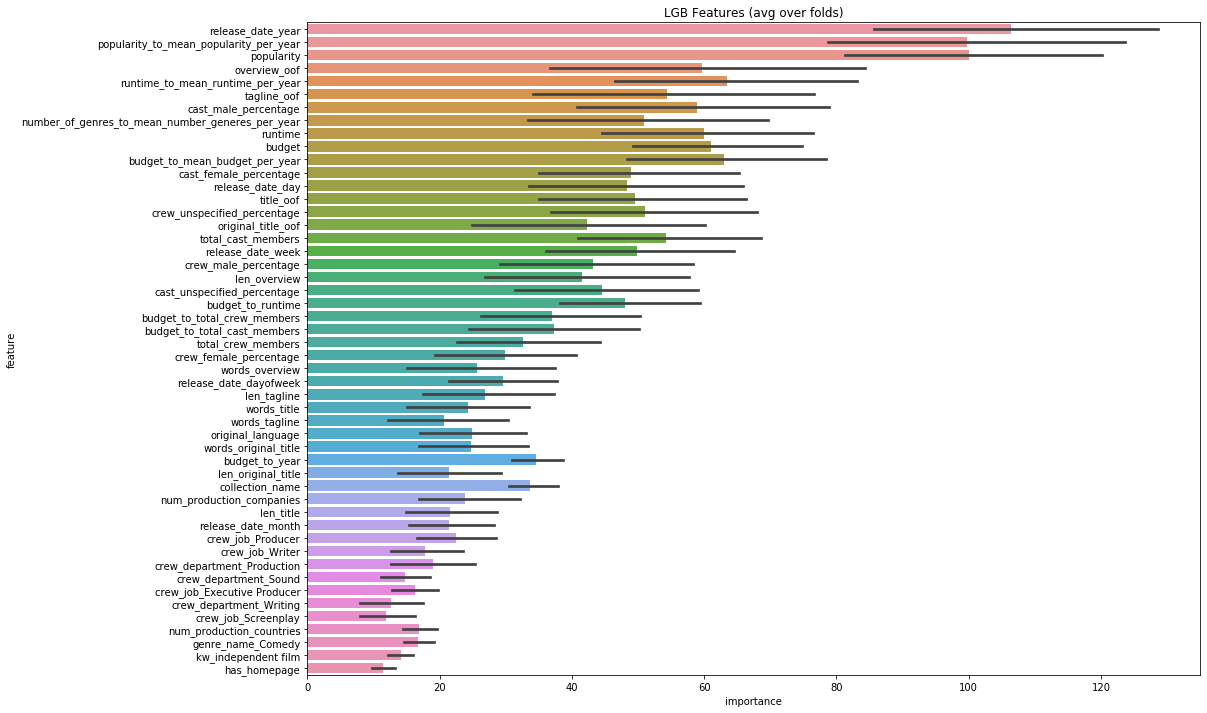

In [135]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model = LgbTrainer(X=X, X_test=X_test, y=y, params=params)
model.fit()
model.show_model_scores()
print("\n\nLGB importance of each feature, averaged on all folds:\n")
model.plot_feature_importance()

We see that some of our new features take very high ranks amongst the important features.

### Important features

Let's have a look at important features using ELI5 and SHAP!

references: (very very informative)
https://christophm.github.io/interpretable-ml-book/shapley.html#shapley

https://christophm.github.io/interpretable-ml-book/shap.html

In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.0933	valid_1's rmse: 1.90788
Early stopping, best iteration is:
[1033]	training's rmse: 1.07652	valid_1's rmse: 1.90578


We can see that important features native to LGB and top features in ELI5 are mostly similar. This means that our model is quite good at working with these features.

Passing 2700 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
100%|===================| 2698/2700 [41:34<00:01]        

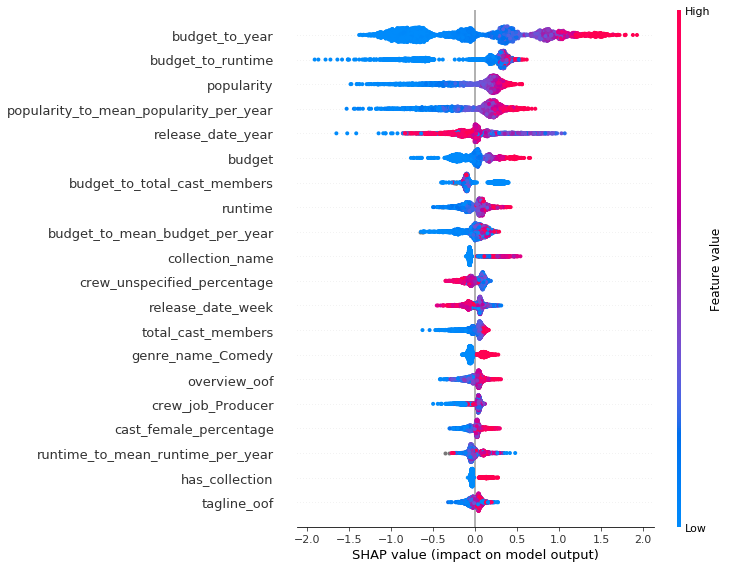

In [137]:
explainer = shap.TreeExplainer(model1, X_train)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

This graph means, for example, that low popularity values have negavite impact on revenue, while high values have higher revenues.

In [138]:
shap_interaction_values = shap.TreeExplainer(model1).shap_interaction_values(X_train)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


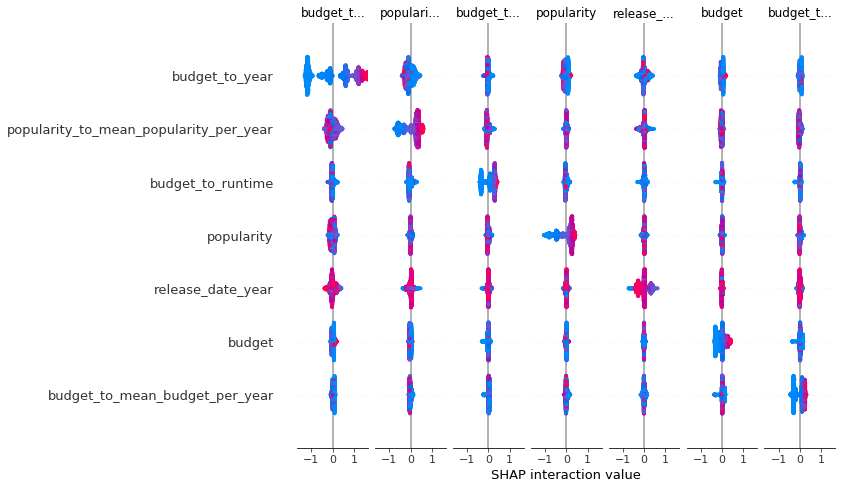

In [139]:
shap.summary_plot(shap_interaction_values, X_train)

invalid value encountered in subtract


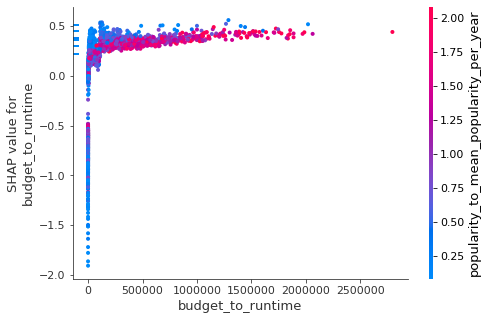

invalid value encountered in subtract


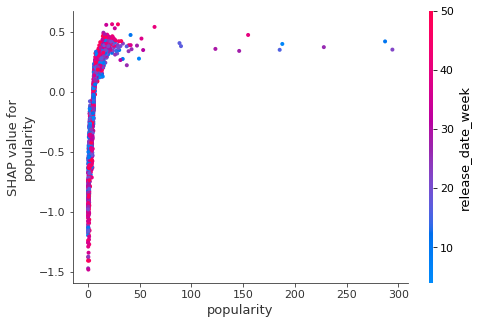

invalid value encountered in subtract


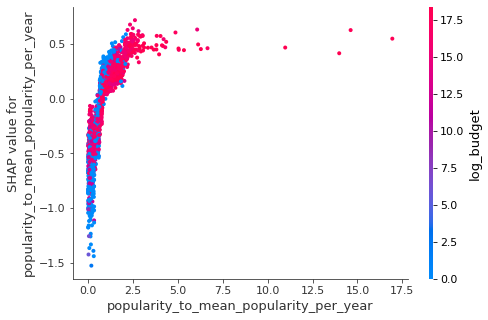

invalid value encountered in subtract


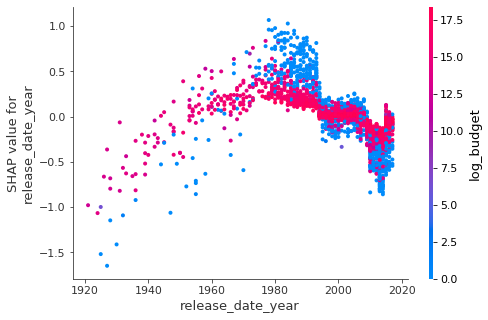

invalid value encountered in subtract


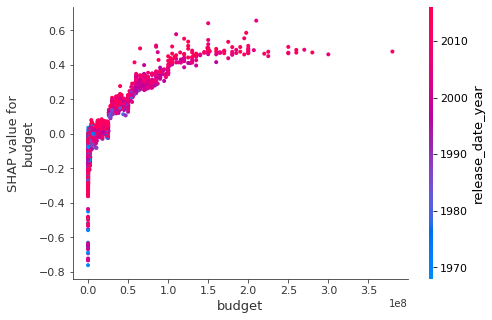

invalid value encountered in subtract


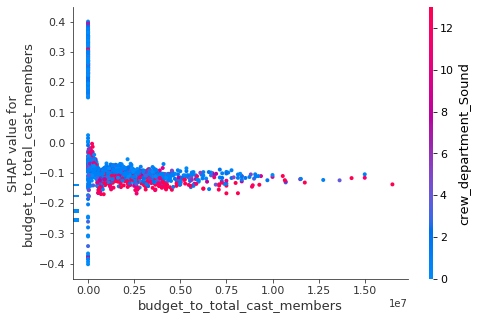

invalid value encountered in subtract


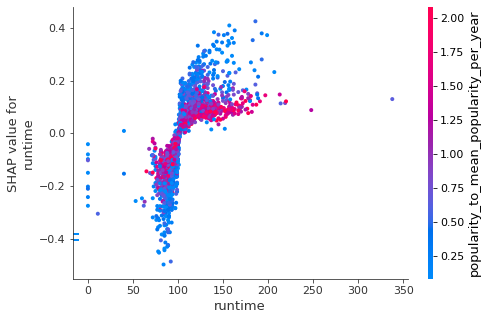

invalid value encountered in subtract


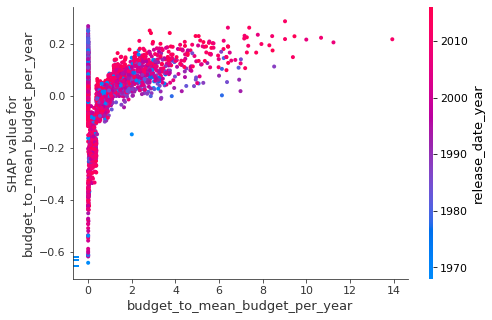

invalid value encountered in subtract


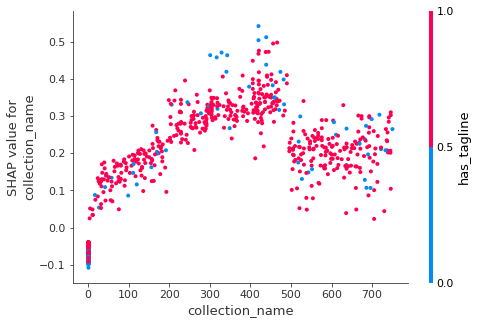

In [140]:
for i in range(10):
    if i>0:
        shap.dependence_plot("rank({})".format(i), shap_values, X_train)

These graphs display "interactions" between features. For example, there is some correlation between log_budget and the year of release, as we  can see from the graph above, up untill the year 2000 high budget (red dots) didn't necessarily mean good revenues (the effect on the revenue is the vertical axis, such that high points mean a positive influence on the revenue). We even can see that between 1980 and 1990 low budget movies achieved greater revenues in the box office! But after the year 2010 there is a clear correlation between high budgets and high revenues.

These graphs are in fact very useful for additional feature generation, they tell us explicitly which pairs of features have a high impact on the revenue! So, without further a do, let's generate more combined feratures based on some of the graphs above.

In [152]:
def gen_interaction_features(df):
    df['interact_popularity_w_log_budget'] = df['popularity'] / df['log_budget']
    df['interact_budget_to_runtime_w_popularity_to_mean_popylarity_per_year'] = df['budget_to_runtime'] / df['popularity_to_mean_popularity_per_year']
    df['interact_release_date_year_w_log_budget'] =  df['release_date_year'] / df['log_budget']
    df['interact_popularity_to_mean_popularity_per_year_w_log_budget'] = df['popularity_to_mean_popularity_per_year'] / df['log_budget']
    df['interact_budget_to_mean_budget_per_year_w_release_date_year'] = df['budget_to_mean_budget_per_year'] / df['release_date_year']
    df['interact_total_cast_members_w_log_budget'] = df['total_cast_members'] / df['log_budget']
    df['interact_runtime_w_log_budget'] = df['runtime'] / df['log_budget']
    df['interact_budget_to_total_crew_members_w_popularity_to_mean_popularity_per_year'] = df['budget_to_total_crew_members'] / df['popularity_to_mean_popularity_per_year']
    df['interact_popularity_w_release_date_week'] = df['popularity'] / df['release_date_week']

    return df

X = gen_interaction_features(X)
X_test = gen_interaction_features(X_test)

In [154]:
X.head()

budget  original_language  popularity  runtime  genre_name_Comedy  \
0  14000000                 10    6.575393     93.0                  1   
1  40000000                 10    8.248895    113.0                  1   
2   3300000                 10   64.299990    105.0                  0   
3   1200000                 16    3.174936    122.0                  0   
4         0                 24    1.148070    118.0                  0   

   genre_name_Drama  genre_name_Family  genre_name_Romance  \
0                 0                  0                   0   
1                 1                  1                   1   
2                 1                  0                   0   
3                 1                  0                   0   
4                 0                  0                   0   

   genre_name_Thriller  genre_name_Action  genre_name_Animation  \
0                    0                  0                     0   
1                    0                  0                     0   
2                    0                  0                     0   
3                    1                  0                     0   
4                    1                  1                     0   

   genre_name_Adventure  genre_name_Horror  genre_name_Music  \
0                     0                  0                 0   
1                     0                  0                 0   
2                     0                  0                 0   
3                     0                  0                 0   
4                     0                  0                 0   

   genre_name_Crime  genre_name_Science Fiction  genre_name_Mystery  \
0                 0                           0                   0   
1                 0                           0                   0   
2                 0                           0                   0   
3                 0                           0                   0   
4                 0                           0                   0   

   genre_name_Fantasy  genre_name_War  genre_name_History  number_of_genres  \
0                   0               0                   0                 1   
1                   0               0                   0                 4   
2                   0               0                   0                 1   
3                   0               0                   0                 2   
4                   0               0                   0                 2   

   spoken_english  number_of_spoken_languages  collection_name  \
0               1                           1              282   
1               1                           1              641   
2               1                           1                1   
3               1                           2                1   
4               0                           1                1   

   has_collection  log_budget  kw_sequel  kw_duringcreditsstinger  \
0               1   16.454568          1                        1   
1               1   17.504390          0                        0   
2               0   15.009433          0                        0   
3               0   13.997833          0                        0   
4               0    0.000000          0                        0   

   kw_violence  kw_woman director  kw_female nudity  kw_nudity  kw_dystopia  \
0            0                  0                 0          0            0   
1            0                  0                 0          0            0   
2            1                  0                 0          0            0   
3            0                  0                 0          0            0   
4            0                  0                 0          0            0   

   kw_murder  kw_biography  kw_kidnapping  kw_independent film  kw_new york  \
0          0             0              0                    0            0   
1          0             0              0           

In [155]:
X = X.replace([np.inf, -np.inf], 0).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

In [156]:
X.head()

budget  original_language  popularity  runtime  genre_name_Comedy  \
0  14000000                 10    6.575393     93.0                  1   
1  40000000                 10    8.248895    113.0                  1   
2   3300000                 10   64.299990    105.0                  0   
3   1200000                 16    3.174936    122.0                  0   
4         0                 24    1.148070    118.0                  0   

   genre_name_Drama  genre_name_Family  genre_name_Romance  \
0                 0                  0                   0   
1                 1                  1                   1   
2                 1                  0                   0   
3                 1                  0                   0   
4                 0                  0                   0   

   genre_name_Thriller  genre_name_Action  genre_name_Animation  \
0                    0                  0                     0   
1                    0                  0                     0   
2                    0                  0                     0   
3                    1                  0                     0   
4                    1                  1                     0   

   genre_name_Adventure  genre_name_Horror  genre_name_Music  \
0                     0                  0                 0   
1                     0                  0                 0   
2                     0                  0                 0   
3                     0                  0                 0   
4                     0                  0                 0   

   genre_name_Crime  genre_name_Science Fiction  genre_name_Mystery  \
0                 0                           0                   0   
1                 0                           0                   0   
2                 0                           0                   0   
3                 0                           0                   0   
4                 0                           0                   0   

   genre_name_Fantasy  genre_name_War  genre_name_History  number_of_genres  \
0                   0               0                   0                 1   
1                   0               0                   0                 4   
2                   0               0                   0                 1   
3                   0               0                   0                 2   
4                   0               0                   0                 2   

   spoken_english  number_of_spoken_languages  collection_name  \
0               1                           1              282   
1               1                           1              641   
2               1                           1                1   
3               1                           2                1   
4               0                           1                1   

   has_collection  log_budget  kw_sequel  kw_duringcreditsstinger  \
0               1   16.454568          1                        1   
1               1   17.504390          0                        0   
2               0   15.009433          0                        0   
3               0   13.997833          0                        0   
4               0    0.000000          0                        0   

   kw_violence  kw_woman director  kw_female nudity  kw_nudity  kw_dystopia  \
0            0                  0                 0          0            0   
1            0                  0                 0          0            0   
2            1                  0                 0          0            0   
3            0                  0                 0          0            0   
4            0                  0                 0          0            0   

   kw_murder  kw_biography  kw_kidnapping  kw_independent film  kw_new york  \
0          0             0              0                    0            0   
1          0             0              0           

Fold 0 started at Wed Feb 26 13:38:44 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.8955	valid_1's rmse: 1.85273
Early stopping, best iteration is:
[921]	training's rmse: 0.93938	valid_1's rmse: 1.8506
Fold 1 started at Wed Feb 26 13:38:54 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.898818	valid_1's rmse: 1.85831
Early stopping, best iteration is:
[869]	training's rmse: 0.973183	valid_1's rmse: 1.85317
Fold 2 started at Wed Feb 26 13:39:04 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.891817	valid_1's rmse: 1.69362
Early stopping, best iteration is:
[1013]	training's rmse: 0.885037	valid_1's rmse: 1.69258
Fold 3 started at Wed Feb 26 13:39:13 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[735]	training's rmse: 1.05217	valid_1's rmse: 1.88625
Fold 4 started at Wed Feb 26 13:39:21 2020
Traini

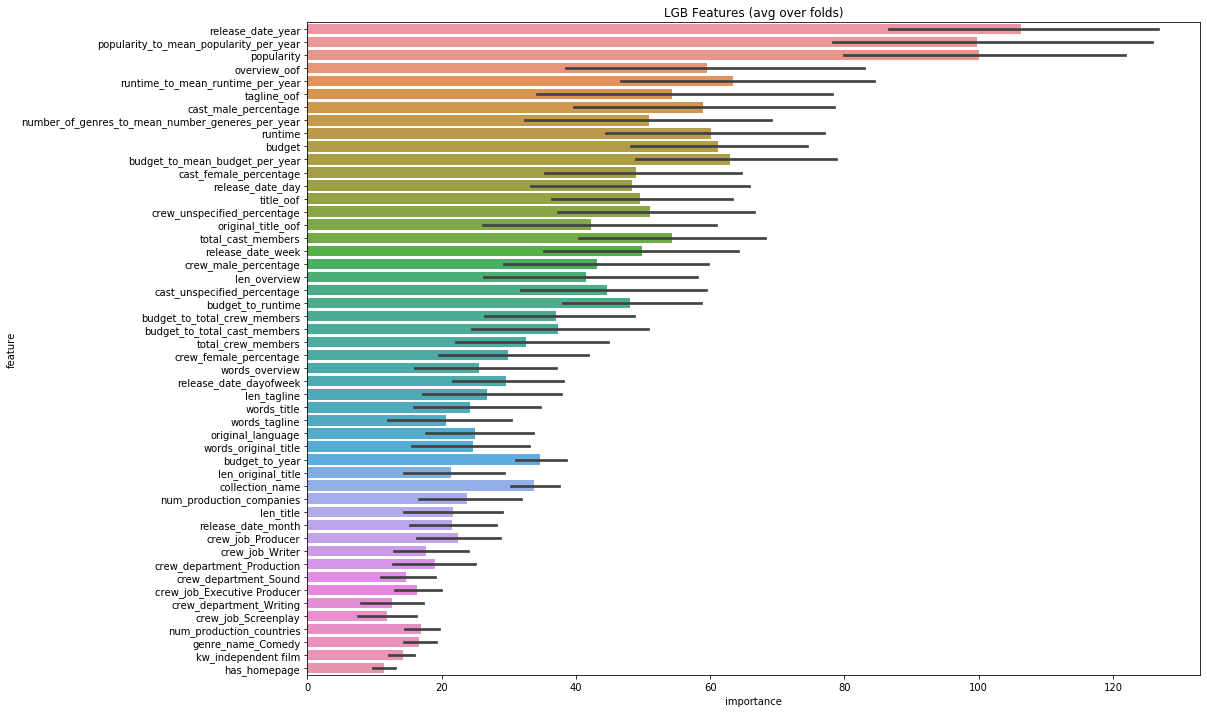

In [157]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = LgbTrainer(X=X, X_test=X_test, y=y, params=params)
lgb_model.fit()
lgb_model.show_model_scores()
print("\n\nLGB importance of each feature, averaged on all folds:\n")
model.plot_feature_importance()

In [158]:
class XgbTrainer(Trainer):
        
    def fit(self):
        for fold_n, (train_index, valid_index) in enumerate(self.folds.split(X)):
            print('Fold', fold_n, 'started at', time.ctime())
            X_train, X_valid = self.X.values[train_index], self.X.values[valid_index]
            y_train, y_valid = self.y[train_index], self.y[valid_index]
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=self.params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(self.X_test.values), ntree_limit=model.best_ntree_limit)
            self.oof[valid_index] = y_pred_valid.reshape(-1,)
            self.scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
            self.prediction += y_pred
        
        self.prediction /= self.n_folds
        
    def show_model_scores(self):
        print('XG boost Cross Validation mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(self.scores), np.std(self.scores)))
      

In [159]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
xgb_model = XgbTrainer(X=X, X_test=X_test, y=y, params=xgb_params)
xgb_model.fit()
xgb_model.show_model_scores()

Fold 0 started at Wed Feb 26 13:40:02 2020
[0]	train-rmse:15.59828	valid_data-rmse:15.89920
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.96605	valid_data-rmse:1.85681
[1000]	train-rmse:0.59231	valid_data-rmse:1.83347
[1500]	train-rmse:0.37186	valid_data-rmse:1.83112
Stopping. Best iteration:
[1345]	train-rmse:0.43044	valid_data-rmse:1.82971

Fold 1 started at Wed Feb 26 13:41:05 2020
[0]	train-rmse:15.62937	valid_data-rmse:15.61851
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.96446	valid_data-rmse:1.89433
[1000]	train-rmse:0.60292	valid_data-rmse:1.86627
Stopping. Best iteration:
[1089]	train-rmse:0.55379	valid_data-rmse:1.86392

Fold 2 started at Wed Feb 26 13:41:58 2020
[0]	train-rmse:15.61666	valid_data-rmse:15.73583
Multiple e

In [160]:
class CatTrainer(Trainer):
        
    def fit(self):
        for fold_n, (train_index, valid_index) in enumerate(self.folds.split(X)):
            print('Fold', fold_n, 'started at', time.ctime())
            X_train, X_valid = self.X.values[train_index], self.X.values[valid_index]
            y_train, y_valid = self.y[train_index], self.y[valid_index]
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **self.params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(self.X_test)
        
            self.oof[valid_index] = y_pred_valid.reshape(-1,)
            self.scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
            
            self.prediction += y_pred
        
        self.prediction /= self.n_folds
        
    def show_model_scores(self):
        print('CAT Cross Validation mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(self.scores), np.std(self.scores)))
      

In [161]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
cat_model = CatTrainer(X=X, X_test=X_test, y=y, params=cat_params)
cat_model.fit()
cat_model.show_model_scores()

Fold 0 started at Wed Feb 26 13:48:28 2020
Fold 1 started at Wed Feb 26 13:49:32 2020
Fold 2 started at Wed Feb 26 13:50:31 2020
Fold 3 started at Wed Feb 26 13:51:46 2020
Fold 4 started at Wed Feb 26 13:52:57 2020
Fold 5 started at Wed Feb 26 13:53:29 2020
Fold 6 started at Wed Feb 26 13:54:08 2020
Fold 7 started at Wed Feb 26 13:54:38 2020
Fold 8 started at Wed Feb 26 13:55:33 2020
Fold 9 started at Wed Feb 26 13:56:00 2020
CAT Cross Validation mean score: 1.9287, std: 0.1852.


In [162]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
lgb_model1 = LgbTrainer(X=X, X_test=X_test, y=y, params=params)
lgb_model1.fit()
lgb_model1.show_model_scores()


Fold 0 started at Wed Feb 26 13:56:23 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.30056	valid_1's rmse: 1.8463
Early stopping, best iteration is:
[1706]	training's rmse: 1.0704	valid_1's rmse: 1.83321
Fold 1 started at Wed Feb 26 13:56:31 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.31963	valid_1's rmse: 1.86978
Early stopping, best iteration is:
[1197]	training's rmse: 1.24458	valid_1's rmse: 1.86423
Fold 2 started at Wed Feb 26 13:56:36 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.31279	valid_1's rmse: 1.71561
Early stopping, best iteration is:
[1323]	training's rmse: 1.1942	valid_1's rmse: 1.70902
Fold 3 started at Wed Feb 26 13:56:42 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.29268	valid_1's rmse: 1.87257
Early stopping, best iteration is:
[937]	training's rmse: 1.31806	valid_1's rmse: 1.86

In [163]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
lgb_model2 = LgbTrainer(X=X, X_test=X_test, y=y, params=params)
lgb_model2.fit()
lgb_model2.show_model_scores()



Fold 0 started at Wed Feb 26 13:57:19 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[604]	training's rmse: 0.971068	valid_1's rmse: 1.80259
Fold 1 started at Wed Feb 26 13:57:24 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[608]	training's rmse: 1.00394	valid_1's rmse: 1.82114
Fold 2 started at Wed Feb 26 13:57:28 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 0.683987	valid_1's rmse: 1.72616
Early stopping, best iteration is:
[810]	training's rmse: 0.810195	valid_1's rmse: 1.72024
Fold 3 started at Wed Feb 26 13:57:34 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[329]	training's rmse: 1.26543	valid_1's rmse: 1.87105
Fold 4 started at Wed Feb 26 13:57:37 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[540]	training's rmse

# Stacking

In [164]:
train_stack = np.vstack([lgb_model.oof, xgb_model.oof, cat_model.oof, lgb_model1.oof, lgb_model2.oof]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])
test_stack = np.vstack([lgb_model.prediction, xgb_model.prediction, cat_model.prediction, lgb_model1.prediction, lgb_model2.prediction]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

Fold 0 started at Wed Feb 26 13:57:55 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[590]	training's rmse: 1.84655	valid_1's rmse: 1.81681
Fold 1 started at Wed Feb 26 13:57:56 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.82822	valid_1's rmse: 1.81547
Early stopping, best iteration is:
[965]	training's rmse: 1.83023	valid_1's rmse: 1.81507
Fold 2 started at Wed Feb 26 13:57:57 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[693]	training's rmse: 1.84739	valid_1's rmse: 1.69285
Fold 3 started at Wed Feb 26 13:57:58 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[366]	training's rmse: 1.87288	valid_1's rmse: 1.85574
Fold 4 started at Wed Feb 26 13:57:59 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[376]	training's rmse: 1

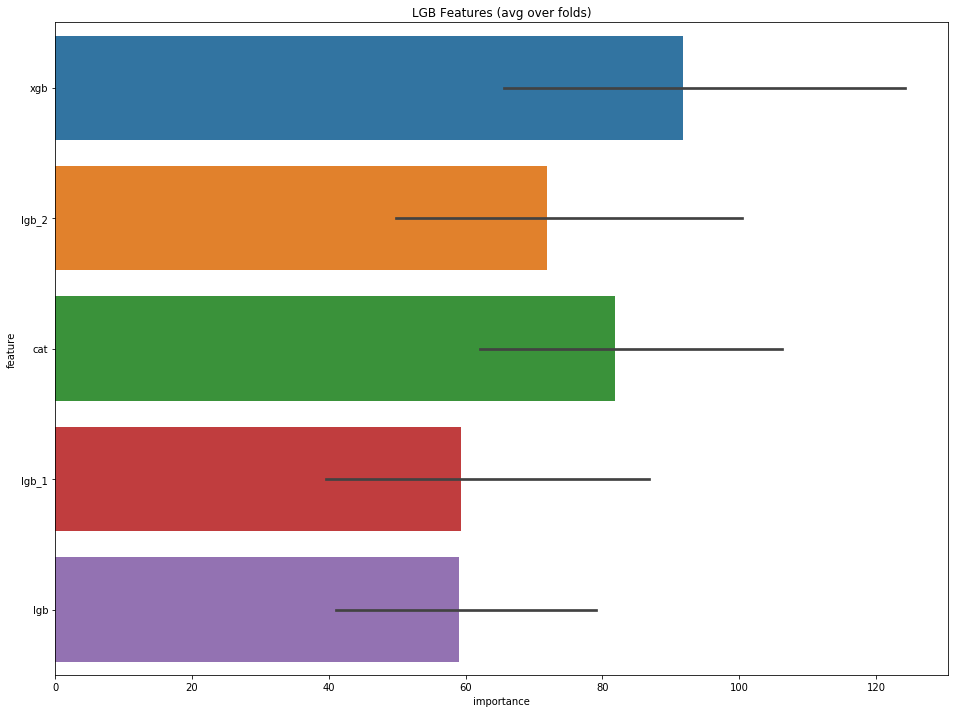

In [165]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
lgb_stack_model = LgbTrainer(X=train_stack, X_test=test_stack, y=y, params=params)
lgb_stack_model.fit()
lgb_stack_model.show_model_scores()
lgb_stack_model.plot_feature_importance()


In [166]:
ridge_stack_model = RidgeTrainer(X=train_stack.values, X_test=test_stack.values, y=y)
ridge_stack_model.fit()
ridge_stack_model.show_model_scores()

Fold 0 started at Wed Feb 26 13:58:06 2020
Fold 1 started at Wed Feb 26 13:58:06 2020
Fold 2 started at Wed Feb 26 13:58:06 2020
Fold 3 started at Wed Feb 26 13:58:06 2020
Fold 4 started at Wed Feb 26 13:58:06 2020
Fold 5 started at Wed Feb 26 13:58:06 2020
Fold 6 started at Wed Feb 26 13:58:06 2020
Fold 7 started at Wed Feb 26 13:58:06 2020
Fold 8 started at Wed Feb 26 13:58:06 2020
Fold 9 started at Wed Feb 26 13:58:06 2020
Ridge Cross Validation mean score: 1.9166, std: 0.1757.


In [167]:
pred = pd.read_csv('data/sample_submission.csv')
pred['revenue'] = np.expm1(lgb_model.prediction)
pred.to_csv("lgb.csv", index=False)
pred['revenue'] = np.expm1((lgb_model.prediction + xgb_model.prediction) / 2)
pred.to_csv("blend.csv", index=False)
pred['revenue'] = np.expm1((lgb_model.prediction + xgb_model.prediction + cat_model.prediction) / 3)
pred.to_csv("blend1.csv", index=False)
pred['revenue'] = np.expm1((lgb_model.prediction + xgb_model.prediction + cat_model.prediction + lgb_model1.prediction) / 4)
pred.to_csv("blend2.csv", index=False)
pred['revenue'] = np.expm1((lgb_model.prediction + xgb_model.prediction + cat_model.prediction + lgb_model1.prediction + lgb_model2.prediction) / 5)
pred.to_csv("blend3.csv", index=False)

pred['revenue'] = lgb_stack_model.prediction
pred.to_csv("stack_lgb.csv", index=False)